In [1]:
# Essential Libraries
import numpy as np
import pandas as pd

# Preprocessing Libraries
from sklearn.preprocessing import PowerTransformer, StandardScaler, FunctionTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from scipy.stats import mode

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

# Specialized ML Libraries
from xgboost import XGBClassifier
from sklearn.utils import parallel_backend
from sklearn import metrics

plt.style.use("default")

In [3]:

# ====================================================
# Loading and Preparing the Train Dataset
# ====================================================

# Step 1: Load Data
file_path = "/Users/vignesh/RStudio/IDA_Homework/IDA_HW_7/2024-dsa-ise-ida-classification-hw-7/hm7-Train-2024.csv"
train = pd.read_csv(file_path)
train


patientID             race  gender      age  admission_type  \
0           5306        Caucasian  Female   [0-10)               6   
1          55748        Caucasian  Female  [10-20)               1   
2          66495  AfricanAmerican  Female  [20-30)               1   
3          51933        Caucasian    Male  [30-40)               1   
4          40028        Caucasian    Male  [40-50)               1   
...          ...              ...     ...      ...             ...   
57850      52614        Caucasian  Female  [70-80)               1   
57851      31701  AfricanAmerican    Male  [70-80)               1   
57852      75986        Caucasian    Male  [70-80)               1   
57853       6740        Caucasian  Female  [80-90)               2   
57854      67895        Caucasian    Male  [70-80)               1   

       discharge_disposition  admission_source  time_in_hospital payer_code  \
0                         25                 1               1.0        NaN   
1                          1                 7               3.0        NaN   
2                          1                 7               2.0        NaN   
3                          1                 7               2.0        NaN   
4                          1                 7               1.0        NaN   
...                      ...               ...               ...        ...   
57850                      1                 7               5.0        NaN   
57851                      3                 7               3.0   medicare   
57852                      1                 7               1.0   medicare   
57853                      3                 7              10.0   medicare   
57854                      1                 7               6.0        NaN   

              medical_specialty  ...  examide  citoglipton  insulin  \
0      Pediatrics-Endocrinology  ...       No           No       No   
1                           NaN  ...       No           No       Up   
2                           NaN  ...       No           No       No   
3                           NaN  ...       No           No       Up   
4                           NaN  ...       No           No   Steady   
...                         ...  ...      ...          ...      ...   
57850                       NaN  ...       No           No   Steady   
57851                       NaN  ...       No           No     Down   
57852                       NaN  ...       No           No     Down   
57853           Surgery-General  ...       No           No       Up   
57854                       NaN  ...       No           No       No   

       glyburide-metformin  glipizide-metformin  glimepiride-pioglitazone  \
0                       No                   No                        No   
1                       No                   No                        No   
2                       No                   No                        No   
3                       No                   No                        No   
4                       No                   No                        No   
...                    ...                  ...                       ...   
57850                   No                   No                        No   
57851                   No                   No                        No   
57852                   No                   No                        No   
57853                   No                   No                        No   
57854                   No                   No                        No   

       metformin-rosiglitazone  metformin-pioglitazone diabetesMed  readmitted  
0                           No                      No          No           0  
1                           No                      No         Yes           1  
2                           No                      No         Yes           0  
3                           No                      No         Yes           0  
4                           No    

In [4]:
# View data structure
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57855 entries, 0 to 57854
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   patientID                 57855 non-null  int64  
 1   race                      56542 non-null  object 
 2   gender                    57850 non-null  object 
 3   age                       57854 non-null  object 
 4   admission_type            57855 non-null  int64  
 5   discharge_disposition     57855 non-null  int64  
 6   admission_source          57855 non-null  int64  
 7   time_in_hospital          57851 non-null  float64
 8   payer_code                36340 non-null  object 
 9   medical_specialty         30045 non-null  object 
 10  indicator_level           57849 non-null  float64
 11  indicator_2_level         29046 non-null  float64
 12  num_lab_procedures        57854 non-null  float64
 13  num_procedures            57855 non-null  int64  
 14  num_me

In [5]:
# Check for missing values
train.isnull().sum()

patientID                       0
race                         1313
gender                          5
age                             1
admission_type                  0
discharge_disposition           0
admission_source                0
time_in_hospital                4
payer_code                  21515
medical_specialty           27810
indicator_level                 6
indicator_2_level           28809
num_lab_procedures              1
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diagnosis                      11
number_diagnoses                0
max_glu_serum               54736
A1Cresult                   48099
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide     

In [6]:
# Check for duplicate rows
duplicates = train[train.duplicated()]
print(f"Number of duplicate rows: {len(duplicates)}")

Number of duplicate rows: 0


In [7]:

# ====================================================
# Converting Selected Variables to Object Type
# ====================================================


# Convert specified columns to object (string) type
cols_to_convert_to_string = [
    "admission_type",
    "discharge_disposition",
    "admission_source",
    "readmitted",
]
train[cols_to_convert_to_string] = (
    train[cols_to_convert_to_string].fillna("").astype(str)
)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57855 entries, 0 to 57854
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   patientID                 57855 non-null  int64  
 1   race                      56542 non-null  object 
 2   gender                    57850 non-null  object 
 3   age                       57854 non-null  object 
 4   admission_type            57855 non-null  object 
 5   discharge_disposition     57855 non-null  object 
 6   admission_source          57855 non-null  object 
 7   time_in_hospital          57851 non-null  float64
 8   payer_code                36340 non-null  object 
 9   medical_specialty         30045 non-null  object 
 10  indicator_level           57849 non-null  float64
 11  indicator_2_level         29046 non-null  float64
 12  num_lab_procedures        57854 non-null  float64
 13  num_procedures            57855 non-null  int64  
 14  num_me

In [8]:

# ====================================================
# Selecting Numeric Data and Computing Summary Statistics
# ====================================================

# Select numeric data
train_numeric = train.select_dtypes(include=[np.number])


# Function to compute summary statistics
def numeric_summary(df):
    if len(df) == 0:
        raise ValueError("Input DataFrame is empty.")

    summary = pd.DataFrame()
    summary["missing"] = df.isna().sum()
    summary["missing_pct"] = (summary["missing"] / len(df)) * 100
    summary["unique"] = df.nunique()
    summary["unique_pct"] = (summary["unique"] / len(df)) * 100
    descriptive_stats = df.describe().T
    summary = pd.concat([summary, descriptive_stats], axis=1)
    return summary


numeric_summary_df = numeric_summary(train_numeric)
numeric_summary_df

missing  missing_pct  unique  unique_pct    count  \
patientID                 0     0.000000   57855  100.000000  57855.0   
time_in_hospital          4     0.006914      14    0.024198  57851.0   
indicator_level           6     0.010371    9974   17.239651  57849.0   
indicator_2_level     28809    49.795178    7431   12.844179  29046.0   
num_lab_procedures        1     0.001728     114    0.197044  57854.0   
num_procedures            0     0.000000       7    0.012099  57855.0   
num_medications           0     0.000000      74    0.127906  57855.0   
number_outpatient         0     0.000000      37    0.063953  57855.0   
number_emergency          0     0.000000      30    0.051854  57855.0   
number_inpatient          0     0.000000      19    0.032841  57855.0   
number_diagnoses          0     0.000000      16    0.027655  57855.0   

                            mean           std      min       25%       50%  \
patientID           49203.429142  27816.902427  1001.00  25106.50  49212.00   
time_in_hospital        4.362535      2.953151     1.00      2.00      4.00   
indicator_level        49.849578     29.684841  -869.00     24.79     49.74   
indicator_2_level      25.091996     22.381117  -682.23      6.93     18.79   
num_lab_procedures     42.956027     19.839108     1.00     31.00     44.00   
num_procedures          1.324916      1.699126     0.00      0.00      1.00   
num_medications        15.993726      8.052060     1.00     10.00     15.00   
number_outpatient       0.386034      1.318398     0.00      0.00      0.00   
number_emergency        0.206741      0.958341     0.00      0.00      0.00   
number_inpatient        0.625892      1.251464     0.00      0.00      0.00   
number_diagnoses        7.429678      1.934791     1.00      6.00      8.00   

                           75%       max  
patientID           73317.0000  97421.00  
time_in_hospital        6.0000     14.00  
indicator_level        74.7900    999.00  
indicator_2_level      38.0175     99.33  
num_lab_procedures     57.0000    132.00  
num_procedures          2.0000      6.00  
num_medications        20.0000     81.00  
number_outpatient       0.0000     42.00  
number_emergency        0.0000     64.00  
number_inpatient        1.0000     19.00  
number_diagnoses        9.0000     16.00

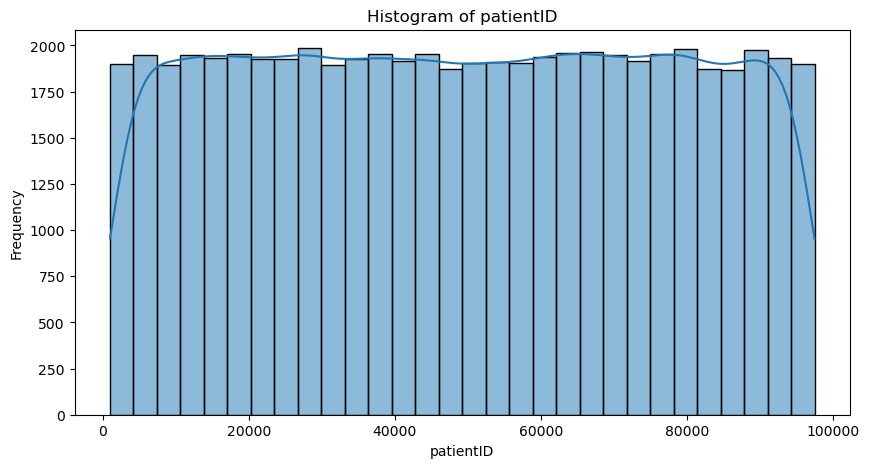

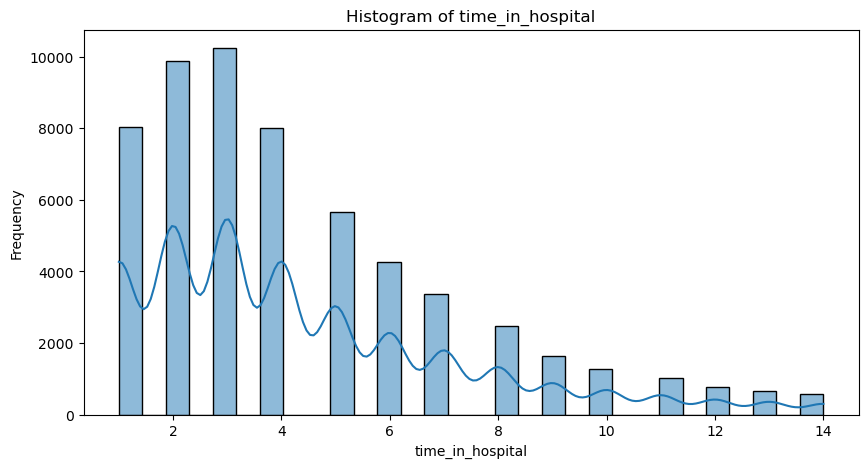

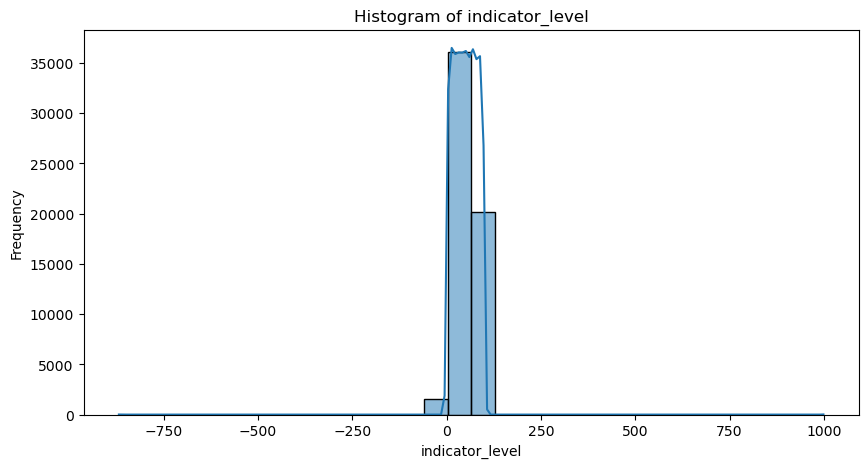

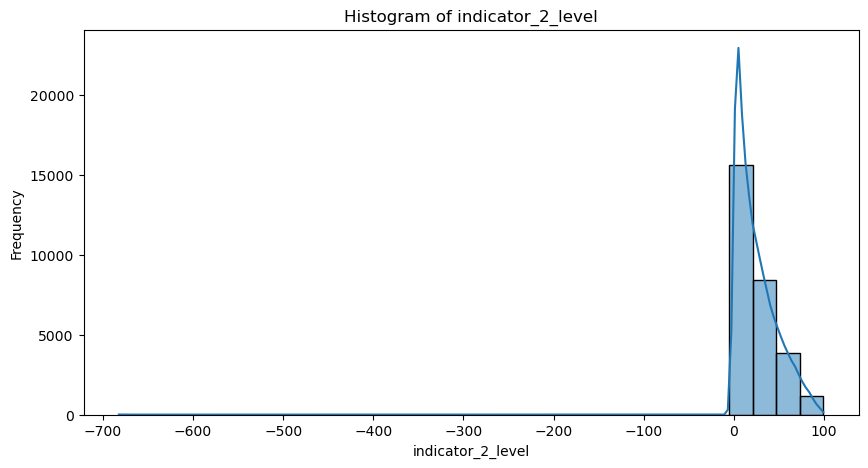

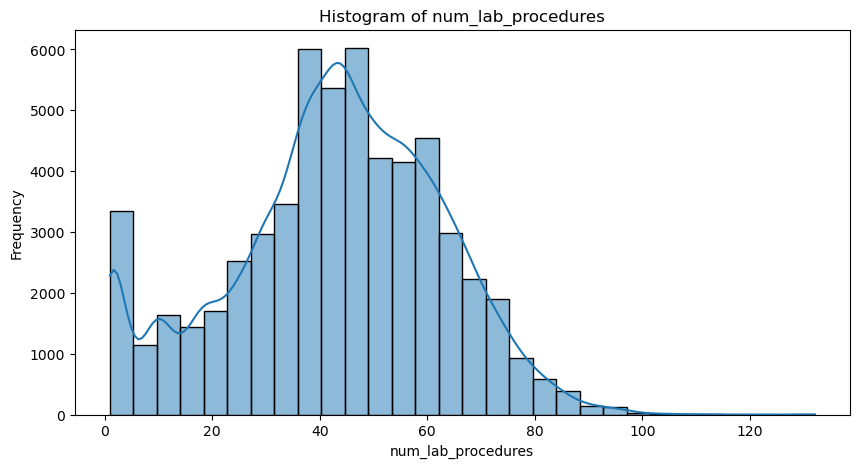

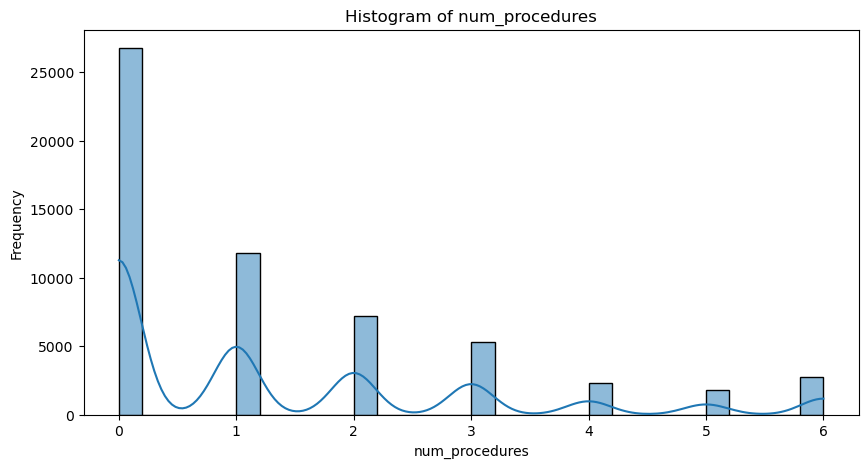

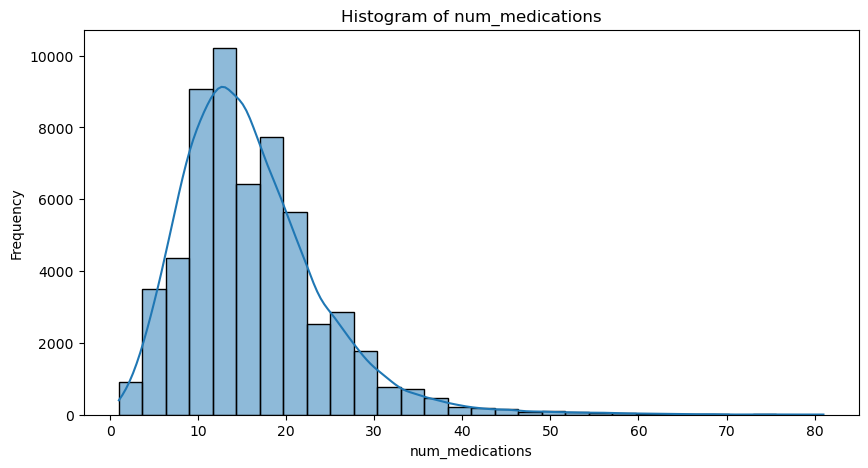

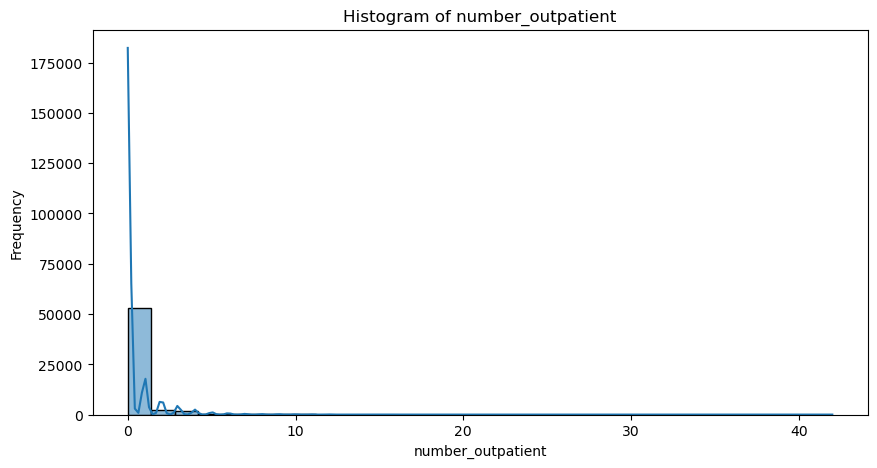

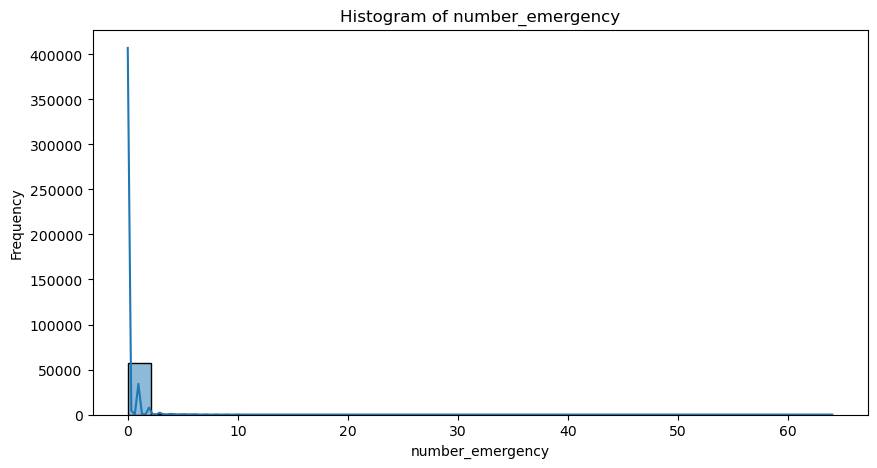

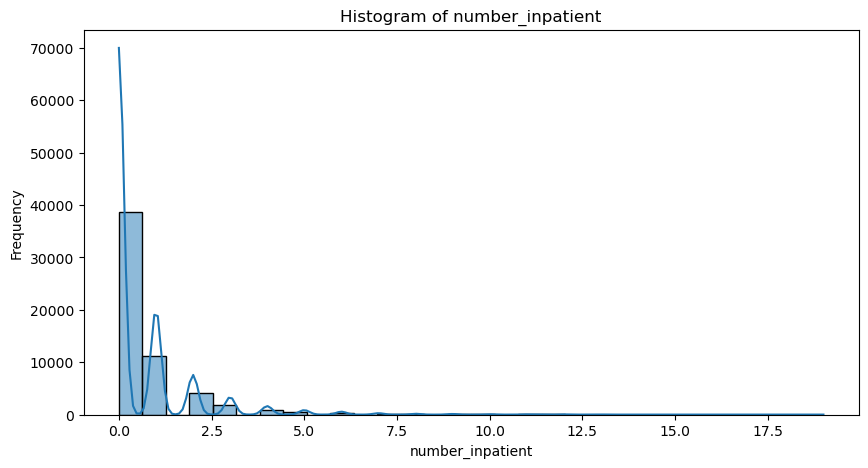

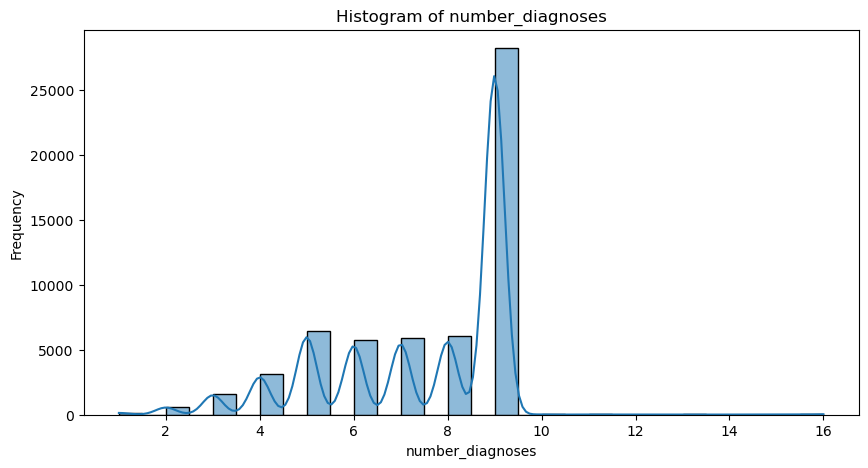

In [9]:

# ====================================================
# Plotting Histograms of Numeric Variables
# ====================================================


# Plot Histograms
def plot_histogram(data, column_name):
    plt.figure(figsize=(10, 5))
    sns.histplot(data[column_name], kde=True, bins=30)
    plt.title(f"Histogram of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.show()


for col in train_numeric.columns:
    plot_histogram(train_numeric, col)

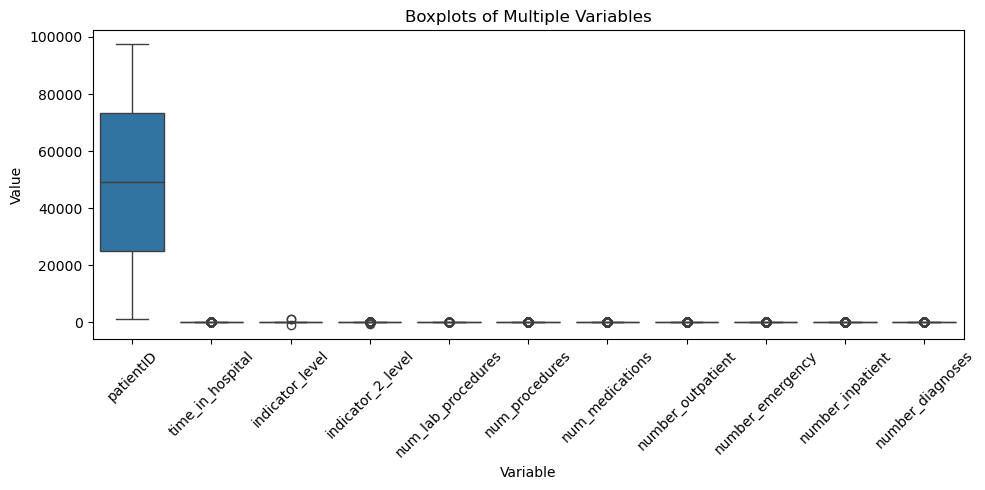

In [10]:

# Plot Boxplots of all variable
def plot_multiple_boxplots(data):
    # Convert the DataFrame to long format if needed
    data_long = data.melt(var_name="Variable", value_name="Value")
    plt.figure(figsize=(10, 5))
    sns.boxplot(x="Variable", y="Value", data=data_long)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.title("Boxplots of Multiple Variables")
    plt.xlabel("Variable")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()


plot_multiple_boxplots(train_numeric)


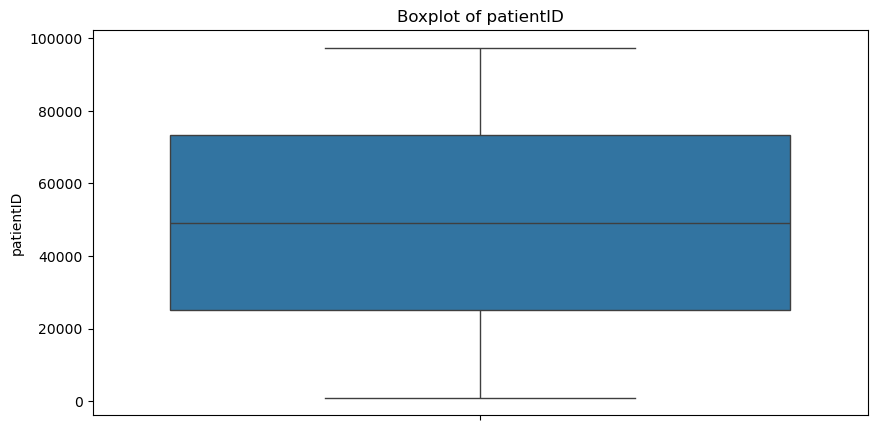

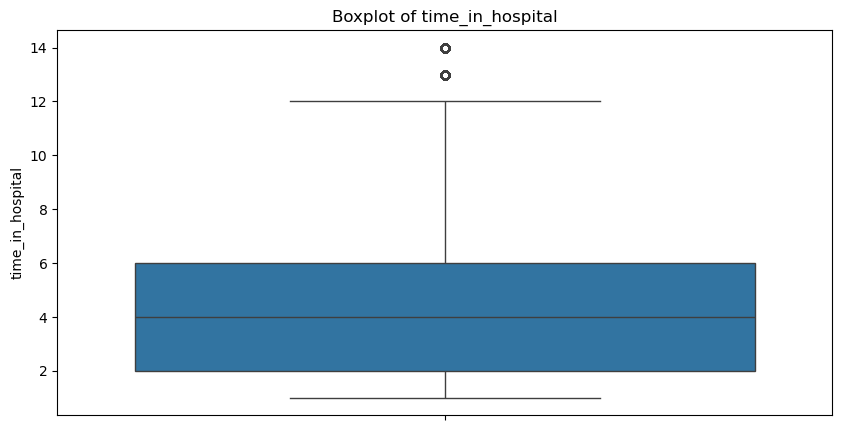

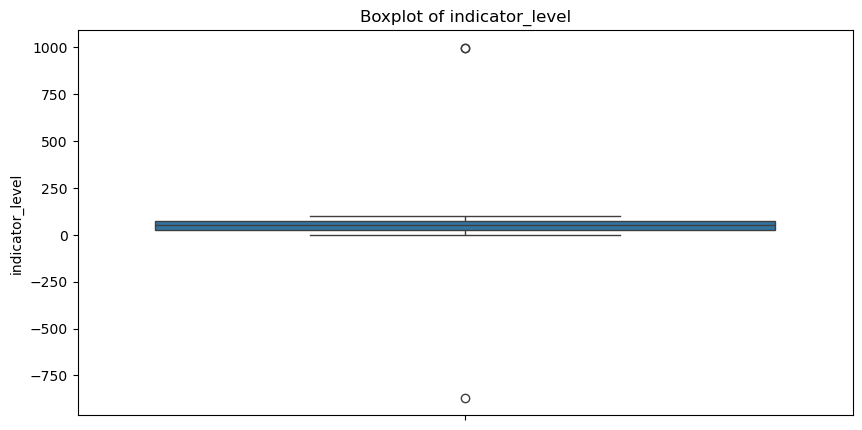

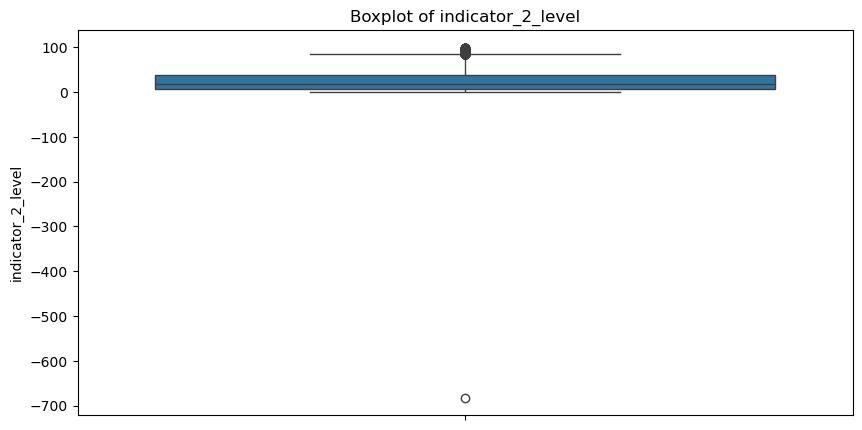

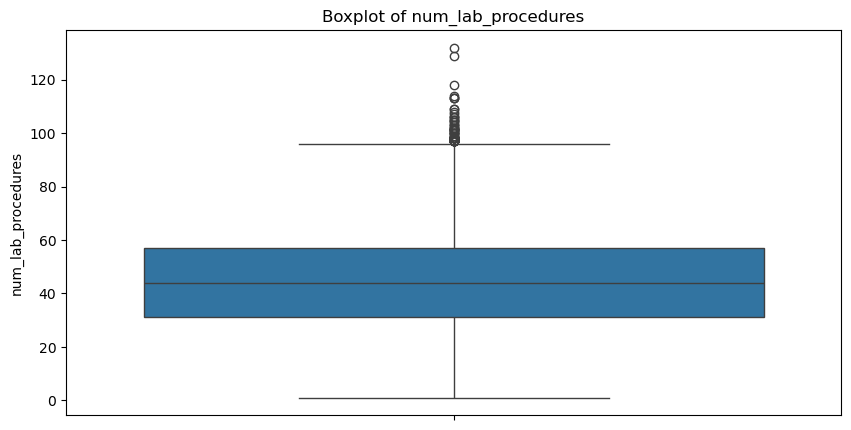

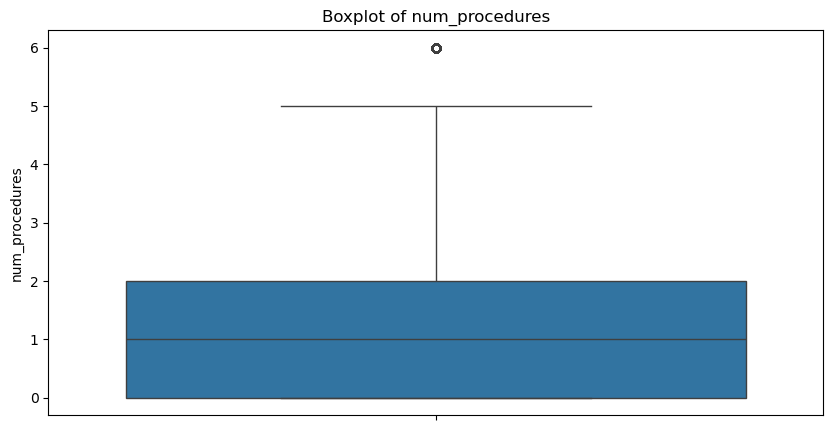

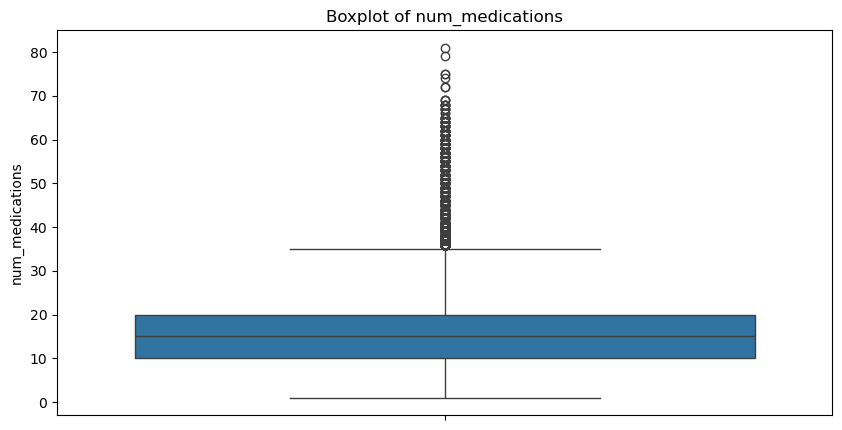

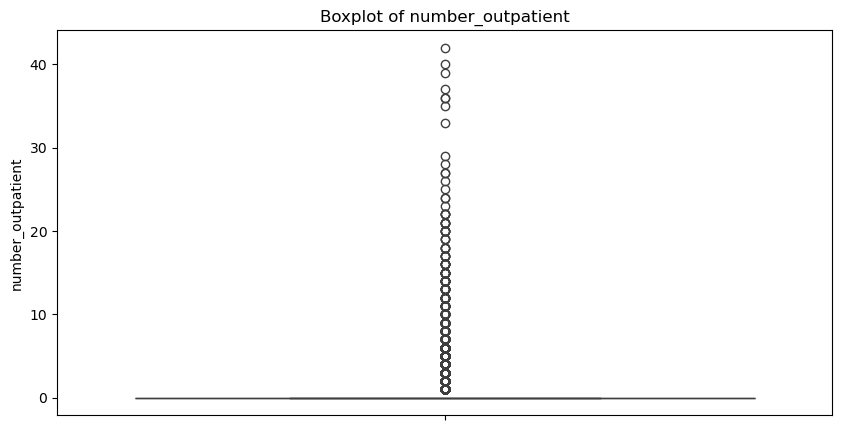

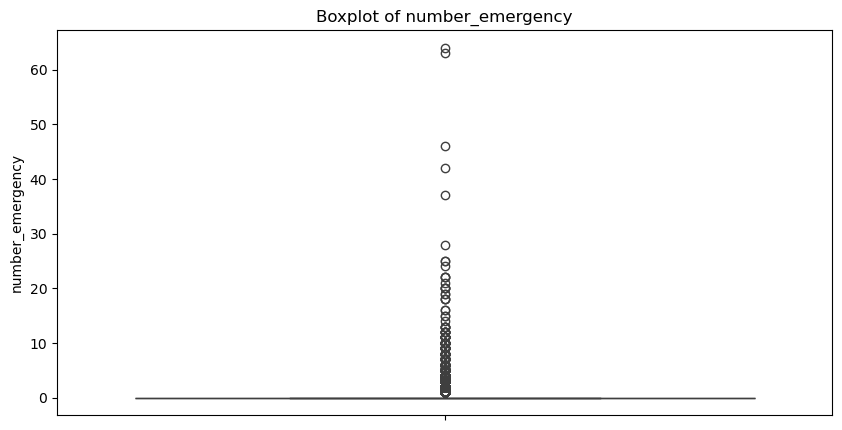

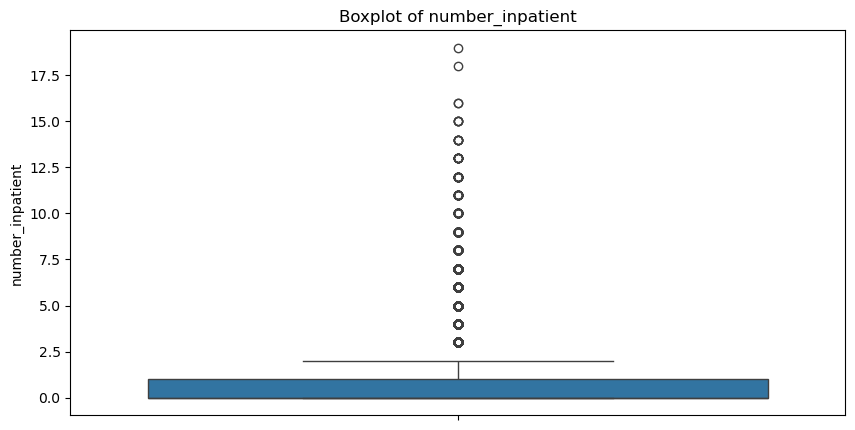

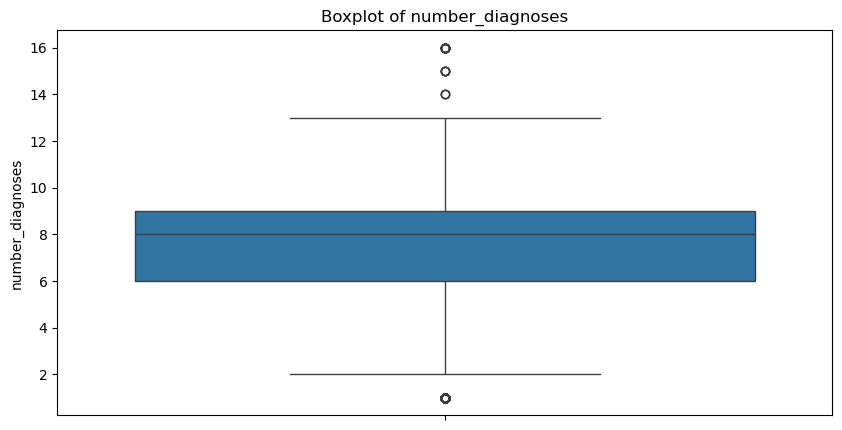

In [11]:

# Plot Boxplots
def plot_individual_boxplots(data):
    for column in data.columns:
        plt.figure(figsize=(10, 5))
        sns.boxplot(y=data[column])
        plt.title(f"Boxplot of {column}")
        plt.ylabel(column)
        plt.show()


# Call the function
plot_individual_boxplots(train_numeric)

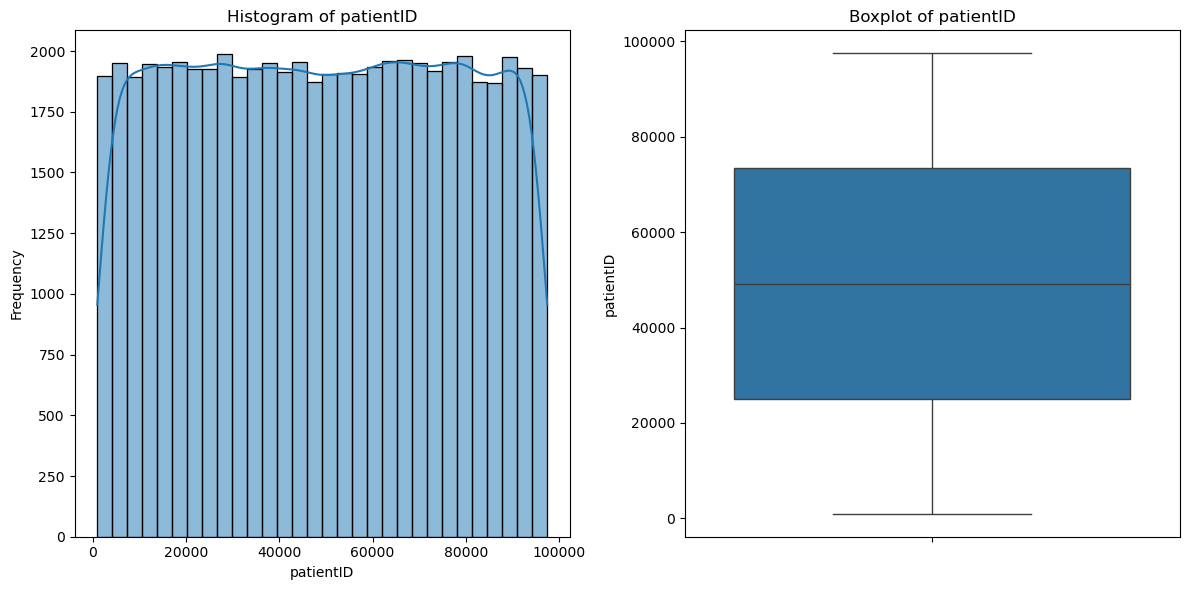

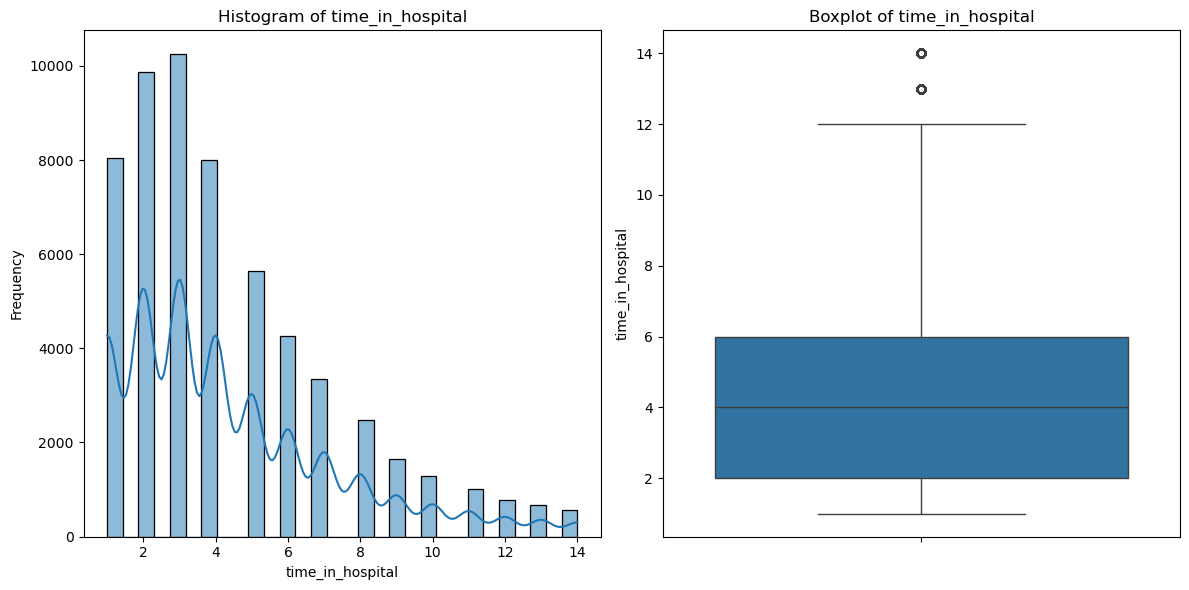

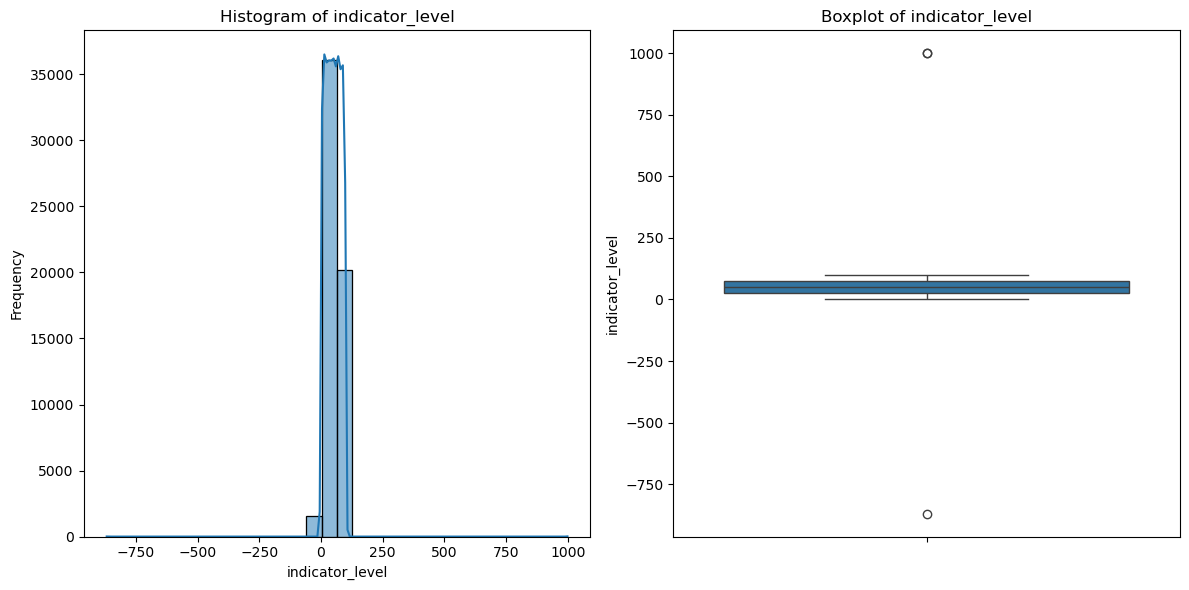

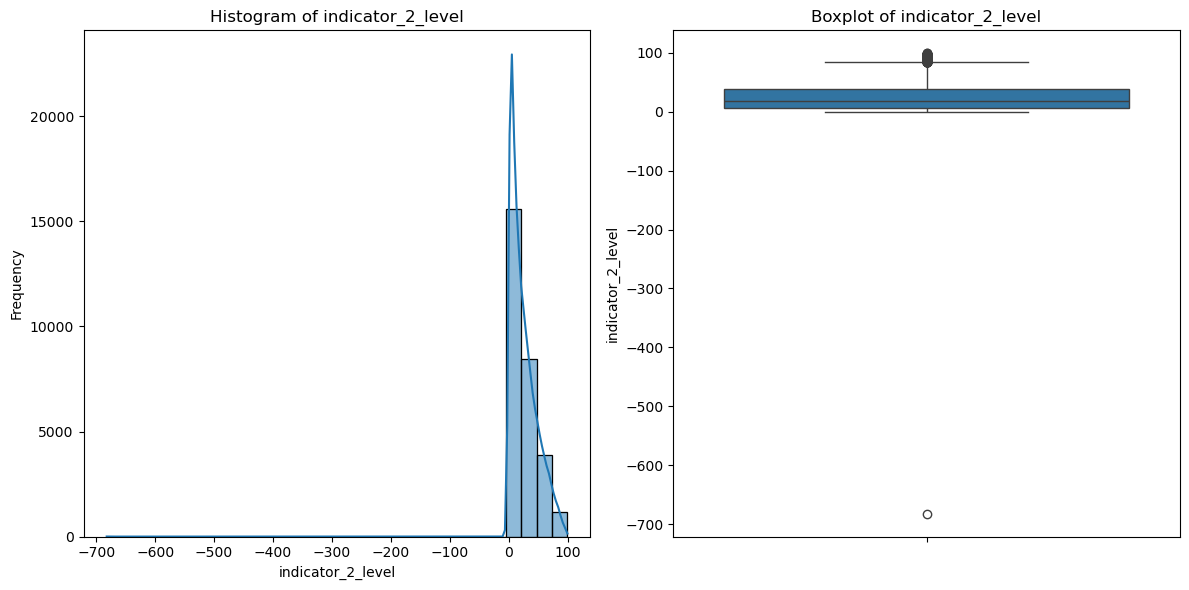

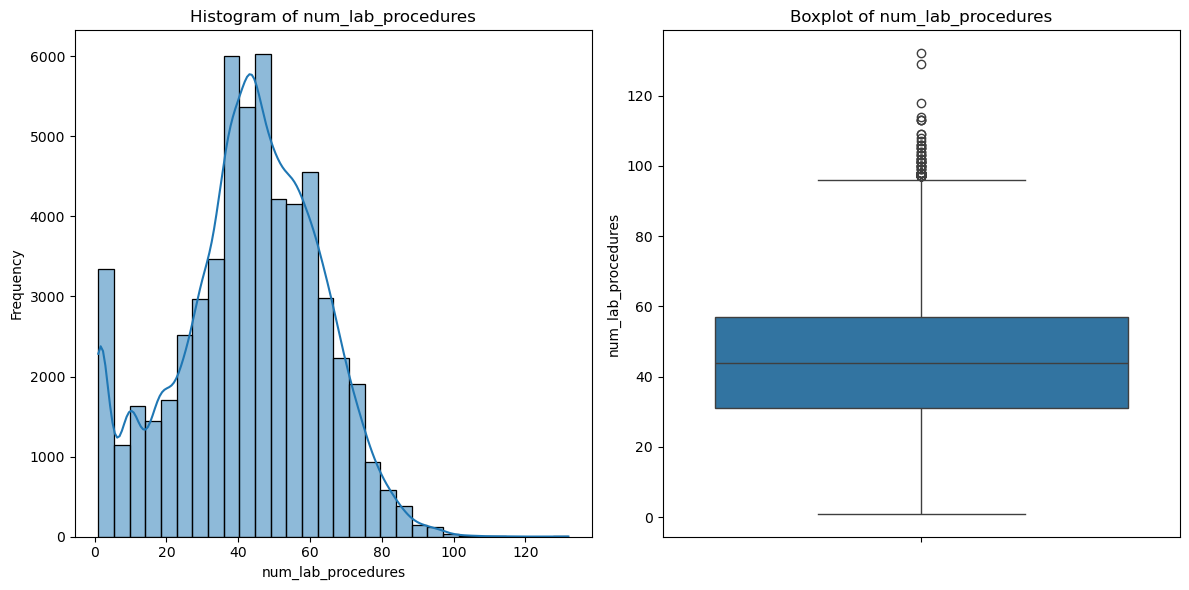

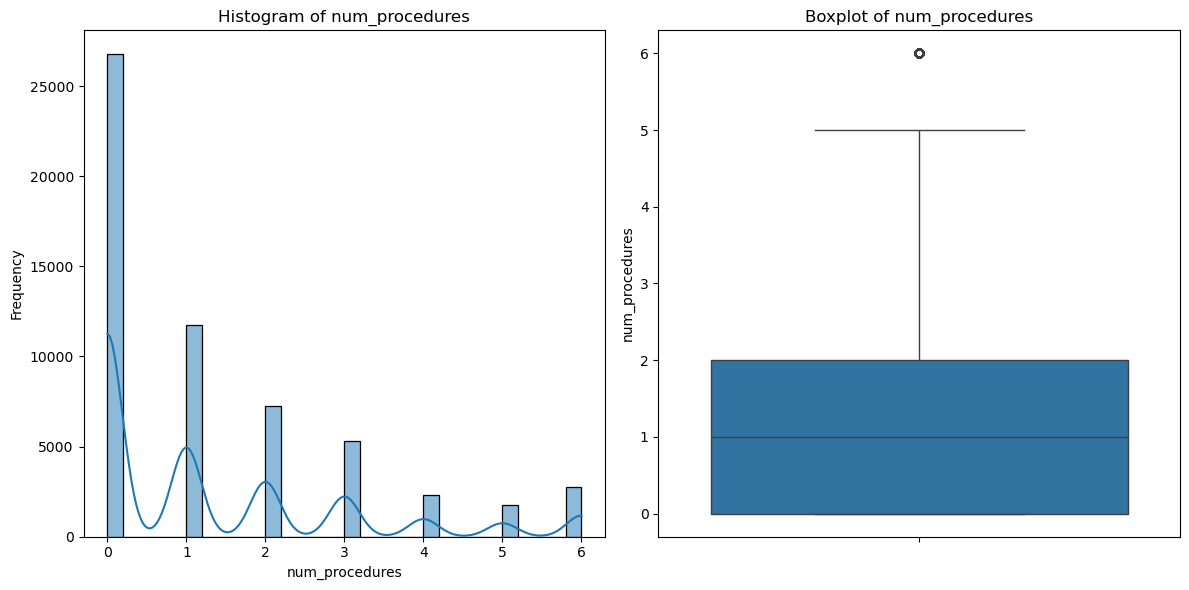

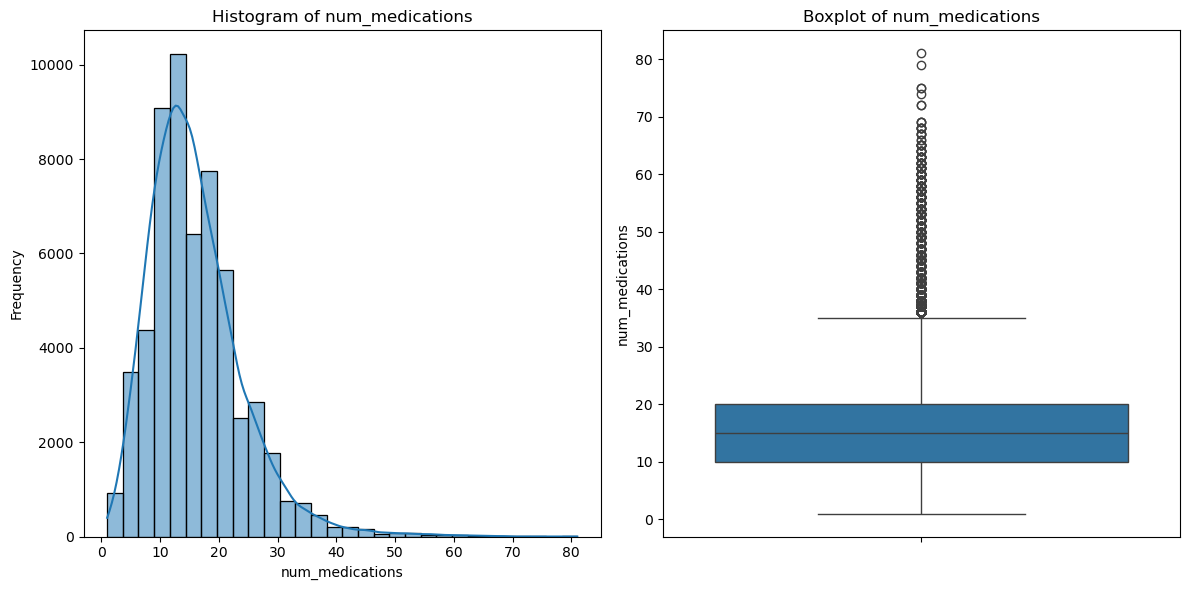

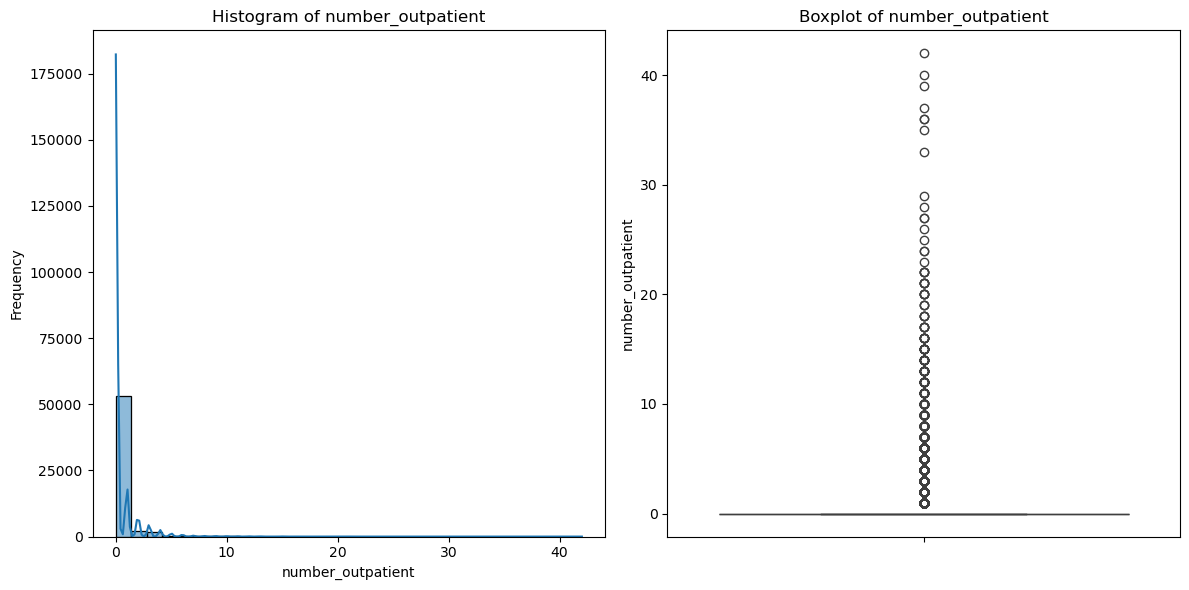

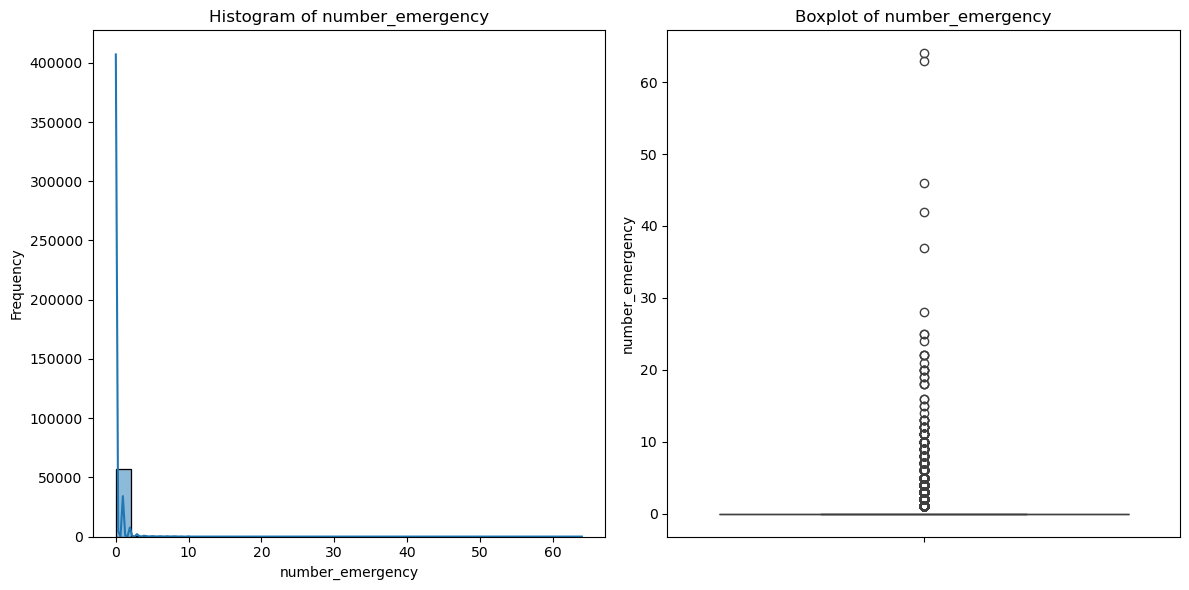

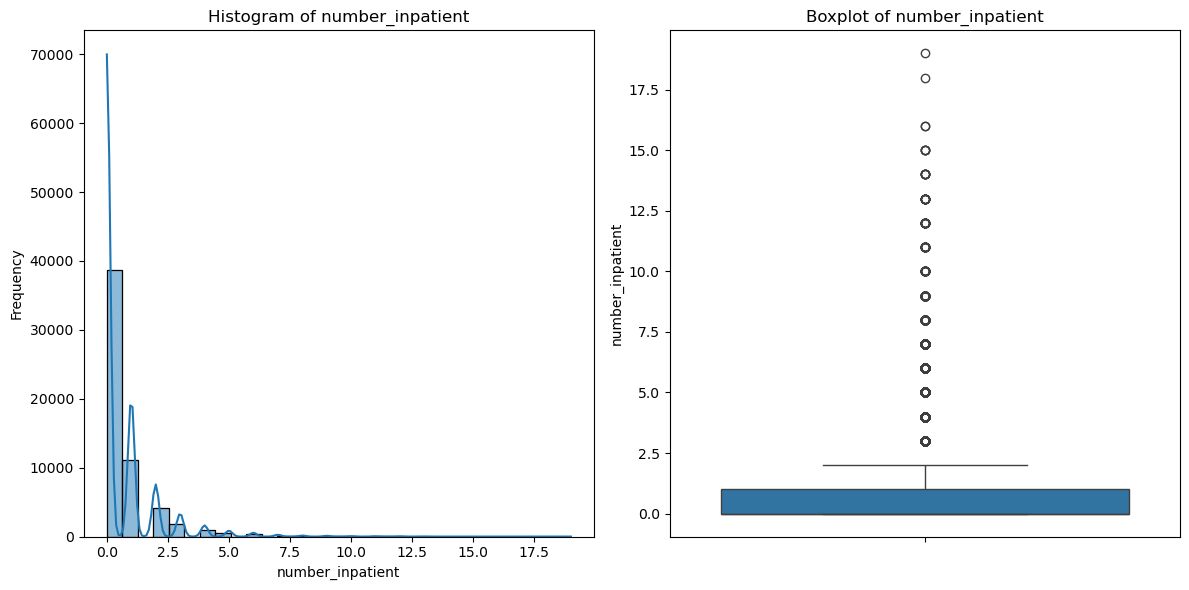

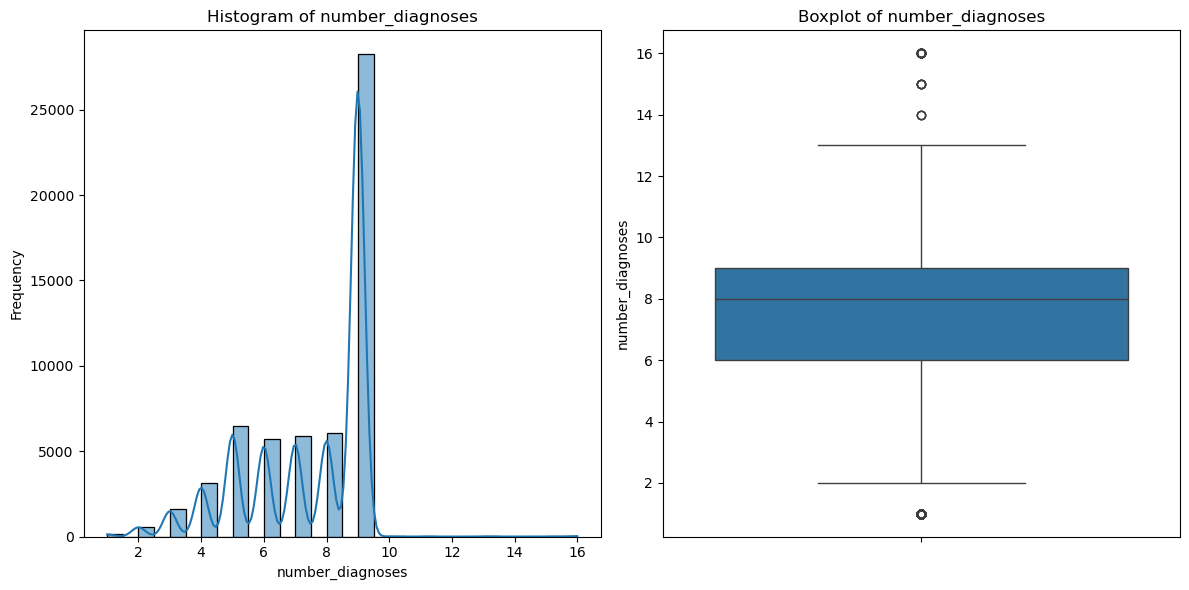

In [12]:

# Plot histograms and Boxplots usig subplots
def plot_combined_histogram_boxplot(data):
    for column in data.columns:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Histogram
        sns.histplot(data[column], kde=True, bins=30, ax=axes[0])
        axes[0].set_title(f"Histogram of {column}")
        axes[0].set_xlabel(column)
        axes[0].set_ylabel("Frequency")

        # Boxplot
        sns.boxplot(y=data[column], ax=axes[1])
        axes[1].set_title(f"Boxplot of {column}")
        axes[1].set_ylabel(column)

        plt.tight_layout()
        plt.show()


# Call the function
plot_combined_histogram_boxplot(train_numeric)

In [13]:

# ====================================================
# Outlier Detection and Removal
# ====================================================


# Remove Outlier using IQR
def remove_outliers_iqr_columnwise(data, multiplier=1.5):
    filtered_data = data.copy()
    for column in data.select_dtypes(
        include=["number"]
    ).columns:  # Apply only to numeric columns
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (multiplier * IQR)
        upper_bound = Q3 + (multiplier * IQR)
        # Keep only values within bounds for this column
        filtered_data = filtered_data[
            (filtered_data[column] >= lower_bound)
            & (filtered_data[column] <= upper_bound)
        ]
    return filtered_data


def set_outliers_to_nan_iqr(data, multiplier=1.5):
    filtered_data = data.copy()
    for column in data.select_dtypes(
        include=["number"]
    ).columns:  # Apply only to numeric columns
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (multiplier * IQR)
        upper_bound = Q3 + (multiplier * IQR)
        # Set outliers to NaN
        filtered_data.loc[
            (data[column] < lower_bound) | (data[column] > upper_bound), column
        ] = np.nan
    return filtered_data


cleaned_data = set_outliers_to_nan_iqr(train_numeric)

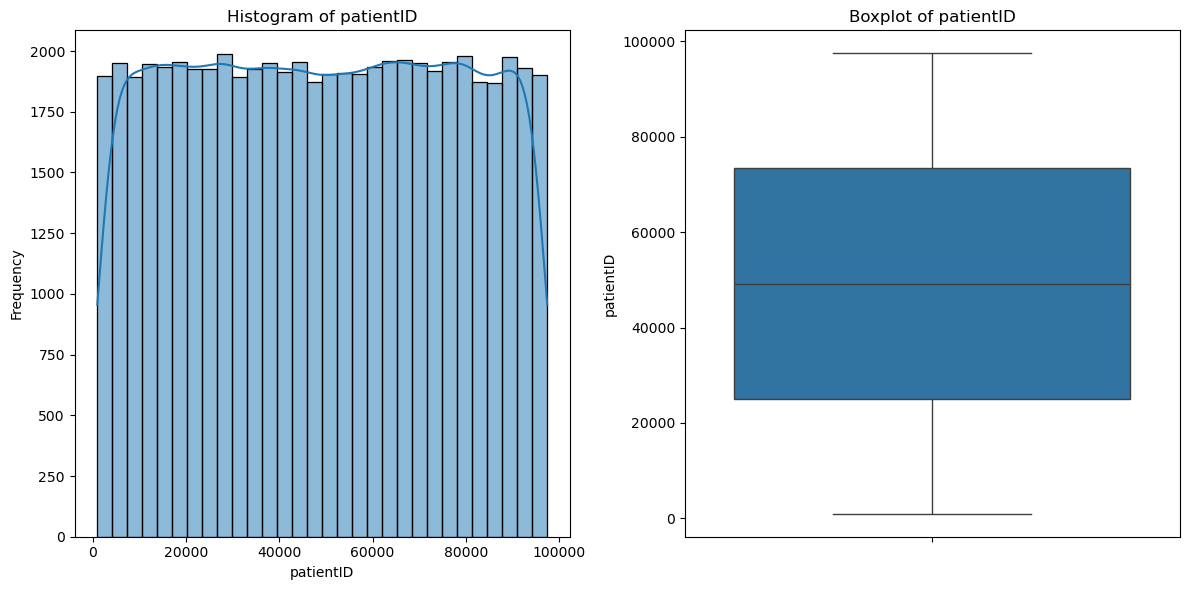

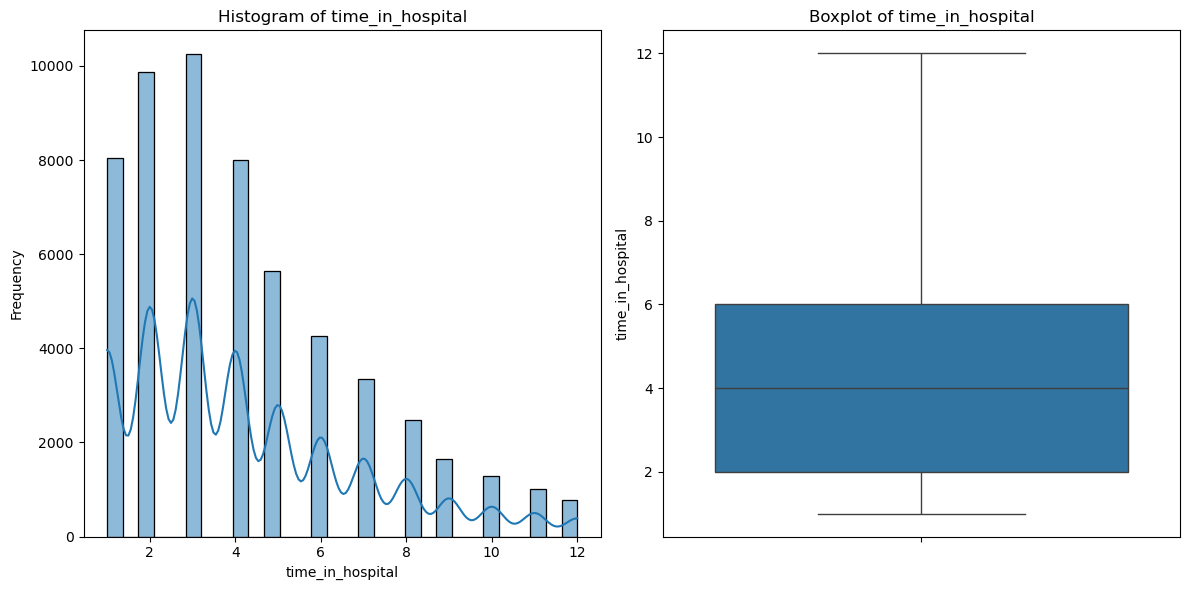

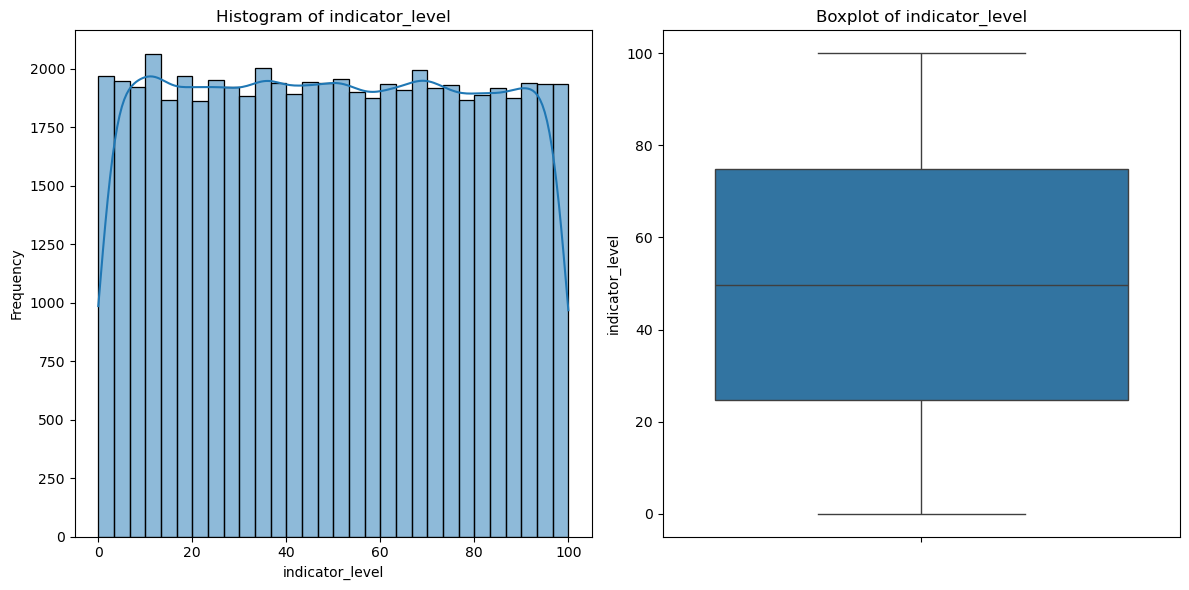

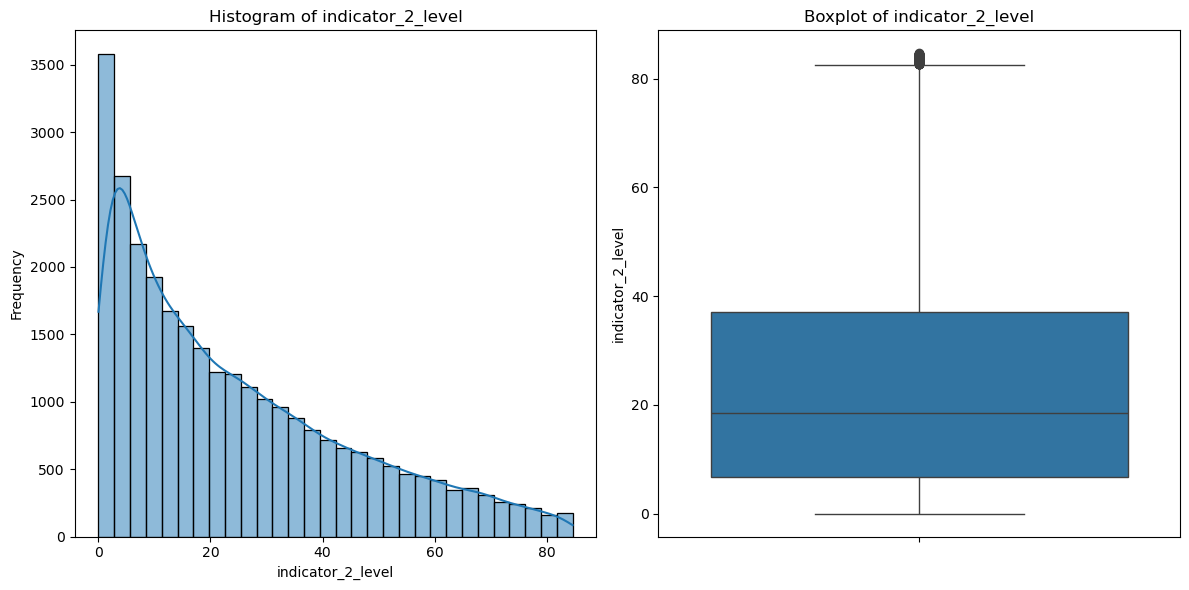

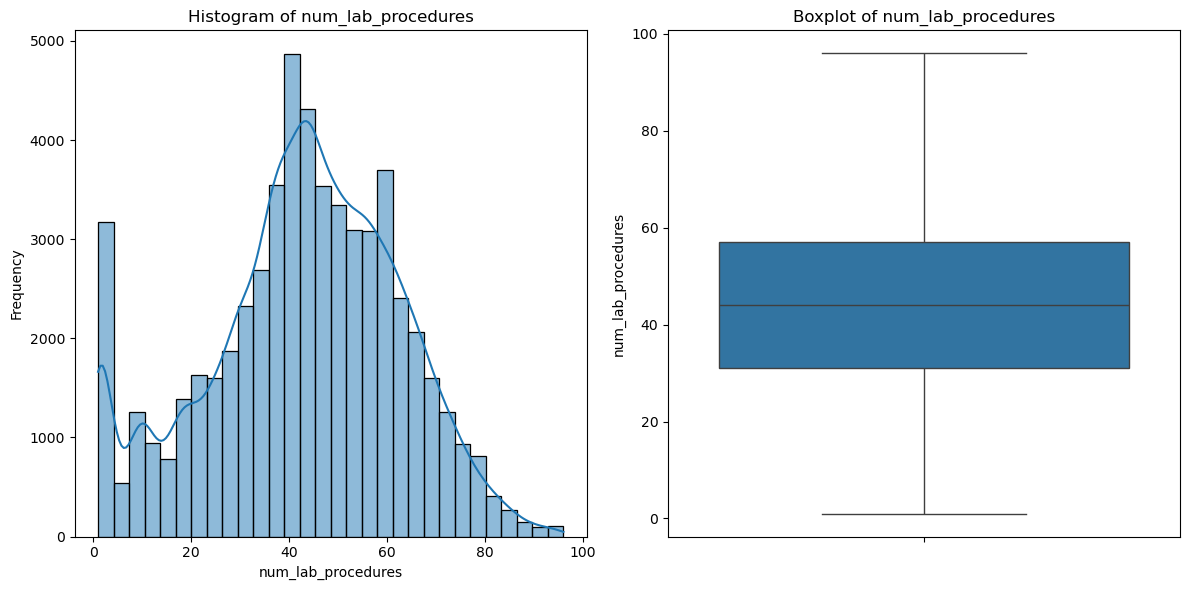

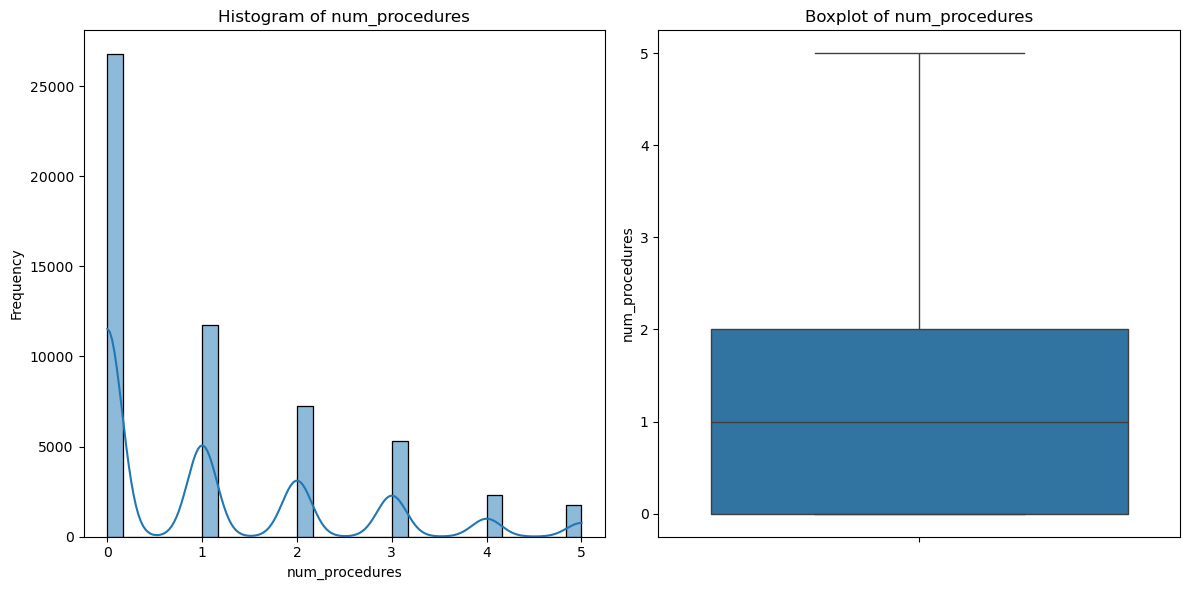

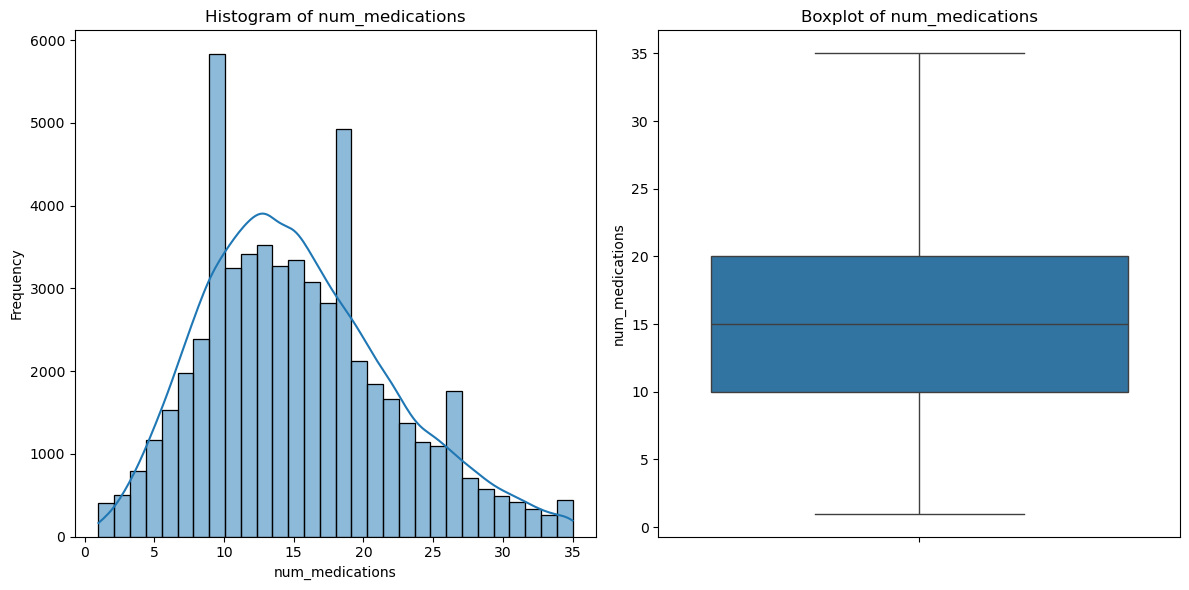

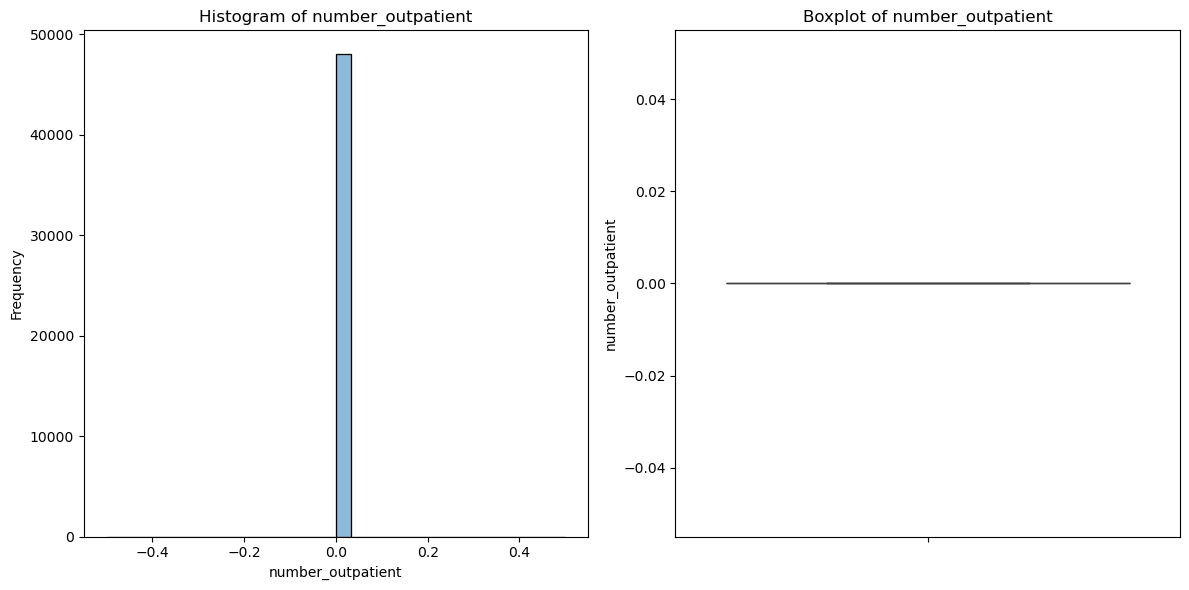

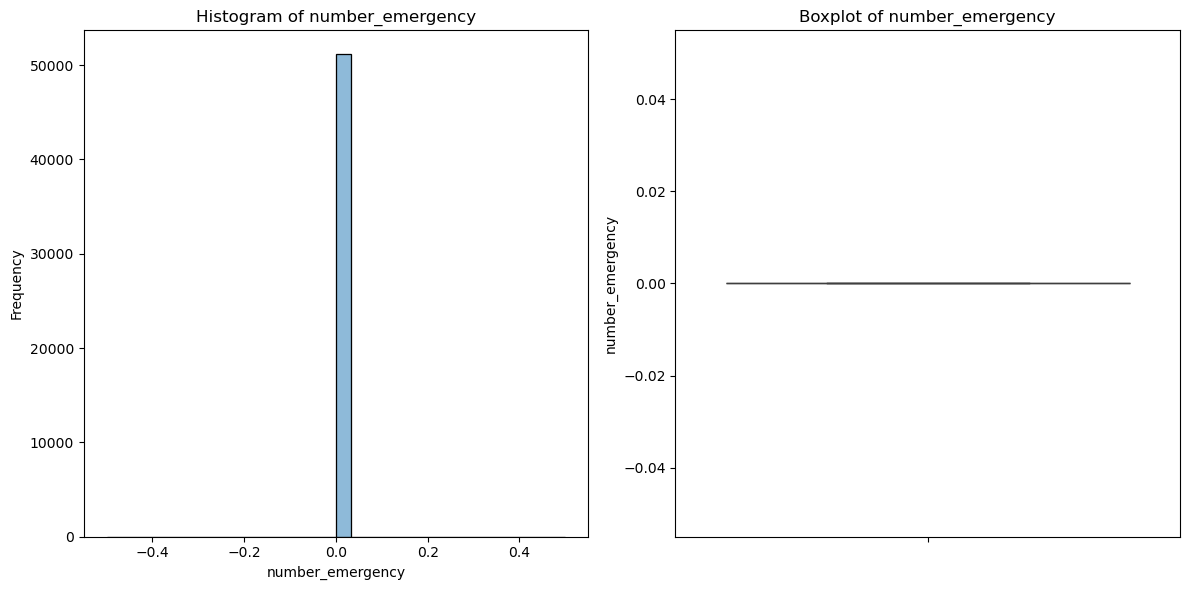

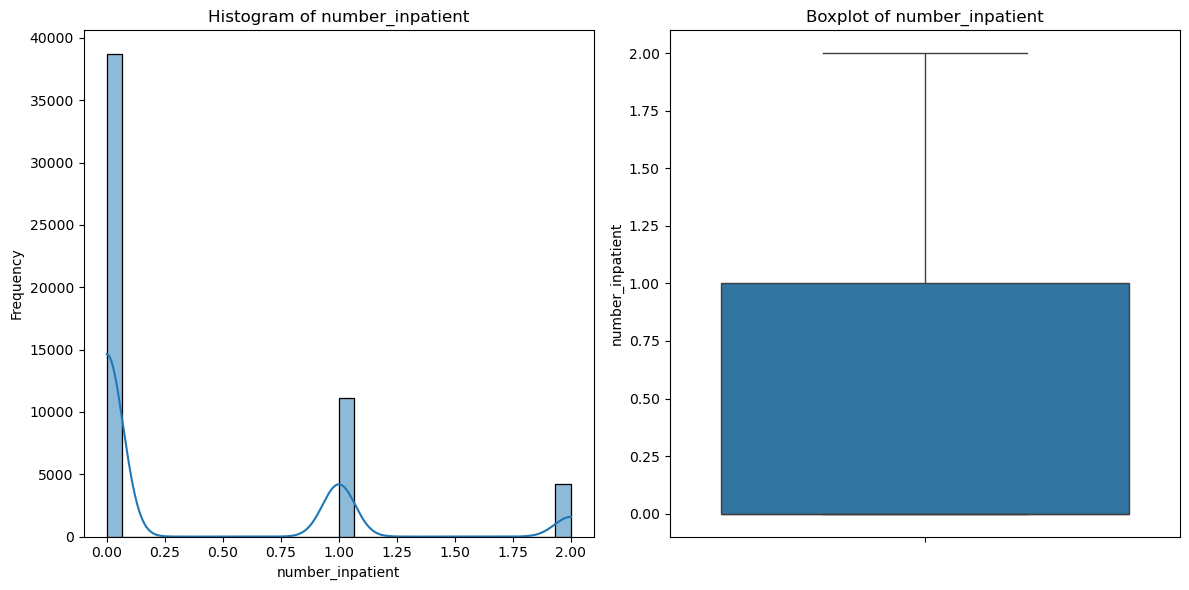

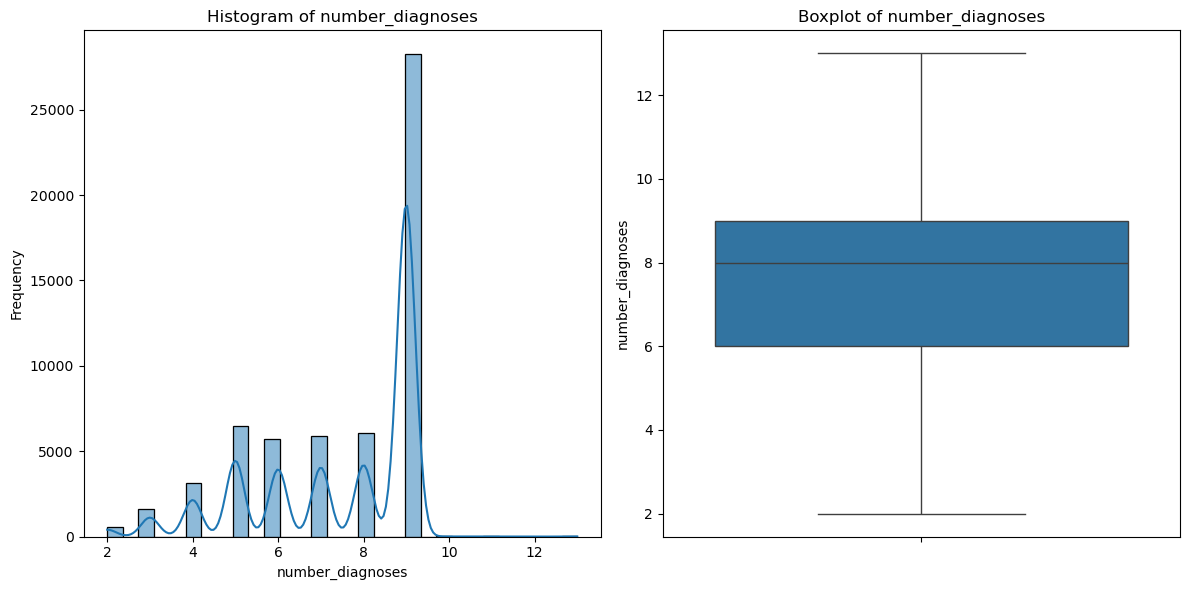

In [14]:

def plot_combined_histogram_boxplot(data):
    for column in data.columns:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Histogram
        sns.histplot(data[column], kde=True, bins=30, ax=axes[0])
        axes[0].set_title(f"Histogram of {column}")
        axes[0].set_xlabel(column)
        axes[0].set_ylabel("Frequency")

        # Boxplot
        sns.boxplot(y=data[column], ax=axes[1])
        axes[1].set_title(f"Boxplot of {column}")
        axes[1].set_ylabel(column)

        plt.tight_layout()
        plt.show()


plot_combined_histogram_boxplot(cleaned_data)


In [15]:

cleaned_data.columns
cleaned_data.drop(
    columns=[
        "patientID",
        "number_inpatient",
        "number_emergency",
        "number_outpatient",
    ],
    inplace=True,
)

cleaned_data

time_in_hospital  indicator_level  indicator_2_level  \
0                   1.0            52.58                NaN   
1                   3.0            62.77               0.42   
2                   2.0            30.24                NaN   
3                   2.0            54.07                NaN   
4                   1.0            48.93                NaN   
...                 ...              ...                ...   
57850               5.0            42.67                NaN   
57851               3.0            84.64               0.84   
57852               1.0            56.86                NaN   
57853              10.0            13.38                NaN   
57854               6.0            96.11                NaN   

       num_lab_procedures  num_procedures  num_medications  number_diagnoses  
0                    41.0             0.0              1.0               NaN  
1                    59.0             0.0             18.0               9.0  
2                    11.0             5.0             13.0               6.0  
3                    44.0             1.0             16.0               7.0  
4                    51.0             0.0              8.0               5.0  
...                   ...             ...              ...               ...  
57850                21.0             1.0             16.0               9.0  
57851                51.0             0.0             16.0               9.0  
57852                53.0             0.0              9.0              13.0  
57853                45.0             2.0             21.0               9.0  
57854                13.0             3.0              3.0               9.0  

[57855 rows x 7 columns]

In [16]:
cleaned_data.columns.to_list()

['time_in_hospital',
 'indicator_level',
 'indicator_2_level',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_diagnoses']

In [17]:

numeric_summary(cleaned_data)

missing  missing_pct  unique  unique_pct    count  \
time_in_hospital       1235     2.134647      12    0.020742  56620.0   
indicator_level           9     0.015556    9972   17.236194  57846.0   
indicator_2_level     29176    50.429522    7120   12.306629  28679.0   
num_lab_procedures       75     0.129634      96    0.165932  57780.0   
num_procedures         2767     4.782646       6    0.010371  55088.0   
num_medications        1374     2.374903      35    0.060496  56481.0   
number_diagnoses        172     0.297295      12    0.020742  57683.0   

                         mean        std   min    25%    50%     75%     max  
time_in_hospital     4.164783   2.658476  1.00   2.00   4.00   6.000   12.00  
indicator_level     49.832646  28.904866  0.01  24.79  49.74  74.780  100.00  
indicator_2_level   24.289348  20.866636  0.02   6.79  18.43  37.105   84.63  
num_lab_procedures  42.880547  19.737813  1.00  31.00  44.00  57.000   96.00  
num_procedures       1.090092   1.370789  0.00   0.00   1.00   2.000    5.00  
num_medications     15.322462   6.781343  1.00  10.00  15.00  20.000   35.00  
number_diagnoses     7.439939   1.901234  2.00   6.00   8.00   9.000   13.00

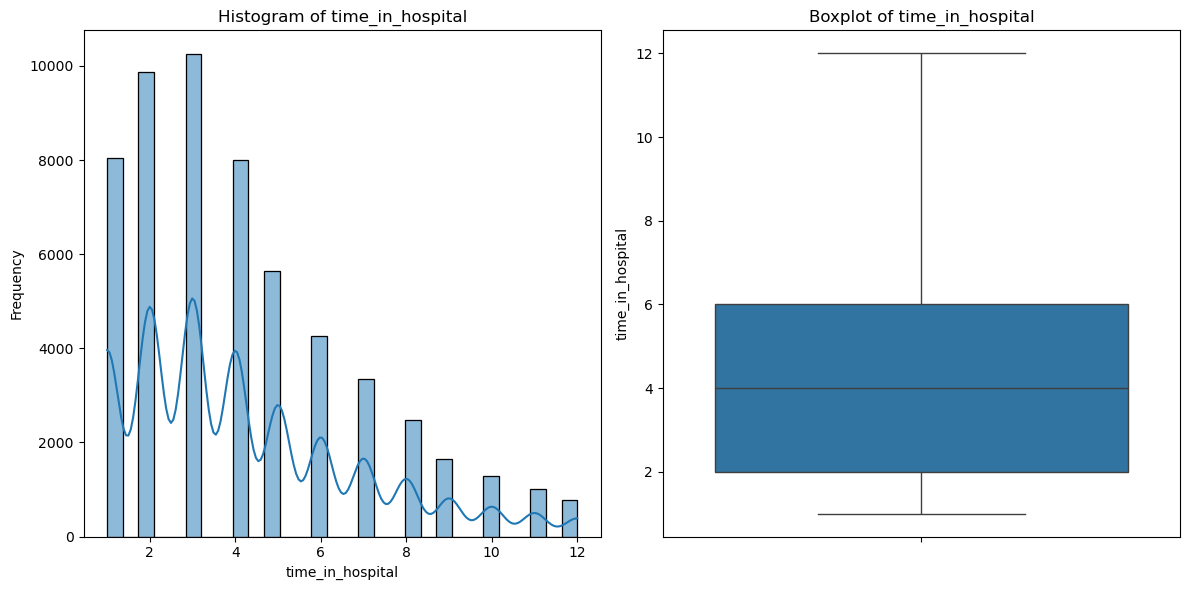

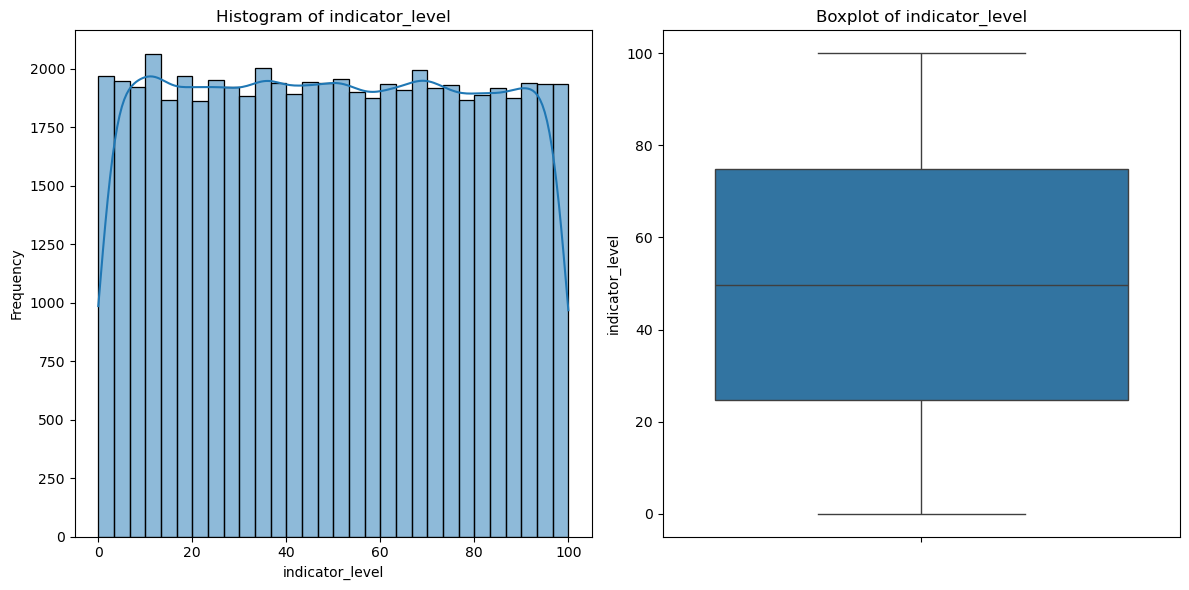

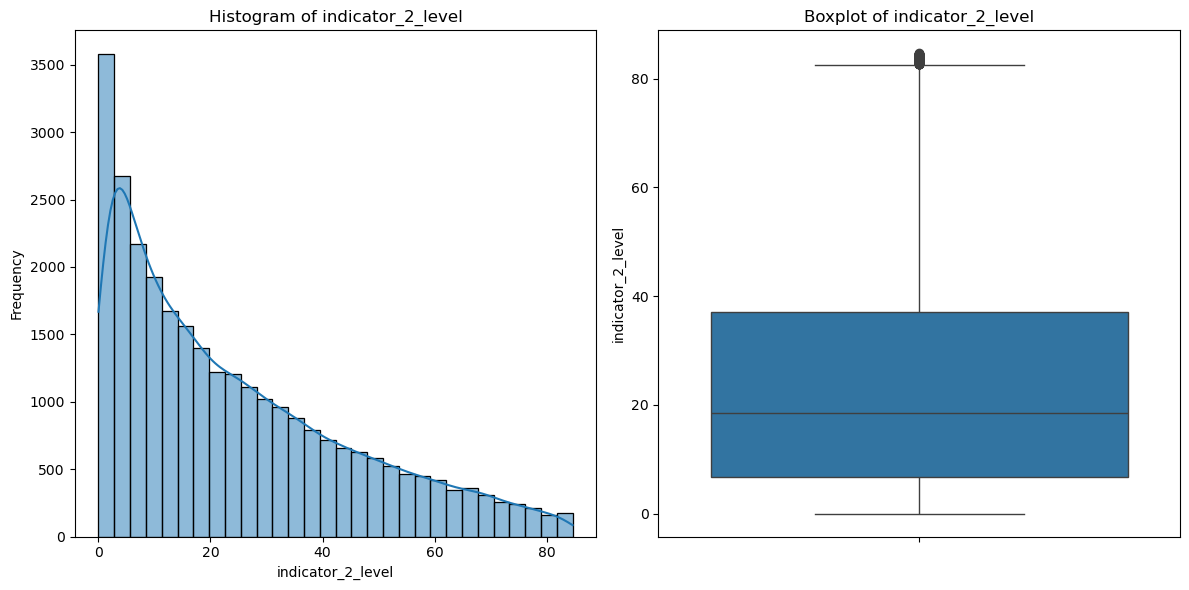

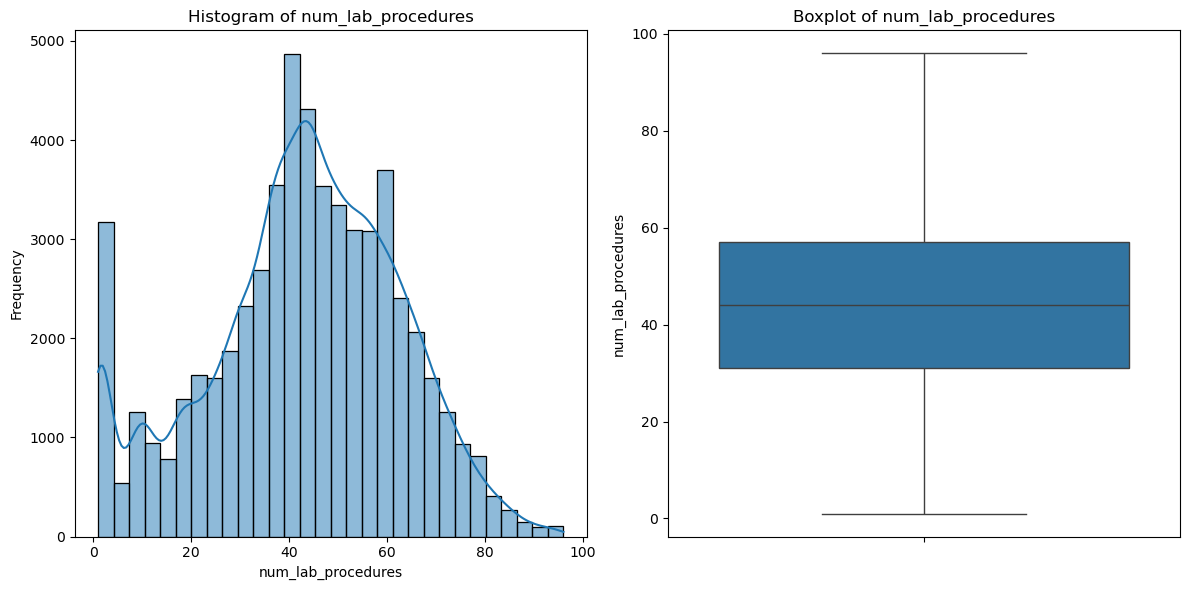

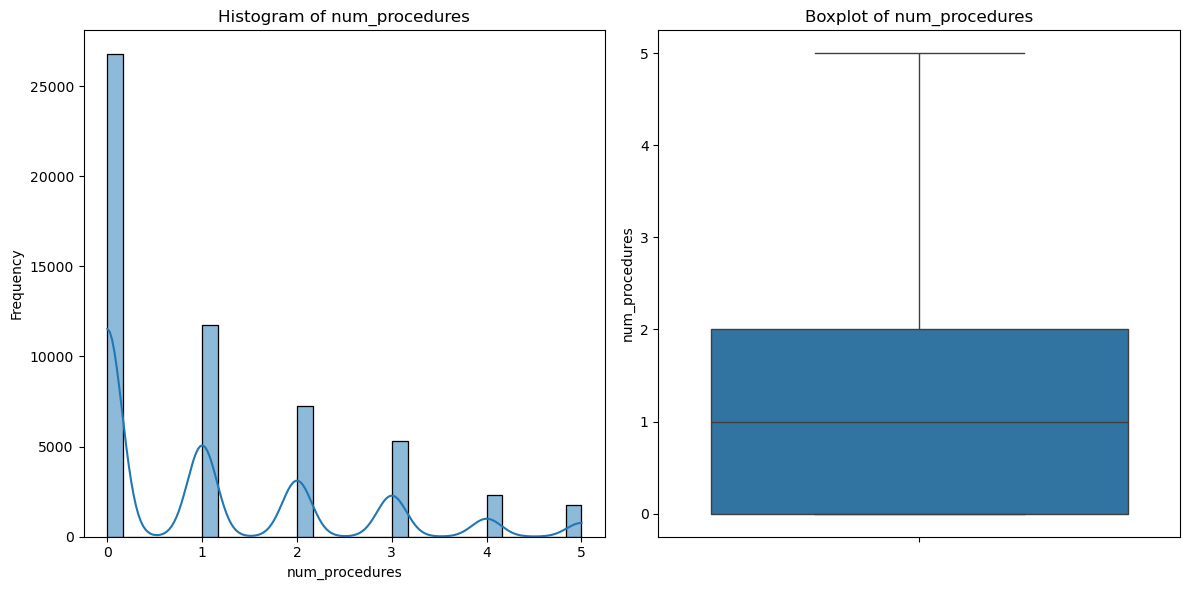

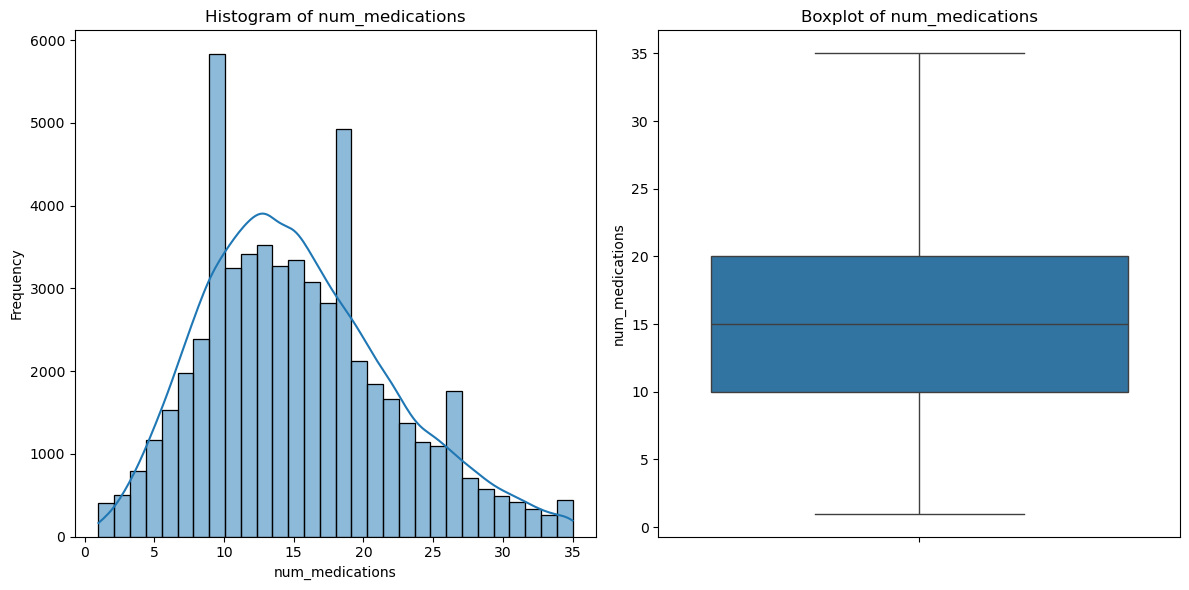

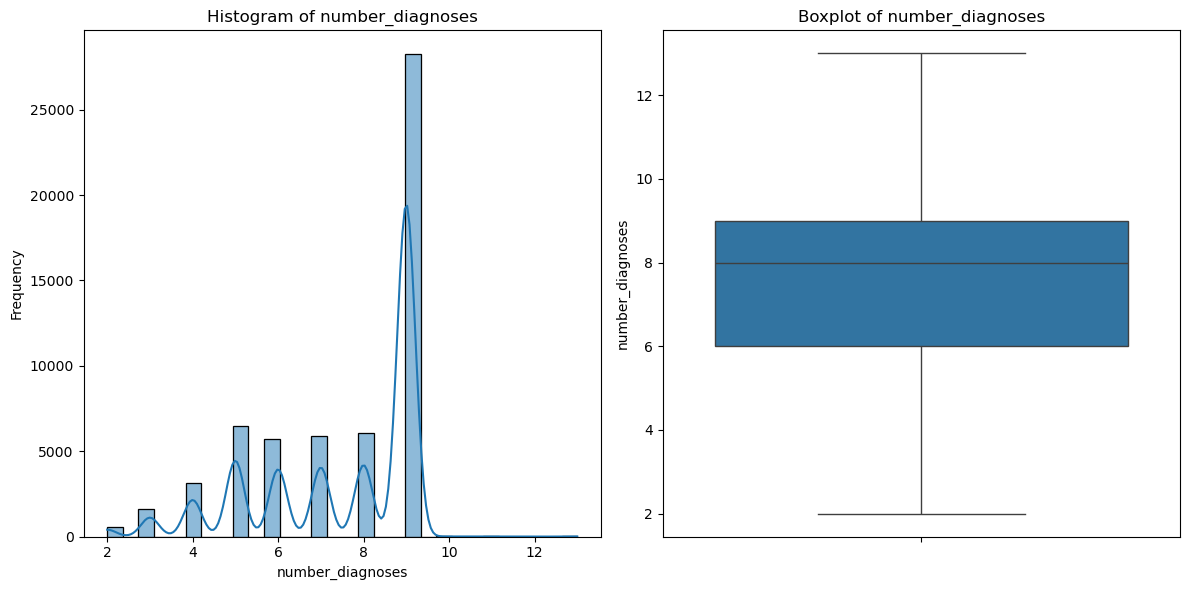

In [18]:
plot_combined_histogram_boxplot(cleaned_data)

In [19]:

# ====================================================
# Imputing Missing Values using KNN Imputation
# ====================================================

imputer = KNNImputer(n_neighbors=5)
train_numeric_imputed = pd.DataFrame(
    imputer.fit_transform(cleaned_data), columns=cleaned_data.columns
)

# Recompute summary statistics after imputation
numeric_summary(train_numeric_imputed)


missing  missing_pct  unique  unique_pct    count  \
time_in_hospital          0          0.0      52    0.089880  57855.0   
indicator_level           0          0.0    9981   17.251750  57855.0   
indicator_2_level         0          0.0   26030   44.991790  57855.0   
num_lab_procedures        0          0.0     145    0.250627  57855.0   
num_procedures            0          0.0      25    0.043211  57855.0   
num_medications           0          0.0     122    0.210872  57855.0   
number_diagnoses          0          0.0      32    0.055311  57855.0   

                         mean        std   min     25%     50%     75%     max  
time_in_hospital     4.206731   2.660913  1.00   2.000   4.000   6.000   12.00  
indicator_level     49.832607  28.902751  0.01  24.800  49.740  74.780  100.00  
indicator_2_level   24.356098  18.243912  0.02   9.016  21.254  36.147   84.63  
num_lab_procedures  42.899386  19.735131  1.00  31.000  44.000  57.000   96.00  
num_procedures       1.112339   1.354263  0.00   0.000   1.000   2.000    5.00  
num_medications     15.453876   6.781057  1.00  10.000  15.000  20.000   35.00  
number_diagnoses     7.437611   1.900195  2.00   6.000   8.000   9.000   13.00

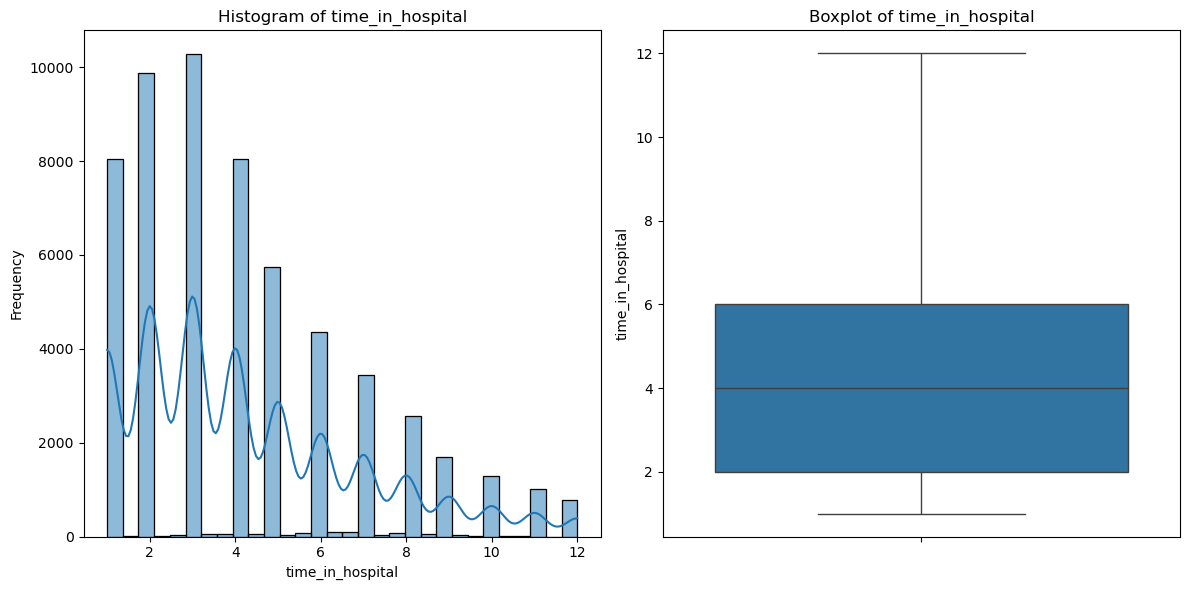

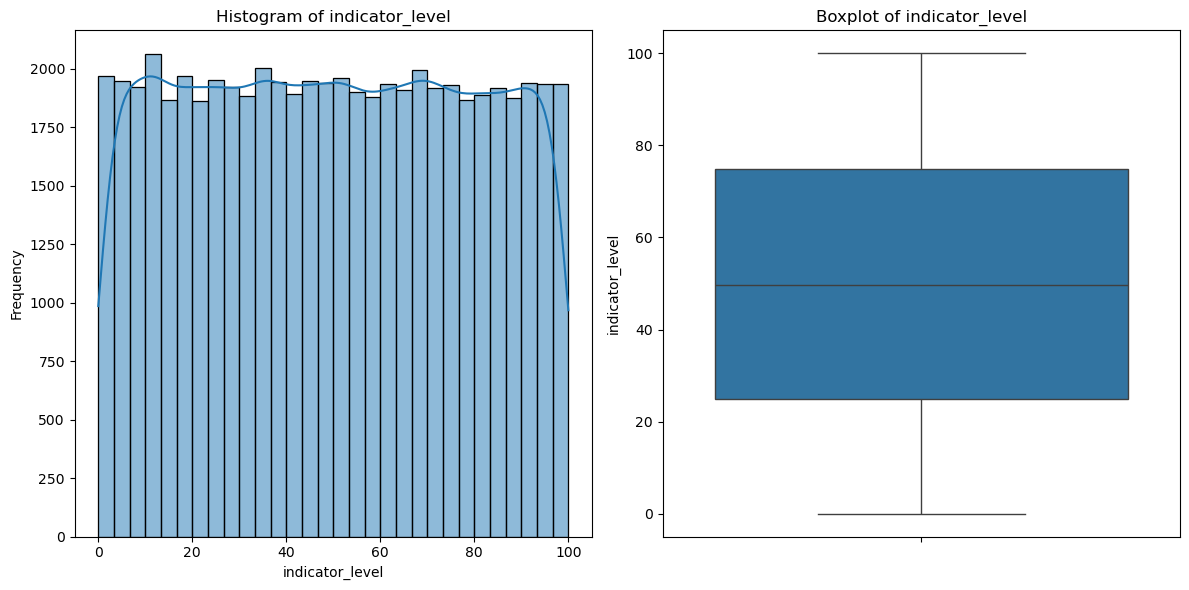

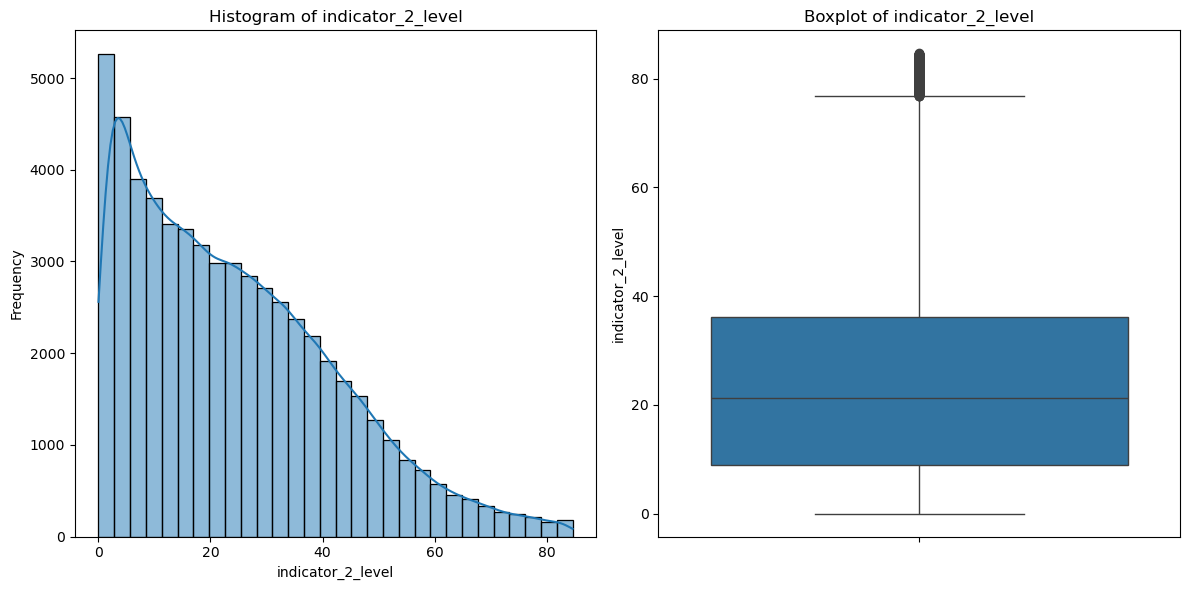

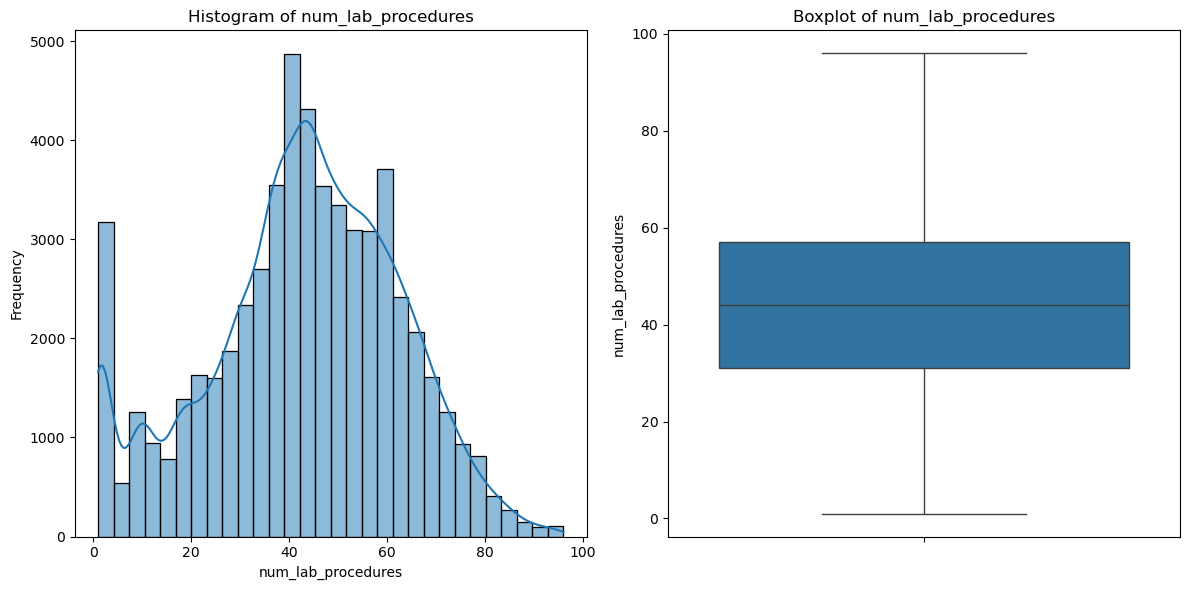

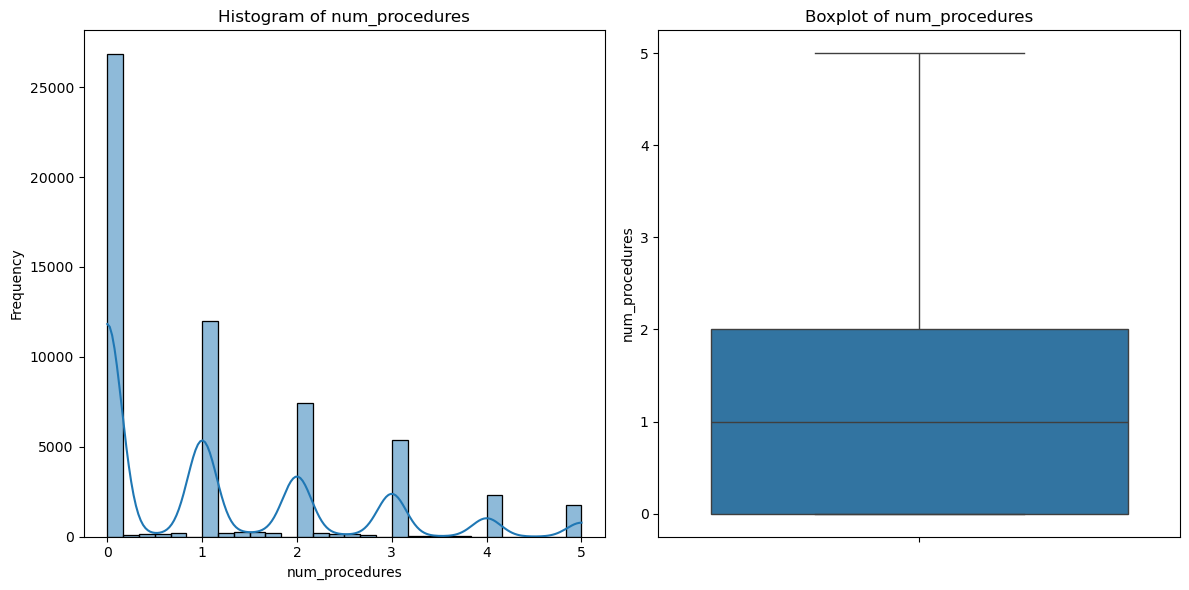

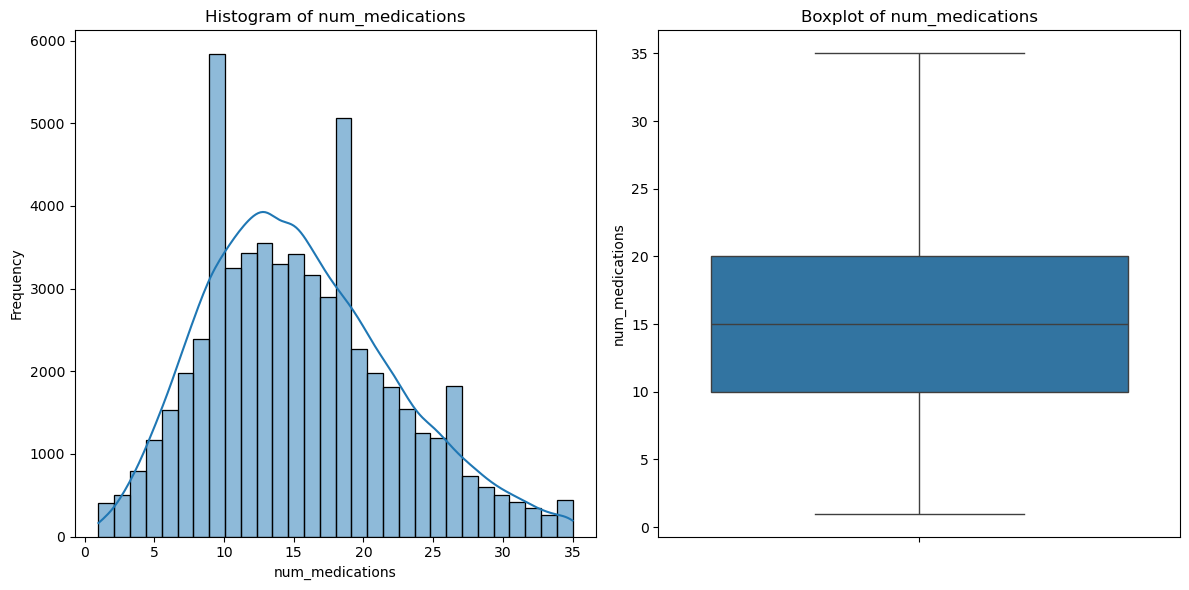

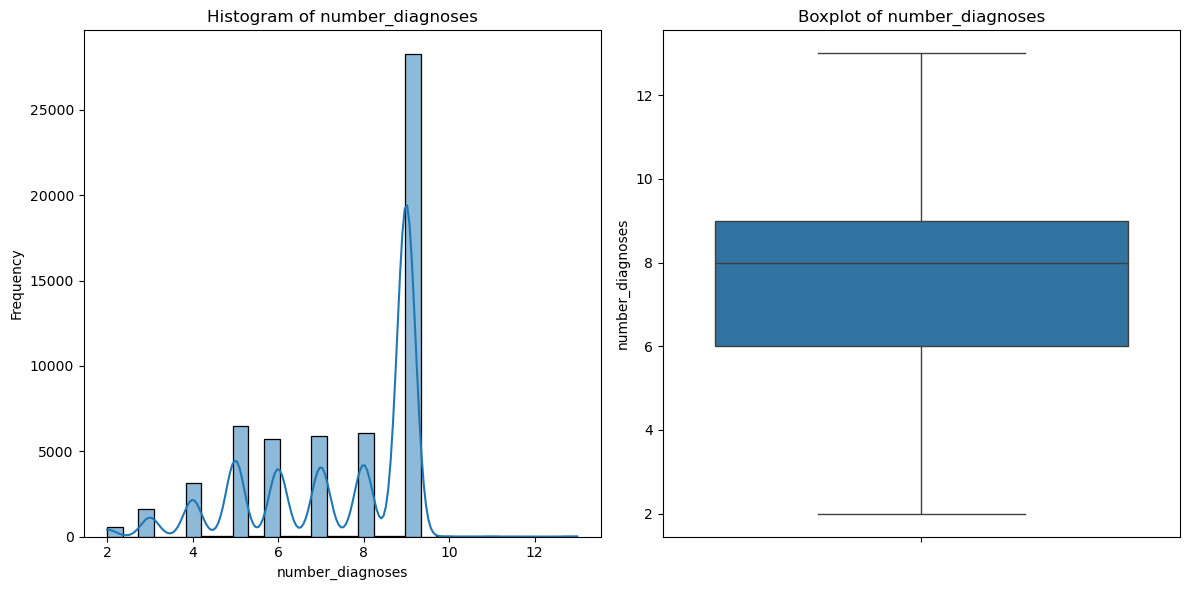

In [20]:
plot_combined_histogram_boxplot(train_numeric_imputed)


In [21]:

# ====================================================
# Handling Skewness Using Box-Cox Transformation
# ====================================================


def compute_skewness(df):
    return df.apply(lambda x: x.skew()).sort_values()


skewness_values = compute_skewness(train_numeric_imputed)
print("Skewness of variables:")
print(skewness_values)

Skewness of variables:
number_diagnoses     -0.910811
num_lab_procedures   -0.266975
indicator_level       0.006874
num_medications       0.468174
indicator_2_level     0.768260
time_in_hospital      0.918595
num_procedures        1.155302
dtype: float64


In [22]:

# ====================================================
# Numeric Transformation(Normalaization) and Skewness Summary
# ====================================================

# Apply Box-Cox transformation (requires positive data, so shift by 1 if necessary)
power_transformer = PowerTransformer(method="yeo-johnson", standardize=False)
transformed_data = power_transformer.fit_transform(train_numeric_imputed)
train_numeric_transformed = pd.DataFrame(
    transformed_data, columns=train_numeric_imputed.columns
)

# Recompute skewness after transformation
transformed_skewness = compute_skewness(train_numeric_transformed)
print("Skewness after transformation:")
print(transformed_skewness)


Skewness after transformation:
number_diagnoses     -0.428217
indicator_level      -0.260245
num_lab_procedures   -0.249790
indicator_2_level    -0.113862
num_medications      -0.023169
time_in_hospital      0.000632
num_procedures        0.193504
dtype: float64


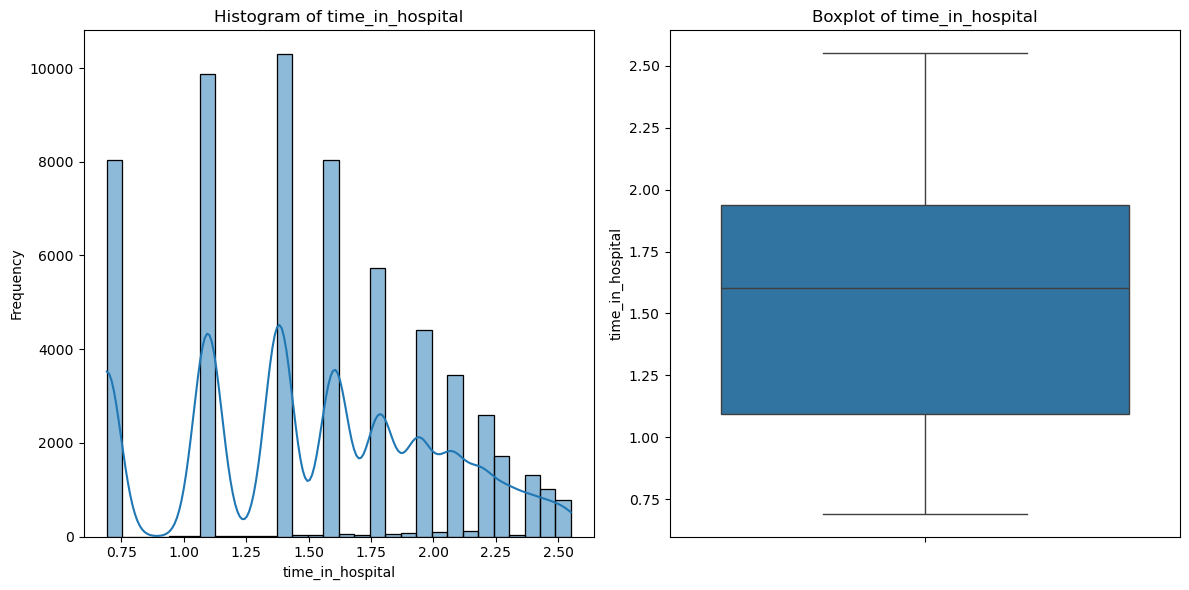

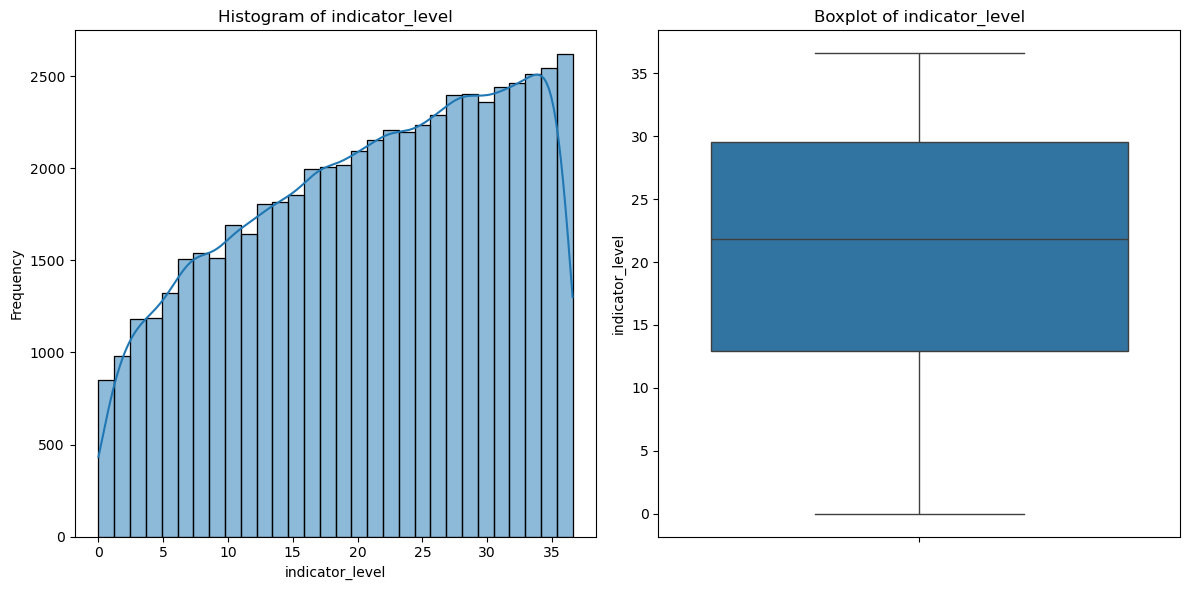

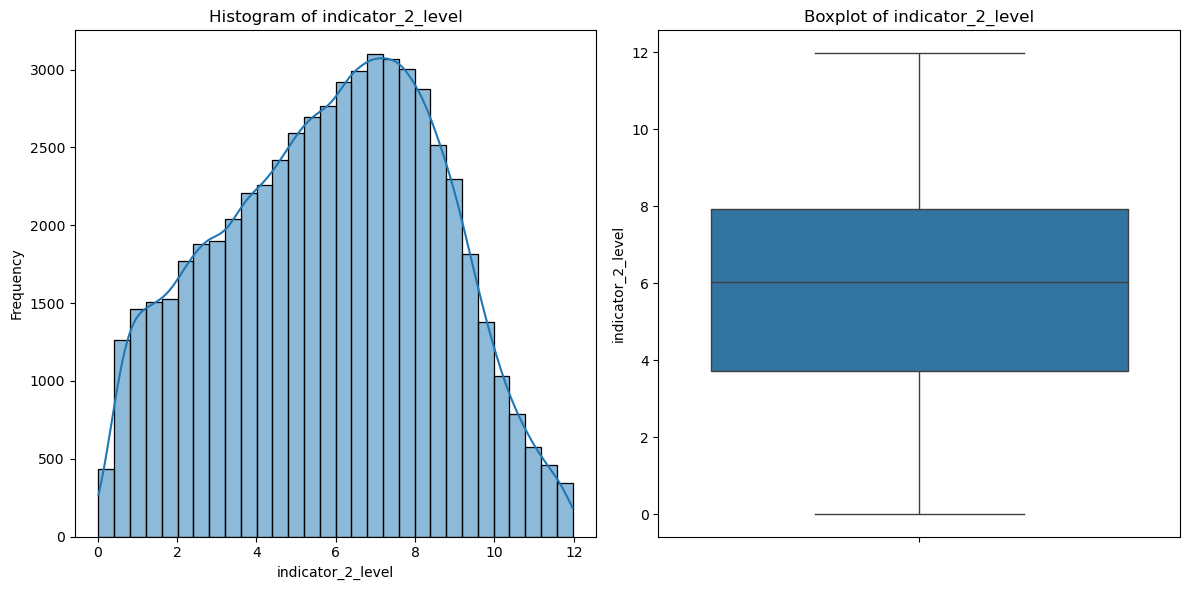

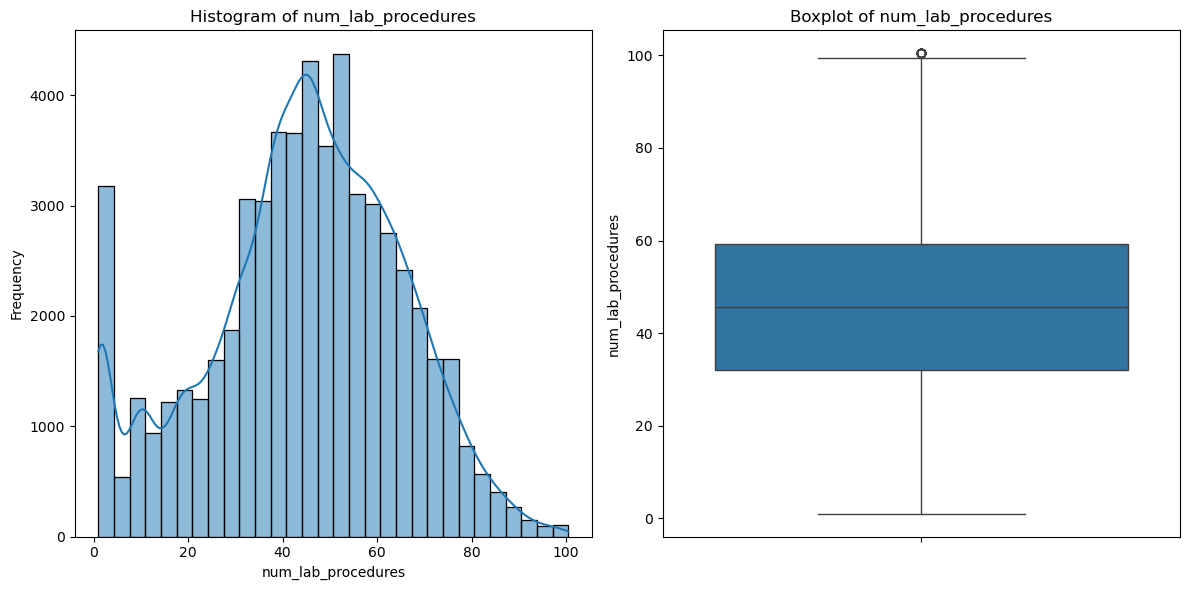

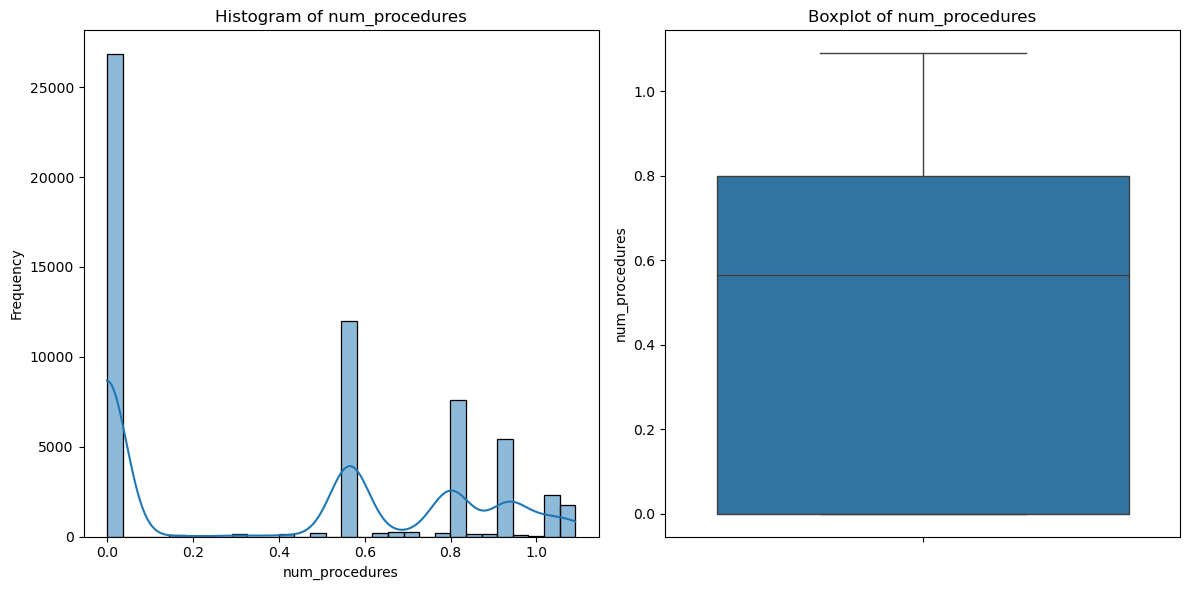

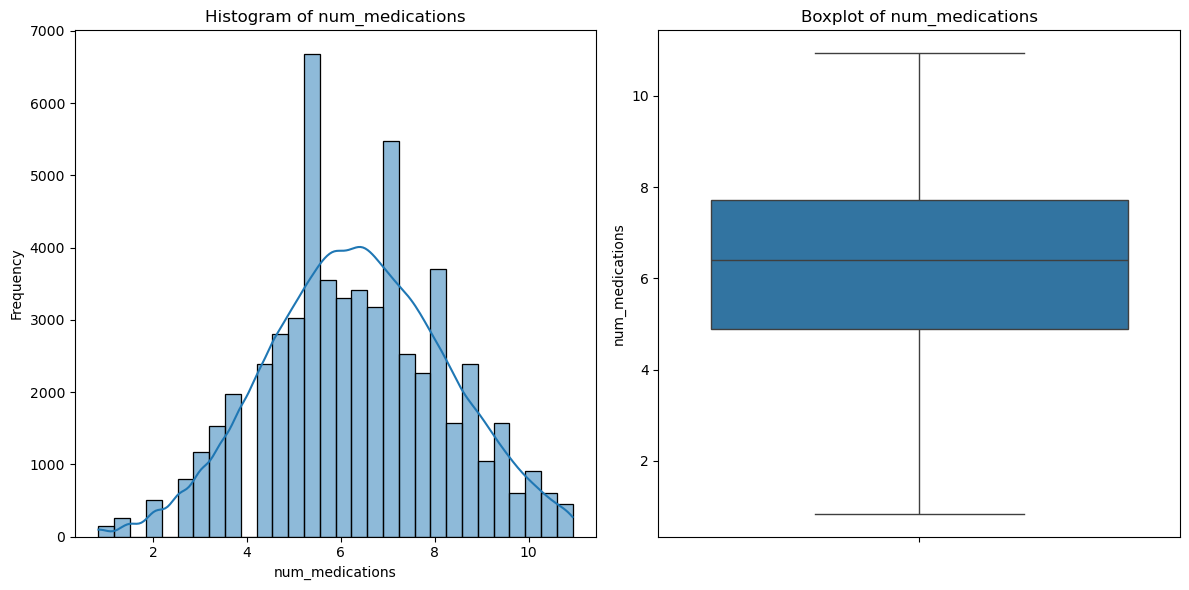

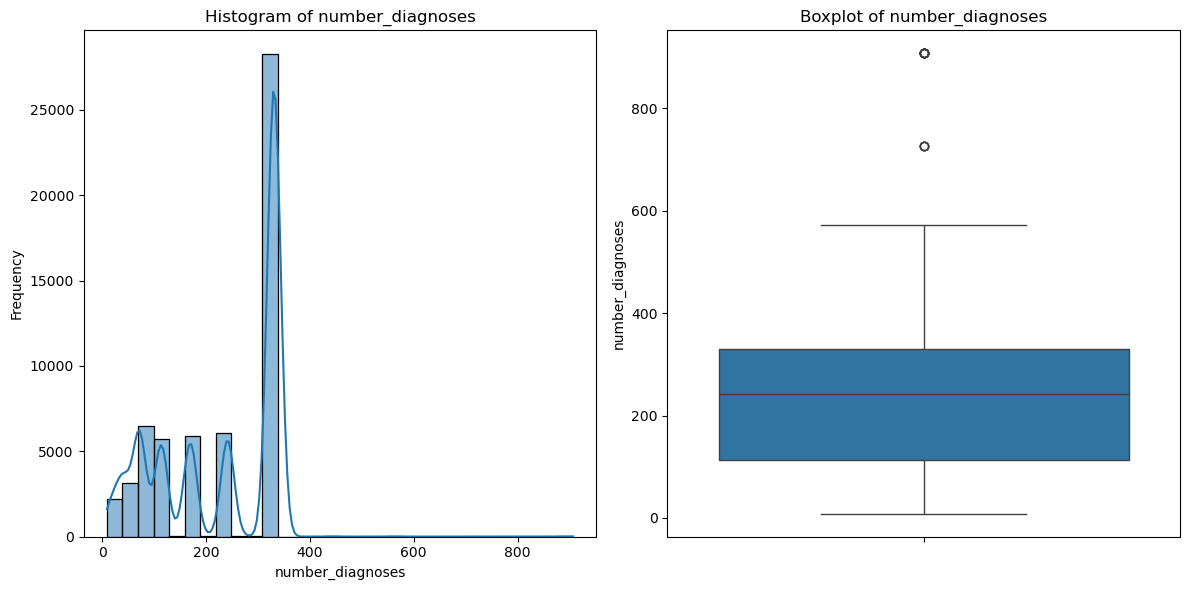

In [23]:

plot_combined_histogram_boxplot(train_numeric_transformed)

In [24]:

# ====================================================
# Numeric Scaling
# ====================================================

scaler = StandardScaler()

# Fit on transformed training data and scale it
train_numeric_scaled = pd.DataFrame(
    scaler.fit_transform(train_numeric_transformed),
    columns=train_numeric_transformed.columns,
)

In [25]:

# ====================================================
# FACTORS
# ====================================================

# ====================================================
# Selecting Factor Data, Computing Summary Statistics
# ====================================================

# Extract Factor Variables
train_factor = train.select_dtypes(include=["object"]).copy()
train_factor.info()
train_factor.describe().T.drop(columns="unique")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57855 entries, 0 to 57854
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      56542 non-null  object
 1   gender                    57850 non-null  object
 2   age                       57854 non-null  object
 3   admission_type            57855 non-null  object
 4   discharge_disposition     57855 non-null  object
 5   admission_source          57855 non-null  object
 6   payer_code                36340 non-null  object
 7   medical_specialty         30045 non-null  object
 8   diagnosis                 57844 non-null  object
 9   max_glu_serum             3119 non-null   object
 10  A1Cresult                 9756 non-null   object
 11  metformin                 57855 non-null  object
 12  repaglinide               57855 non-null  object
 13  nateglinide               57855 non-null  object
 14  chlorpropamide        

count               top   freq
race                      56542         Caucasian  43515
gender                    57850            Female  31029
age                       57854           [70-80)  14694
admission_type            57855                 1  30503
discharge_disposition     57855                 1  36132
admission_source          57855                 7  32720
payer_code                36340          medicare  18985
medical_specialty         30045  InternalMedicine   8460
diagnosis                 57844               428   3859
max_glu_serum              3119              Norm   1546
A1Cresult                  9756                >8   4701
metformin                 57855                No  46445
repaglinide               57855                No  56962
nateglinide               57855                No  57432
chlorpropamide            57855                No  57818
glimepiride               57855                No  54814
acetohexamide             57855                No  57854
glipizide                 57855                No  50469
glyburide                 57855                No  52063
tolbutamide               57855                No  57840
pioglitazone              57855                No  53531
rosiglitazone             57855                No  54166
acarbose                  57855                No  57687
miglitol                  57855                No  57834
troglitazone              57855                No  57853
tolazamide                57855                No  57836
examide                   57855                No  57855
citoglipton               57855                No  57855
insulin                   57855                No  26287
glyburide-metformin       57855                No  57432
glipizide-metformin       57855                No  57848
glimepiride-pioglitazone  57855                No  57855
metformin-rosiglitazone   57855                No  57853
metformin-pioglitazone    57855                No  57854
diabetesMed               57855               Yes  44970
readmitted                57855                 0  30632

In [26]:

# Function to compute summary statistics
def factor_summary_2(df):
    summary = pd.DataFrame()
    summary["missing"] = df.isnull().sum()
    summary["missing_pct"] = (summary["missing"] / len(df)) * 100
    summary["unique"] = df.nunique()
    summary["unique_pct"] = (summary["unique"] / len(df)) * 100
    descriptive_stats = df.describe().T.drop(columns="unique")
    summary = pd.concat([summary, descriptive_stats], axis=1)
    return summary


# Compute Summary for Factor Data
def factor_summary(df):
    """
    Computes a summary of factor data for each column in the DataFrame.
    """
    summary = []
    for col in df.columns:
        col_data = df[col]
        value_counts = col_data.value_counts()
        unique_count = len(value_counts)
        total_count = len(col_data)
        missing_count = col_data.isnull().sum()
        unique_count = col_data.nunique()

        # Calculate modes and their counts
        most_common = value_counts.idxmax() if not value_counts.empty else np.nan
        most_common_count = value_counts.max() if not value_counts.empty else np.nan
        second_most_common = value_counts.index[1] if unique_count > 1 else np.nan
        second_most_common_count = value_counts.iloc[1] if unique_count > 1 else np.nan
        least_common = value_counts.idxmin() if not value_counts.empty else np.nan
        least_common_count = value_counts.min() if not value_counts.empty else np.nan

        summary.append(
            {
                "variable": col,
                "n": len(col_data),
                "missing": col_data.isnull().sum(),
                "missing_percentage": (missing_count / total_count * 100)
                if total_count > 0
                else np.nan,
                "unique": col_data.nunique(),
                "unique_percentage": (unique_count / total_count * 100)
                if total_count > 0
                else np.nan,
                "most_common": most_common,
                "most_common_count": most_common_count,
                "2nd_most_common": second_most_common,
                "2nd_most_common_count": second_most_common_count,
                "least_common": least_common,
                "least_common_count": least_common_count,
            }
        )
    return pd.DataFrame(summary)


factor_summary(train_factor)

variable      n  missing  missing_percentage  unique  \
0                       race  57855     1313            2.269467       5   
1                     gender  57855        5            0.008642       3   
2                        age  57855        1            0.001728      10   
3             admission_type  57855        0            0.000000       8   
4      discharge_disposition  57855        0            0.000000      22   
5           admission_source  57855        0            0.000000      17   
6                 payer_code  57855    21515           37.187797       3   
7          medical_specialty  57855    27810           48.068447      69   
8                  diagnosis  57855       11            0.019013     667   
9              max_glu_serum  57855    54736           94.608936       3   
10                 A1Cresult  57855    48099           83.137153       3   
11                 metformin  57855        0            0.000000       4   
12               repaglinide  57855        0            0.000000       4   
13               nateglinide  57855        0            0.000000       4   
14            chlorpropamide  57855        0            0.000000       3   
15               glimepiride  57855        0            0.000000       4   
16             acetohexamide  57855        0            0.000000       2   
17                 glipizide  57855        0            0.000000       4   
18                 glyburide  57855        0            0.000000       4   
19               tolbutamide  57855        0            0.000000       2   
20              pioglitazone  57855        0            0.000000       4   
21             rosiglitazone  57855        0            0.000000       4   
22                  acarbose  57855        0            0.000000       4   
23                  miglitol  57855        0            0.000000       4   
24              troglitazone  57855        0            0.000000       2   
25                tolazamide  57855        0            0.000000       2   
26                   examide  57855        0            0.000000       1   
27               citoglipton  57855        0            0.000000       1   
28                   insulin  57855        0            0.000000       4   
29       glyburide-metformin  57855        0            0.000000       4   
30       glipizide-metformin  57855        0            0.000000       2   
31  glimepiride-pioglitazone  57855        0            0.000000       1   
32   metformin-rosiglitazone  57855        0            0.000000       2   
33    metformin-pioglitazone  57855        0            0.000000       2   
34               diabetesMed  57855        0            0.000000       2   
35                readmitted  57855        0            0.000000       2   

    unique_percentage       most_common  most_common_count   2nd_most_common  \
0            0.008642         Caucasian              43515   AfricanAmerican   
1            0.005185            Female              31029              Male   
2            0.017285           [70-80)              14694           [60-70)   
3            0.013828                 1              30503                 3   
4            0.038026                 1              36132                 3   
5            0.029384                 7              32720                 1   
6            0.005185          medicare              18985         insurance   
7            0.119264  InternalMedicine               8460  Emergency/Trauma   
8            1.152882               428               3859               414   
9            0.005185              Norm               1546              >200   
10           0.005185                >8               4701              Norm   
11           0.006914                No              46445            Steady   
12           0.006914                No              56962            Steady   
13           0.006914                No              57432            Steady   
14     

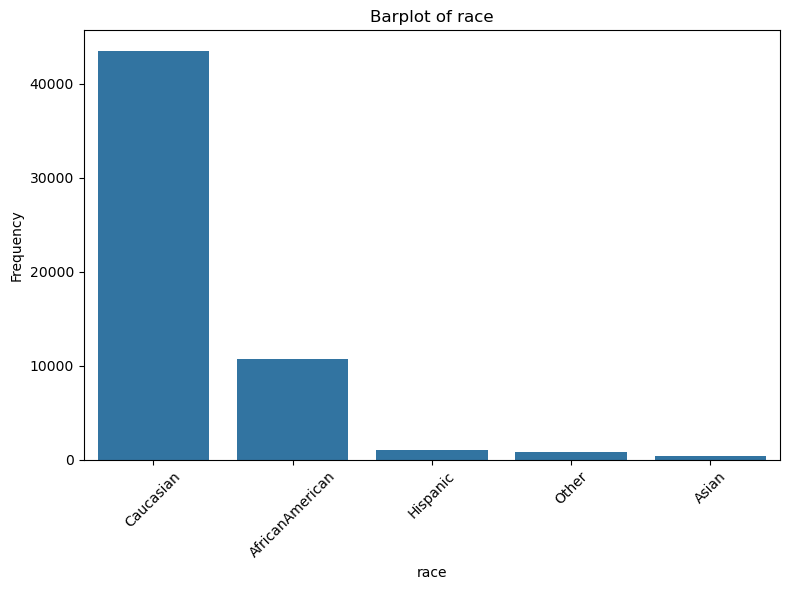

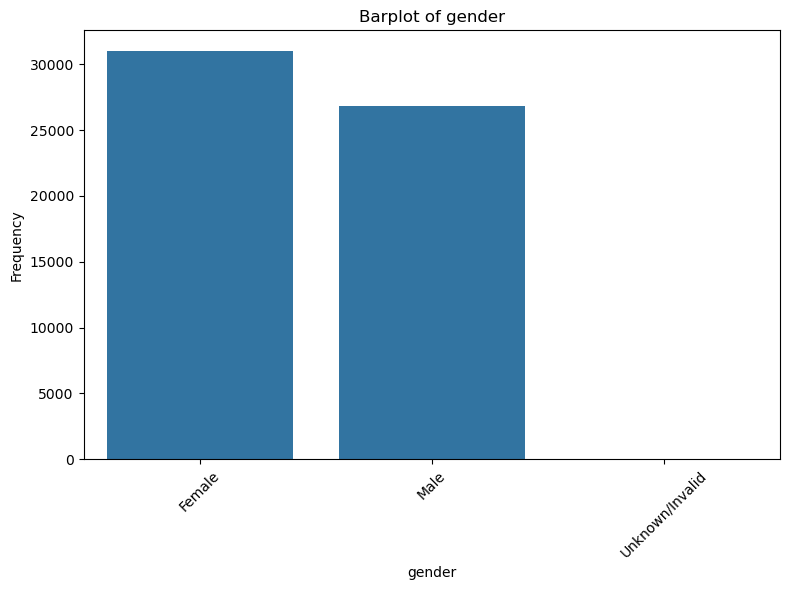

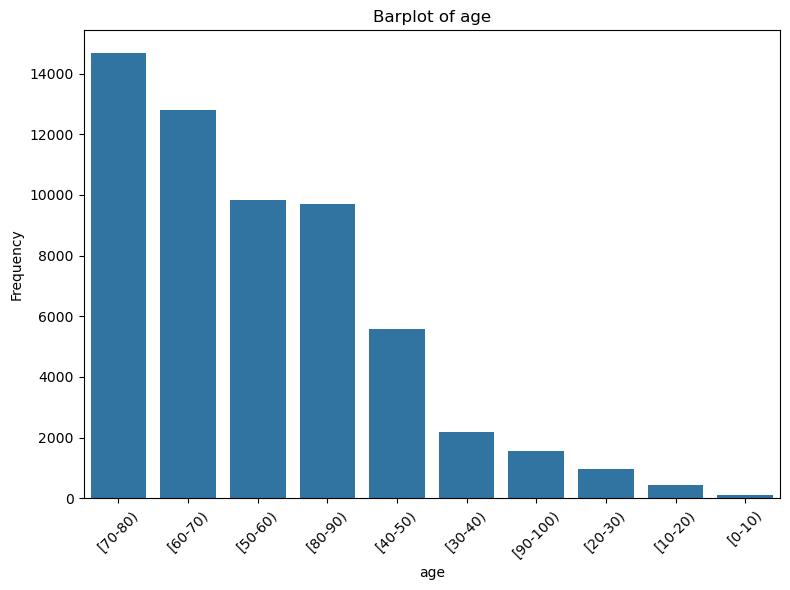

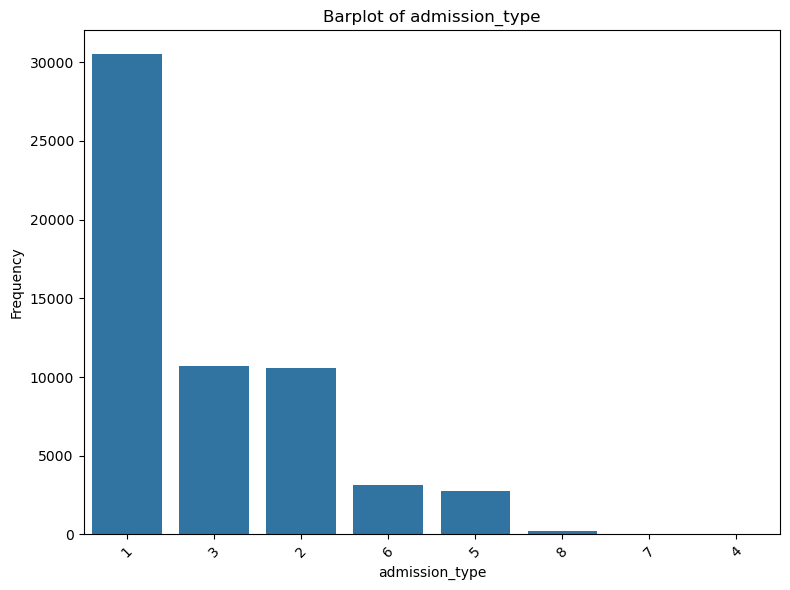

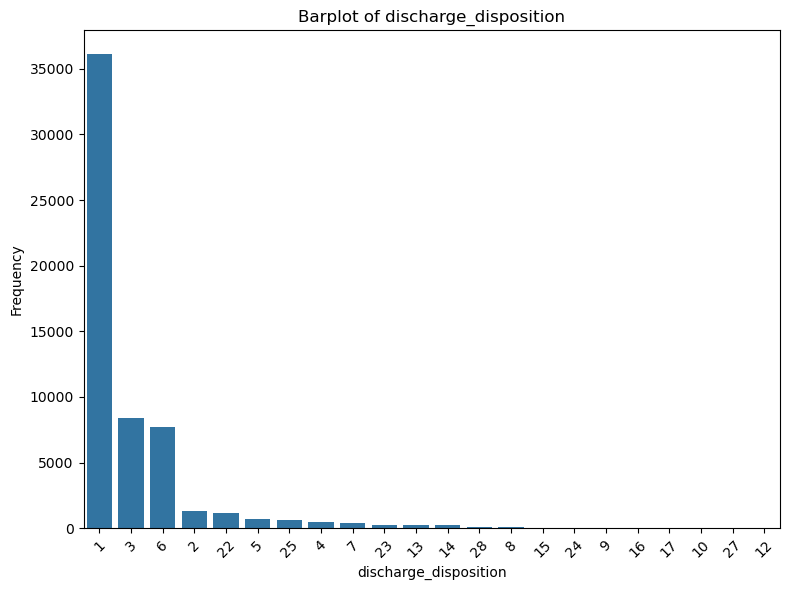

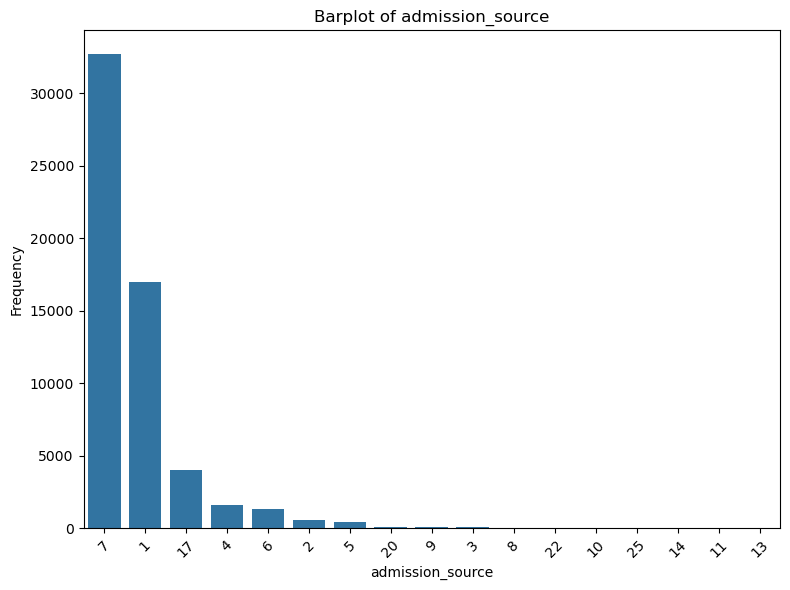

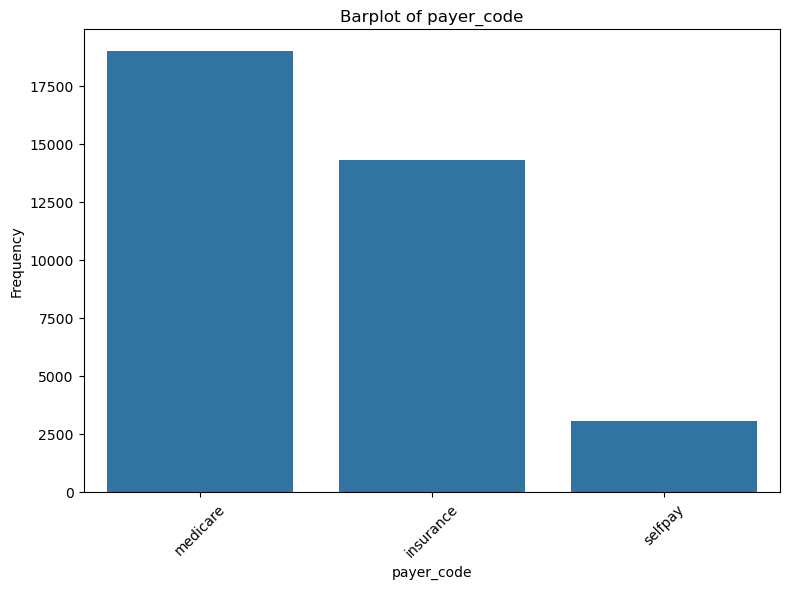

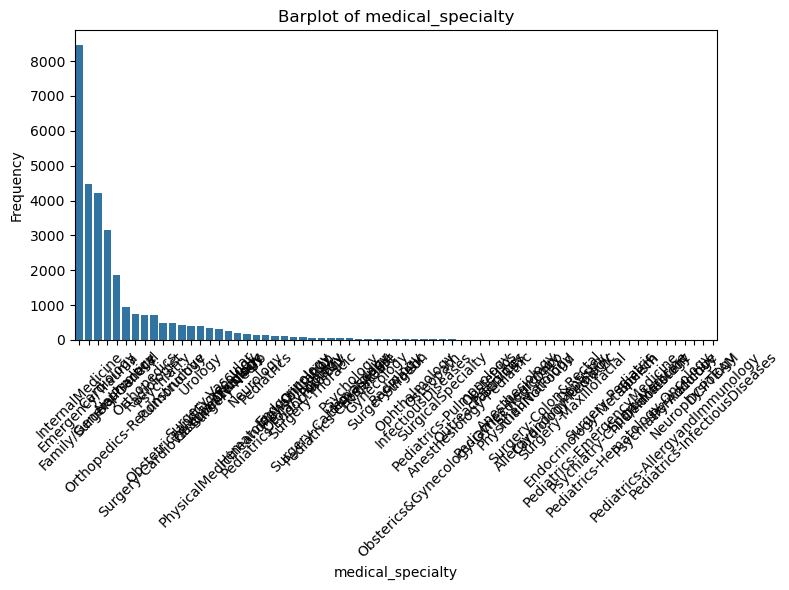

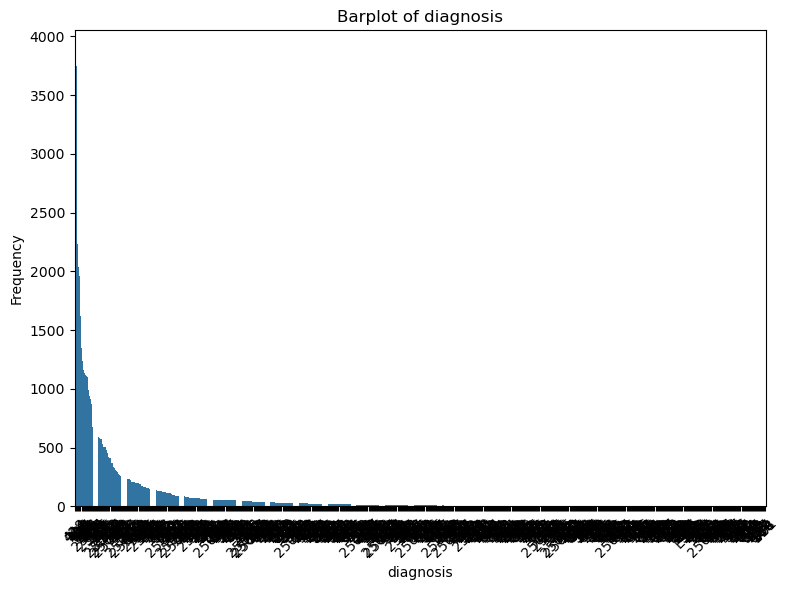

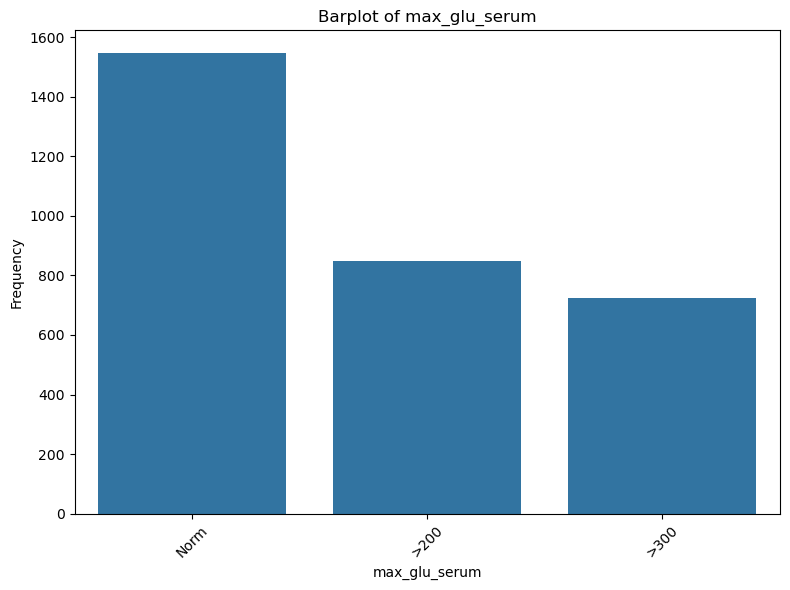

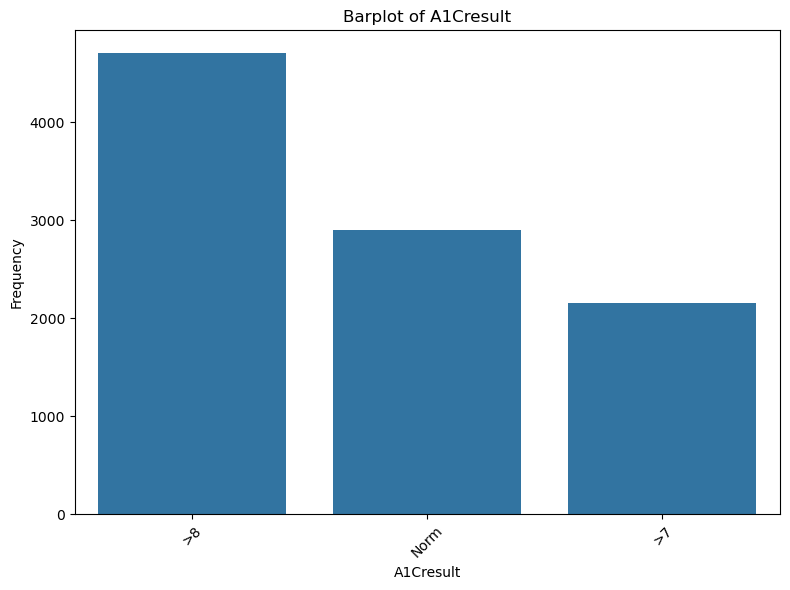

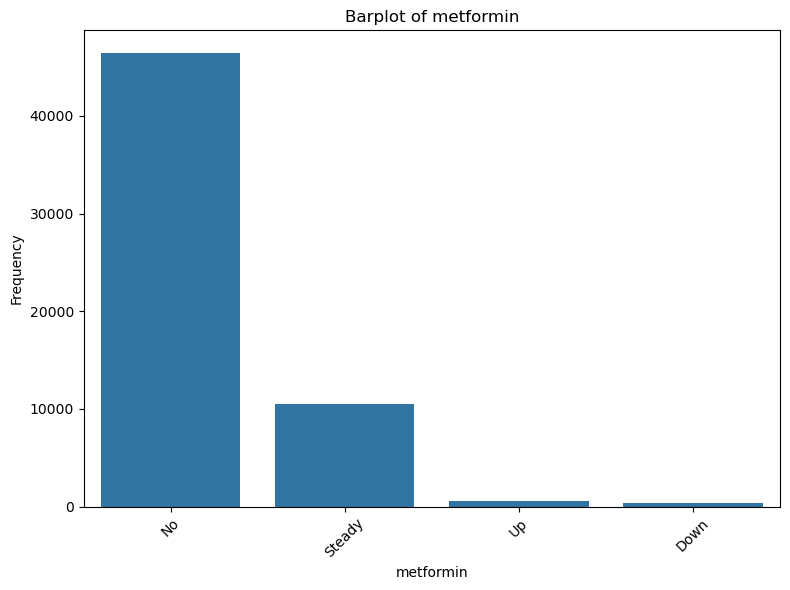

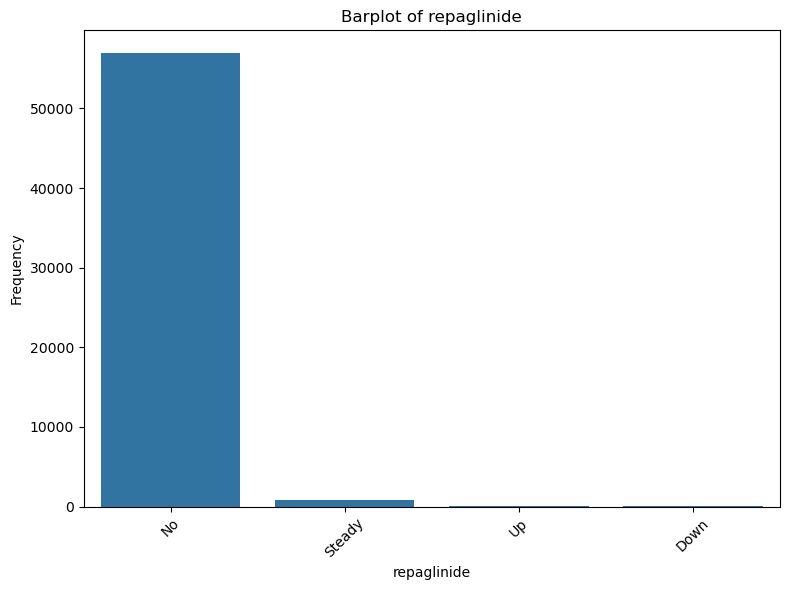

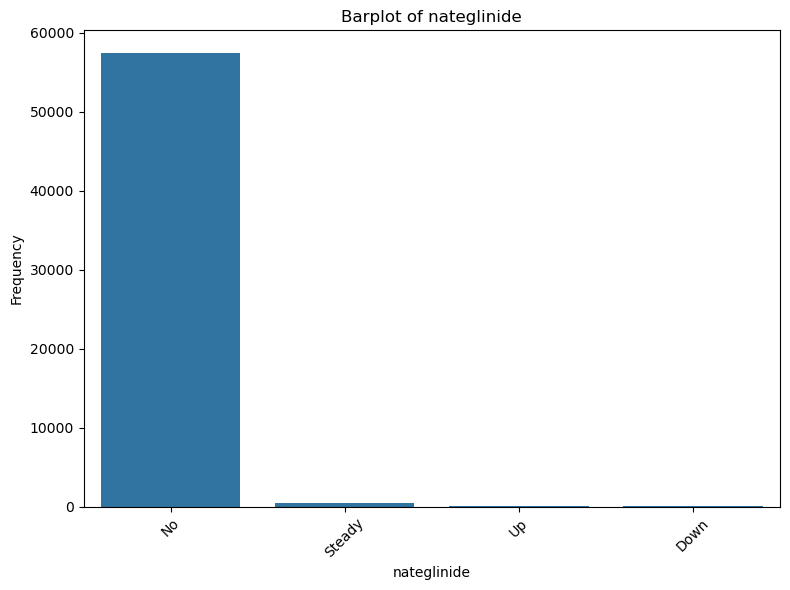

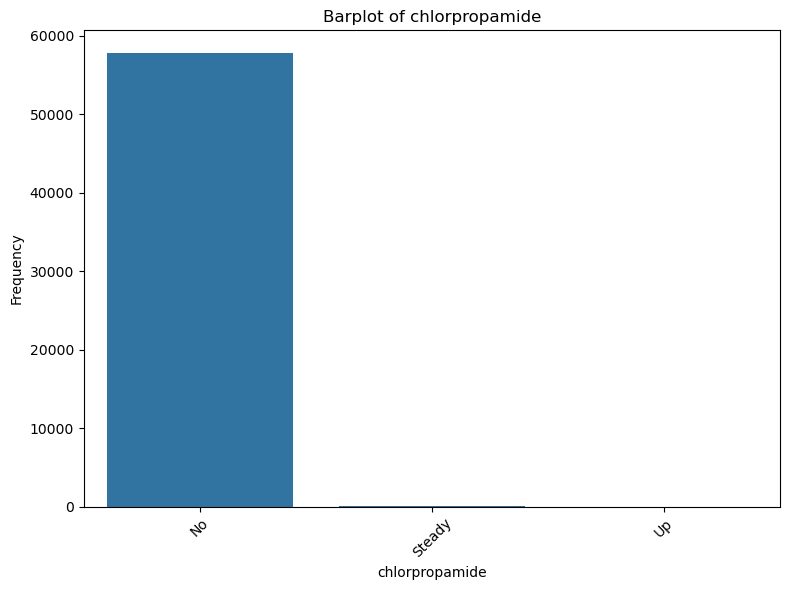

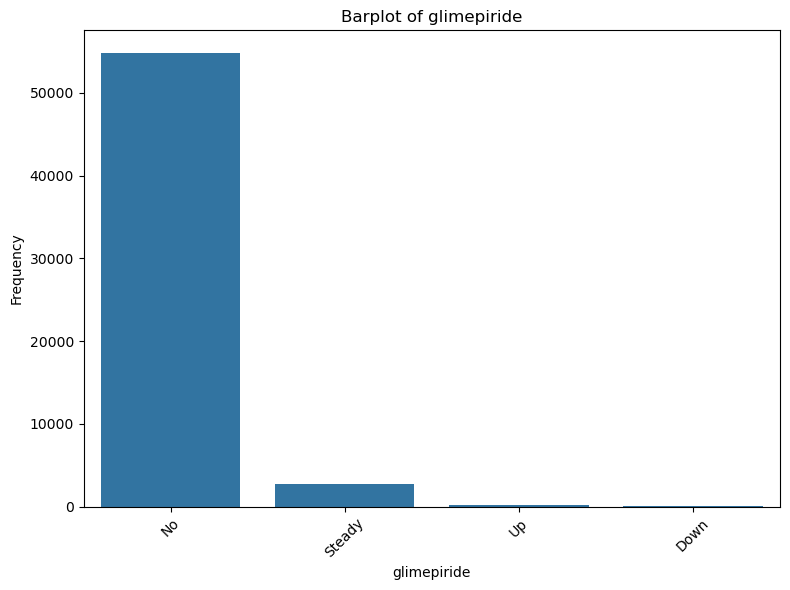

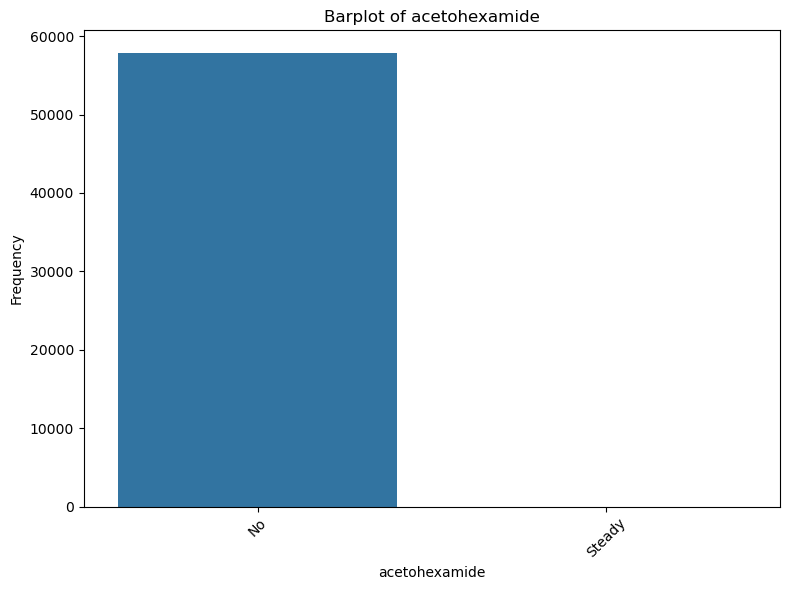

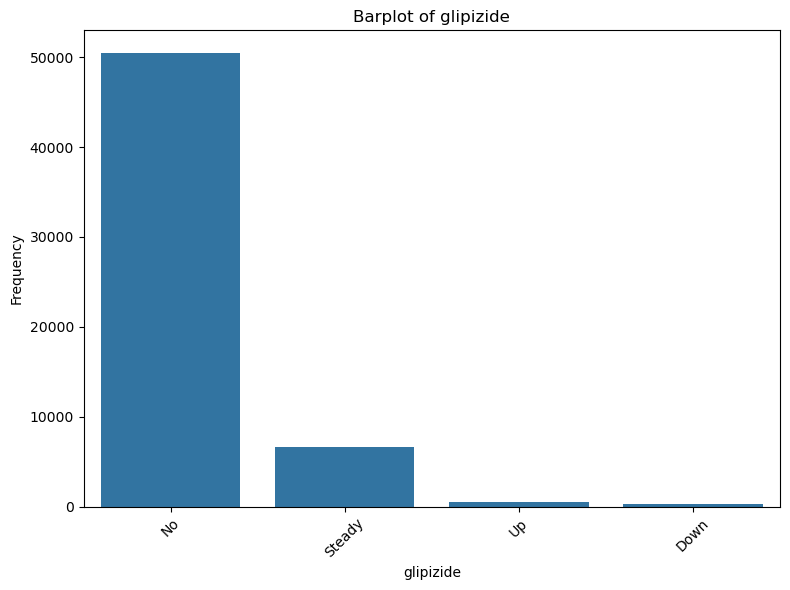

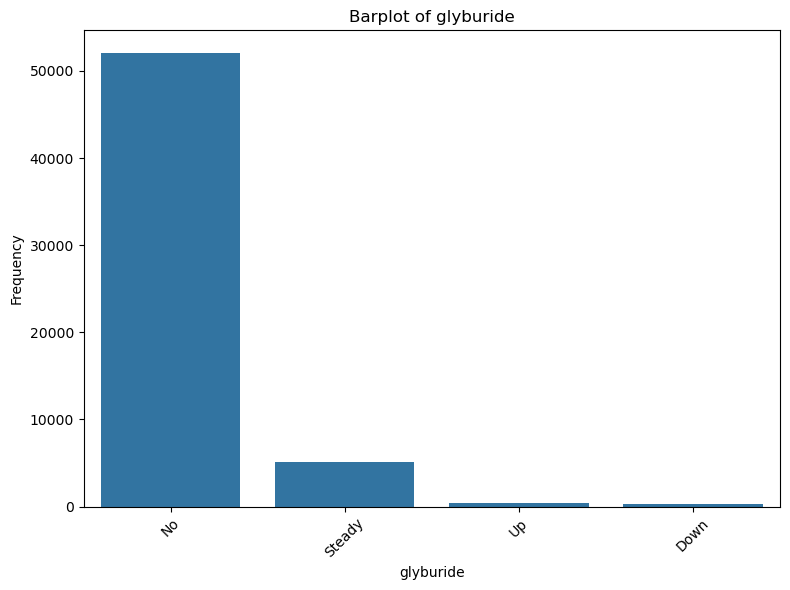

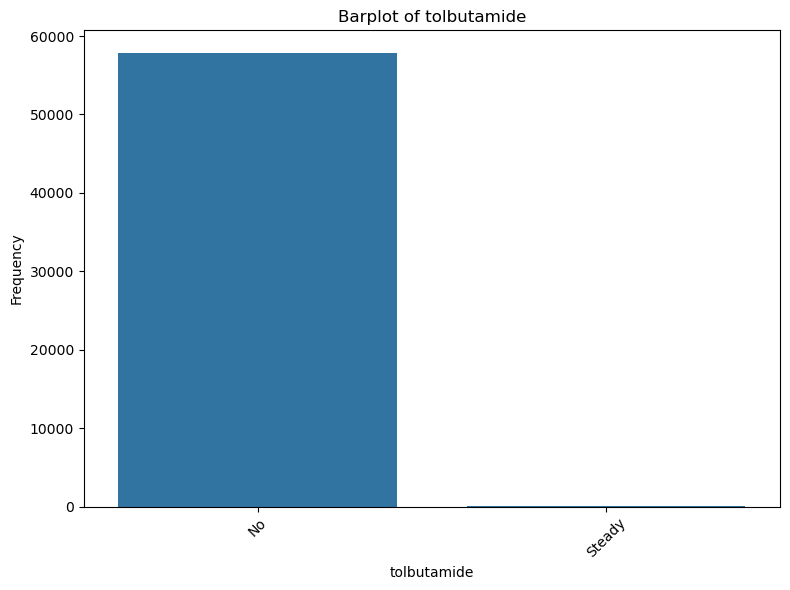

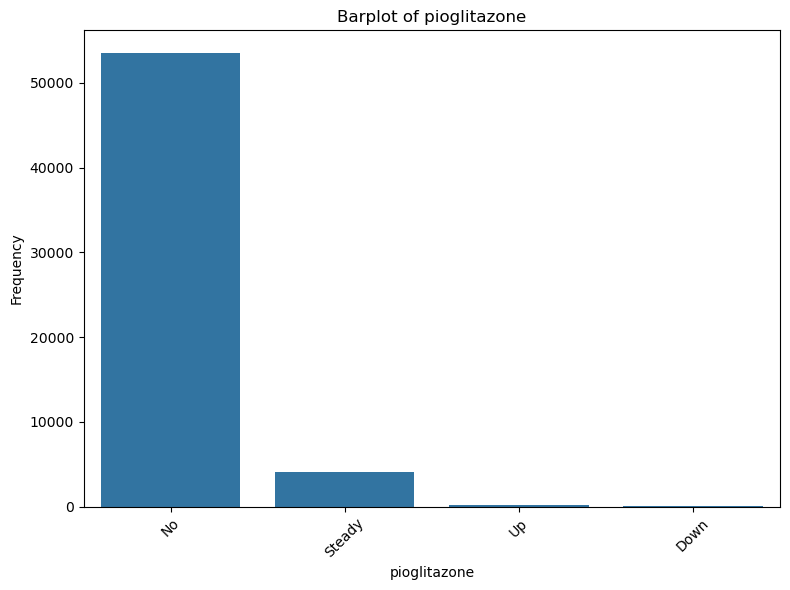

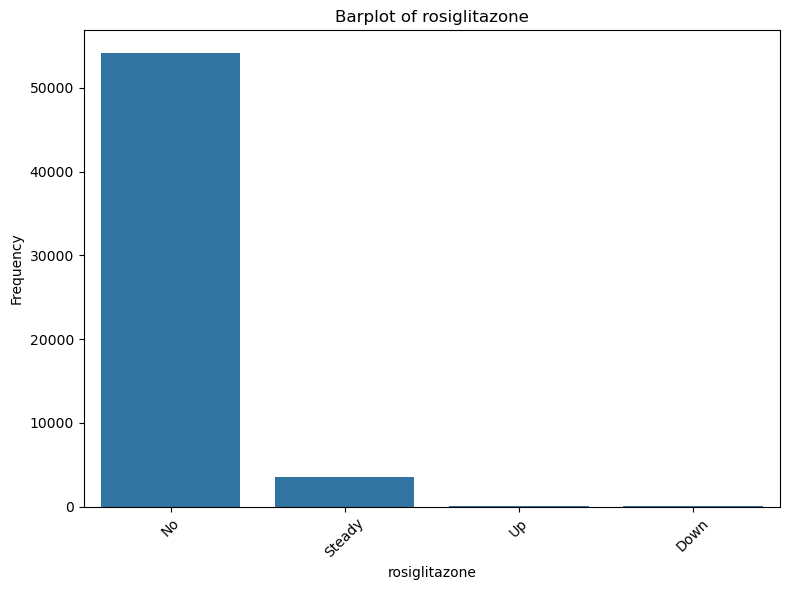

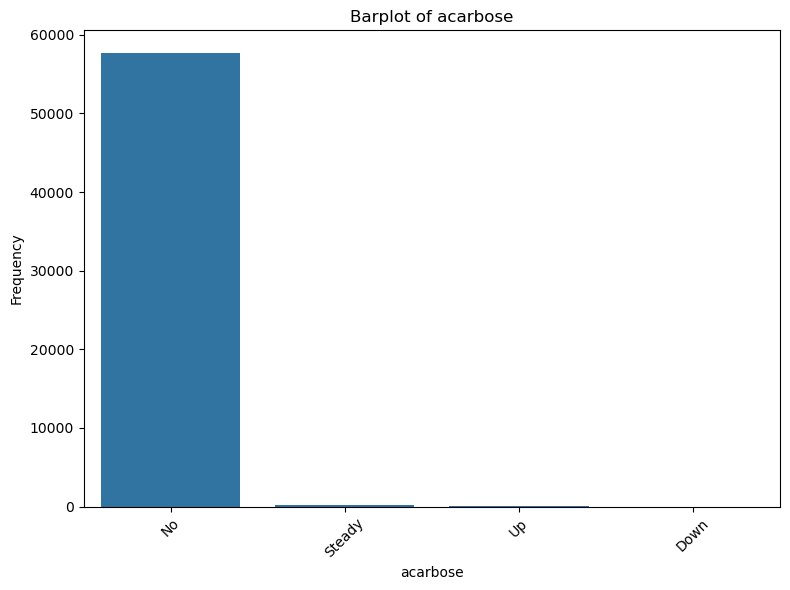

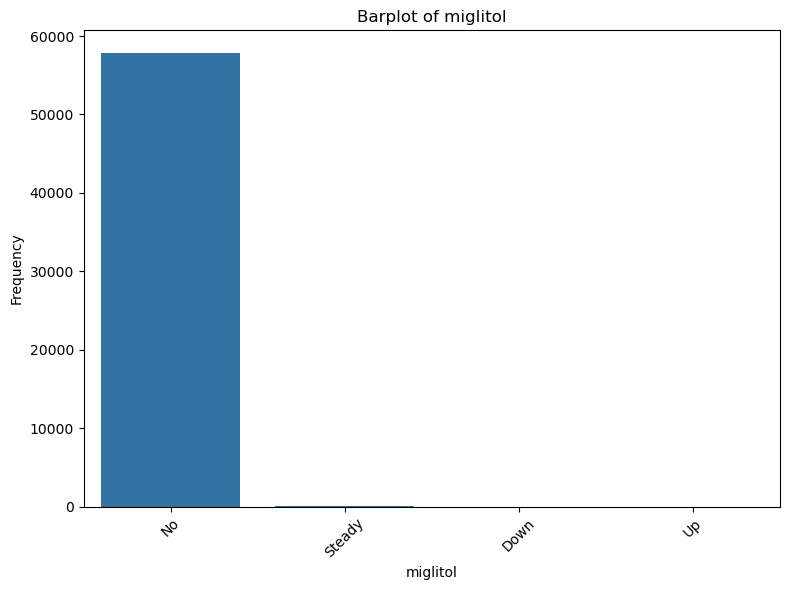

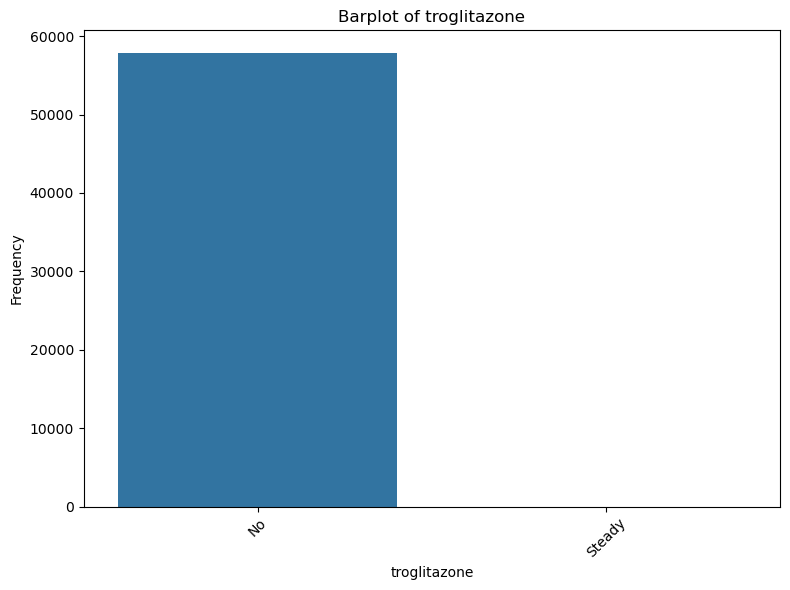

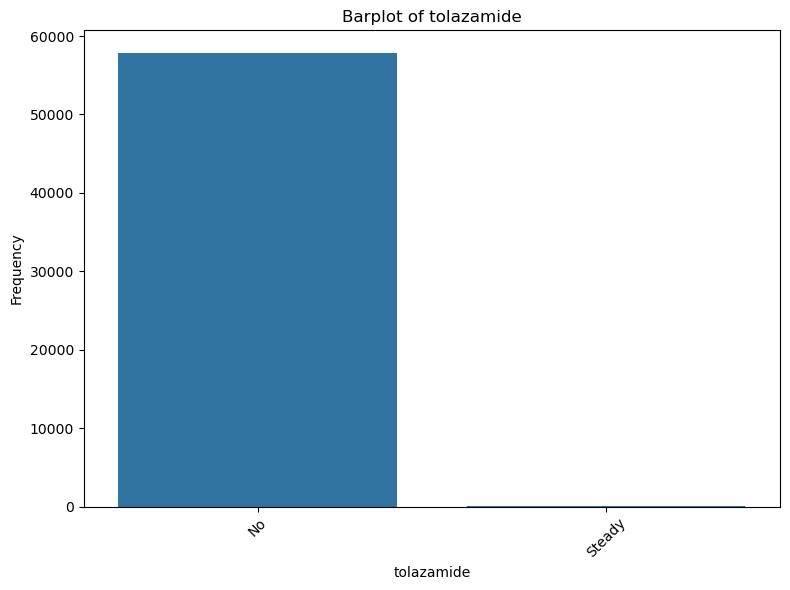

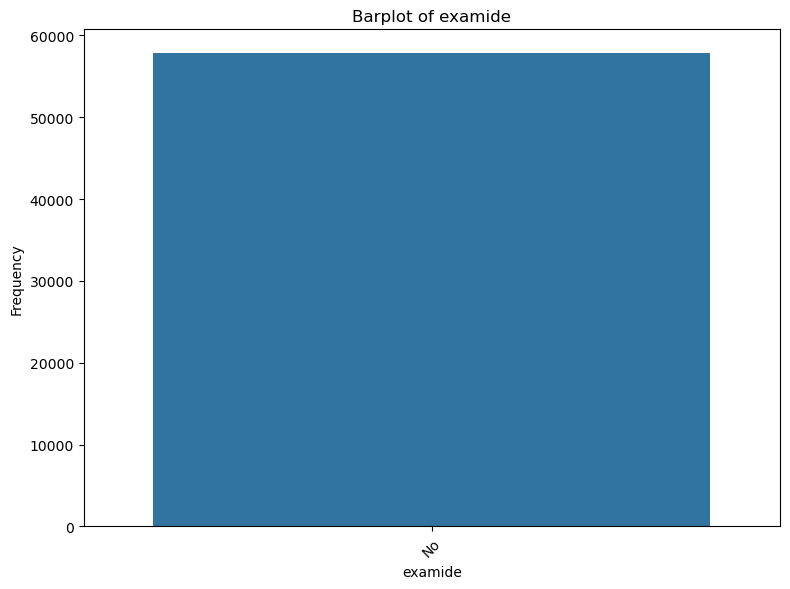

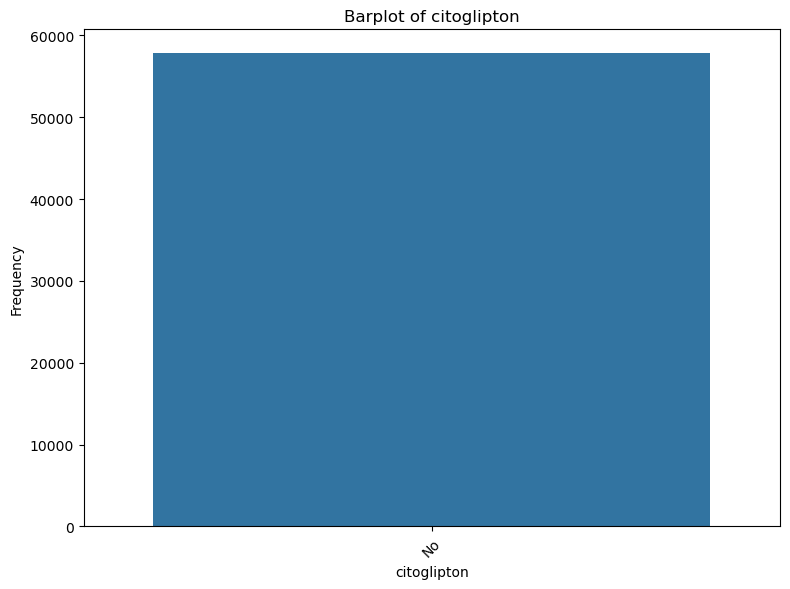

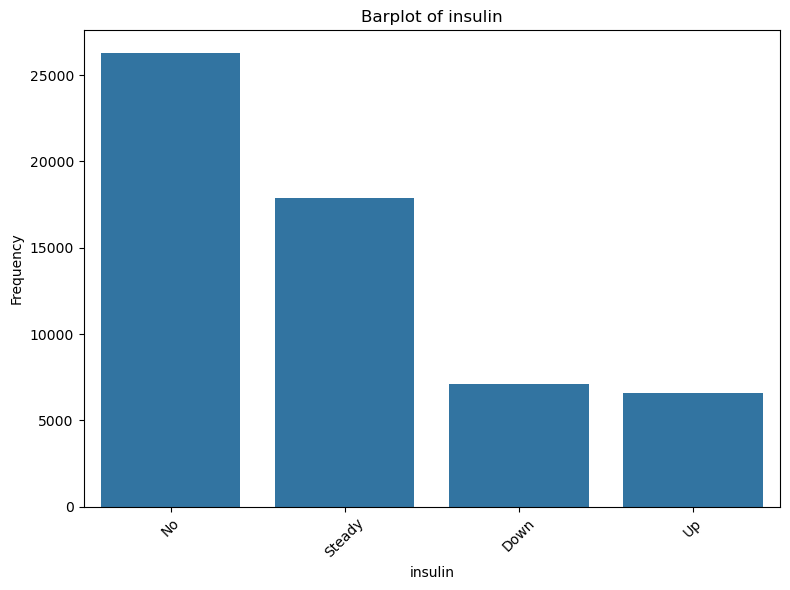

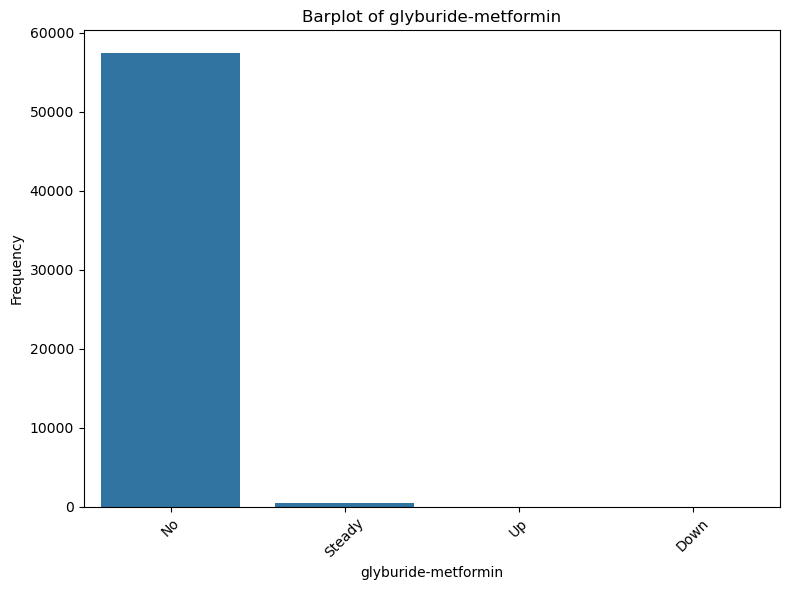

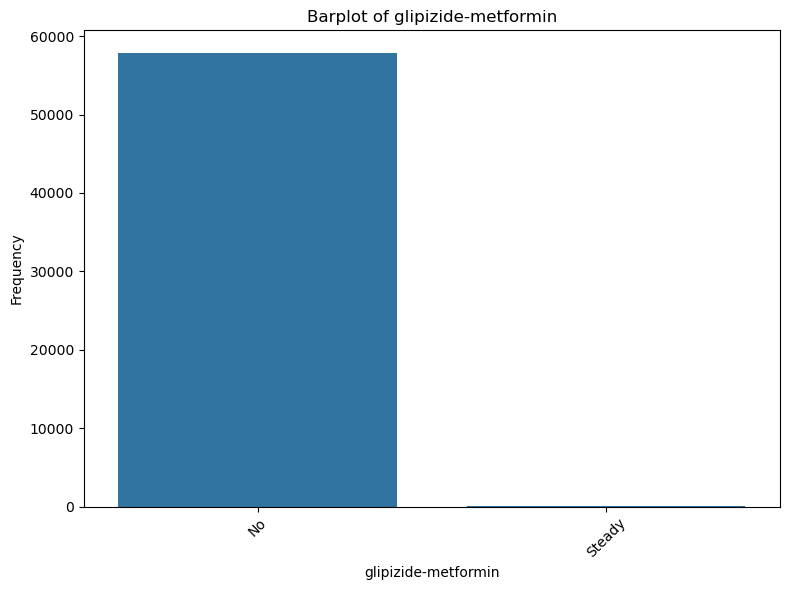

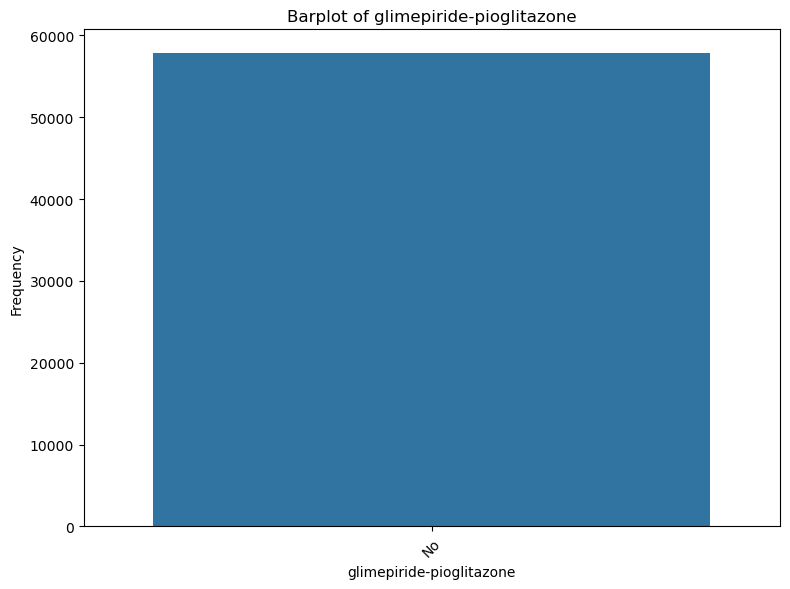

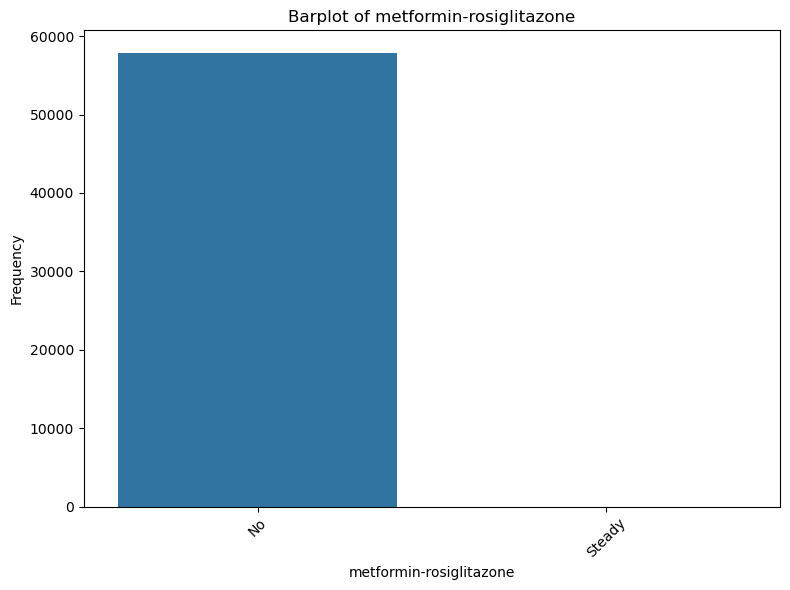

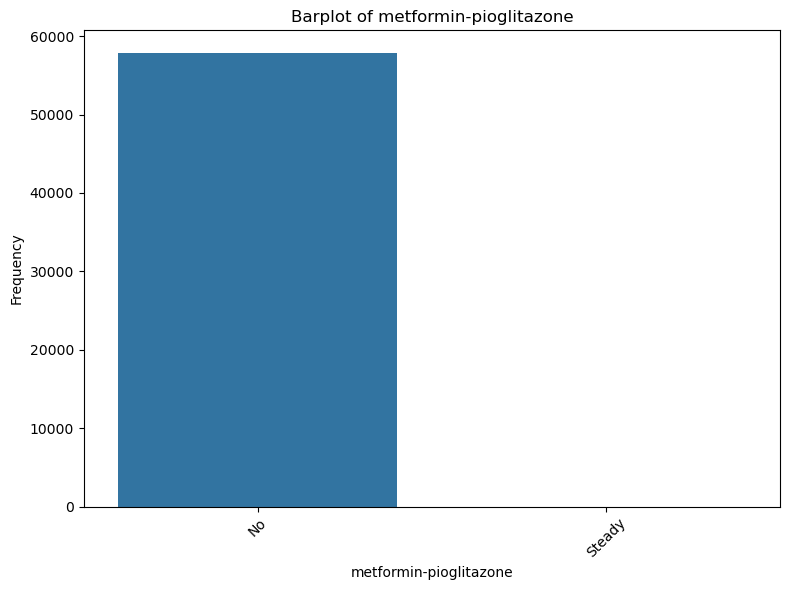

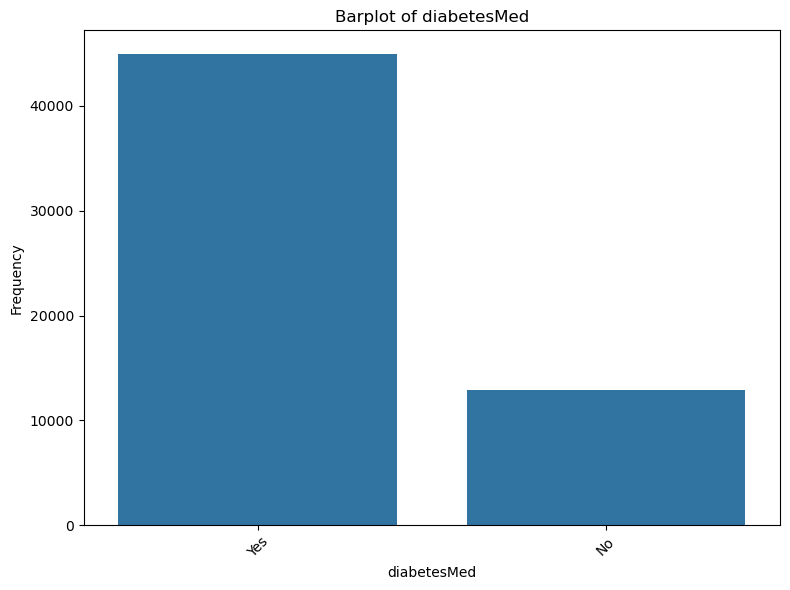

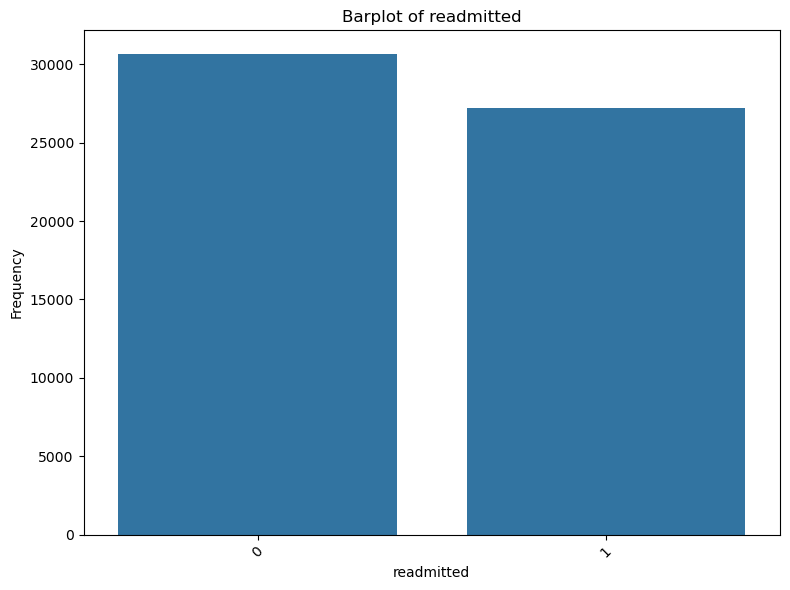

In [27]:


def plot_barplot(data, column_name):
    plt.figure(figsize=(8, 6))
    sns.countplot(
        data=data, x=column_name, order=data[column_name].value_counts().index
    )
    plt.title(f"Barplot of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


for col in train_factor.columns:
    plot_barplot(train_factor, col)


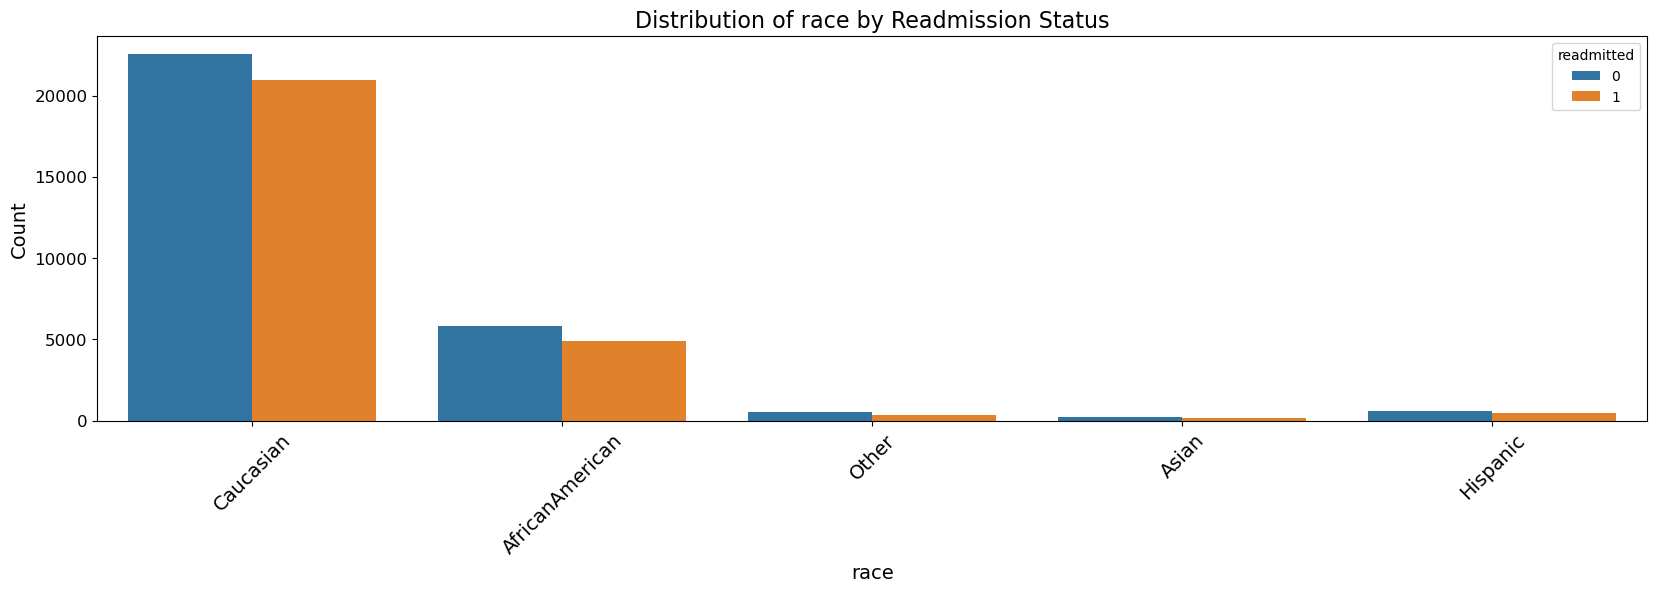

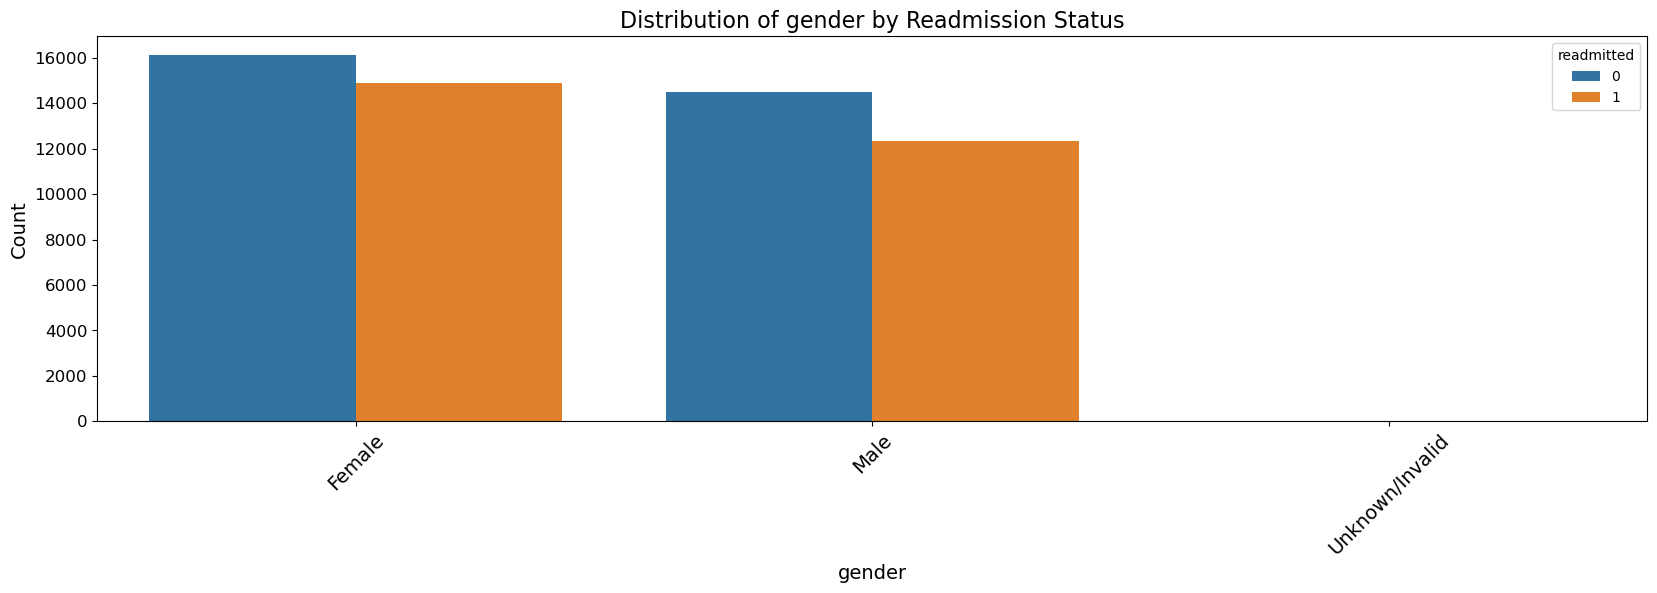

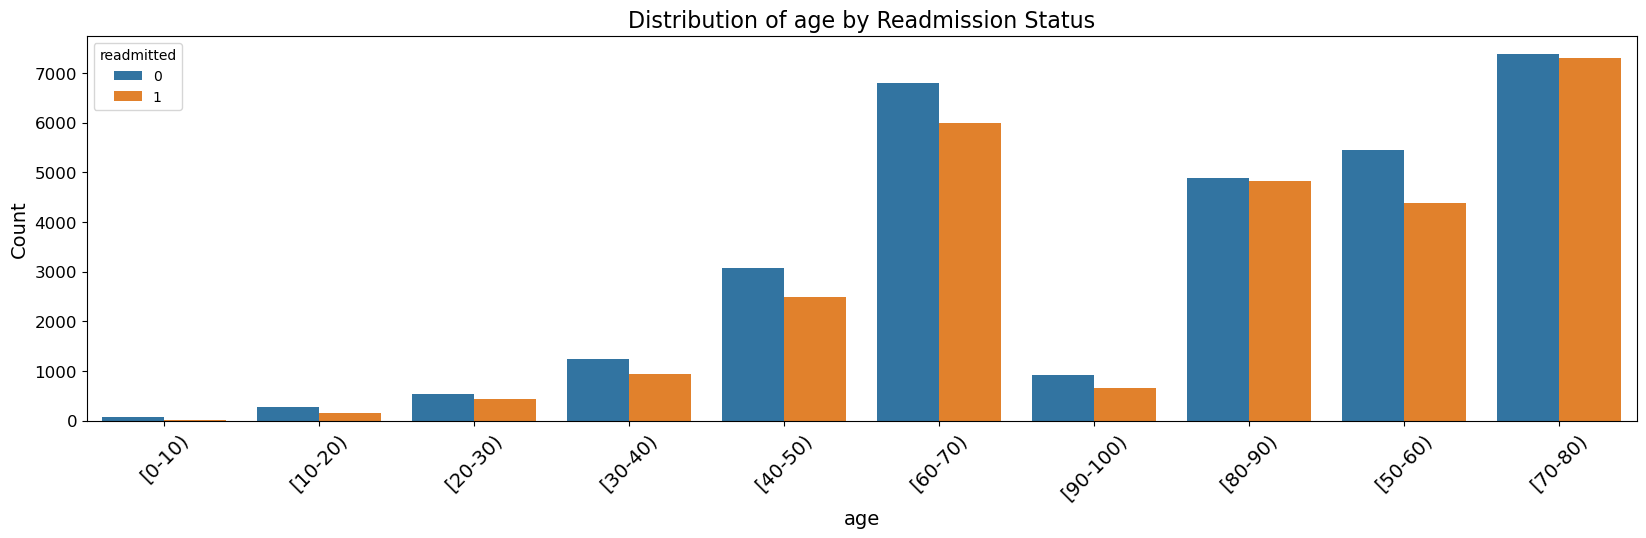

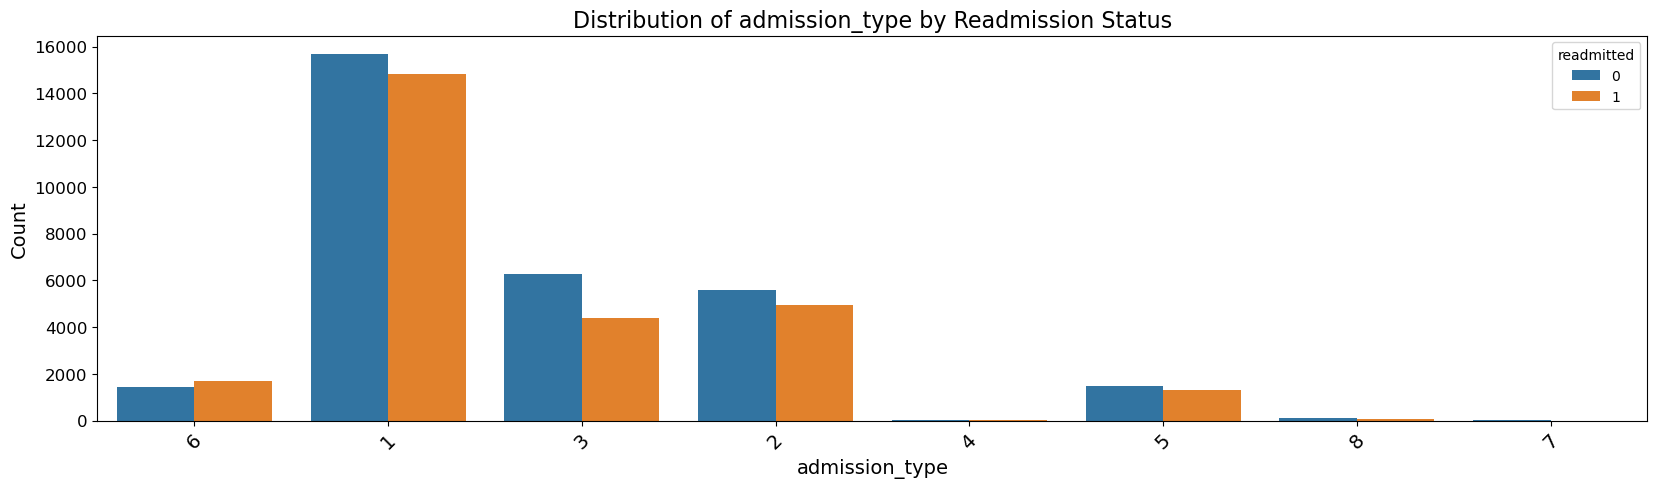

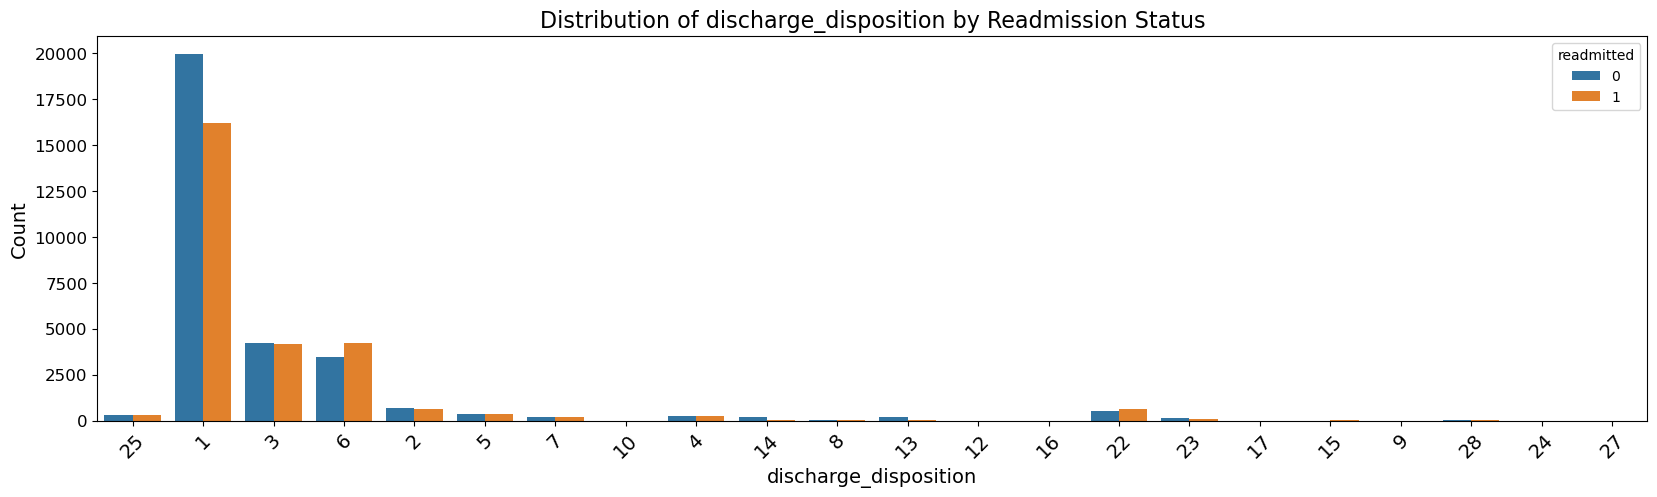

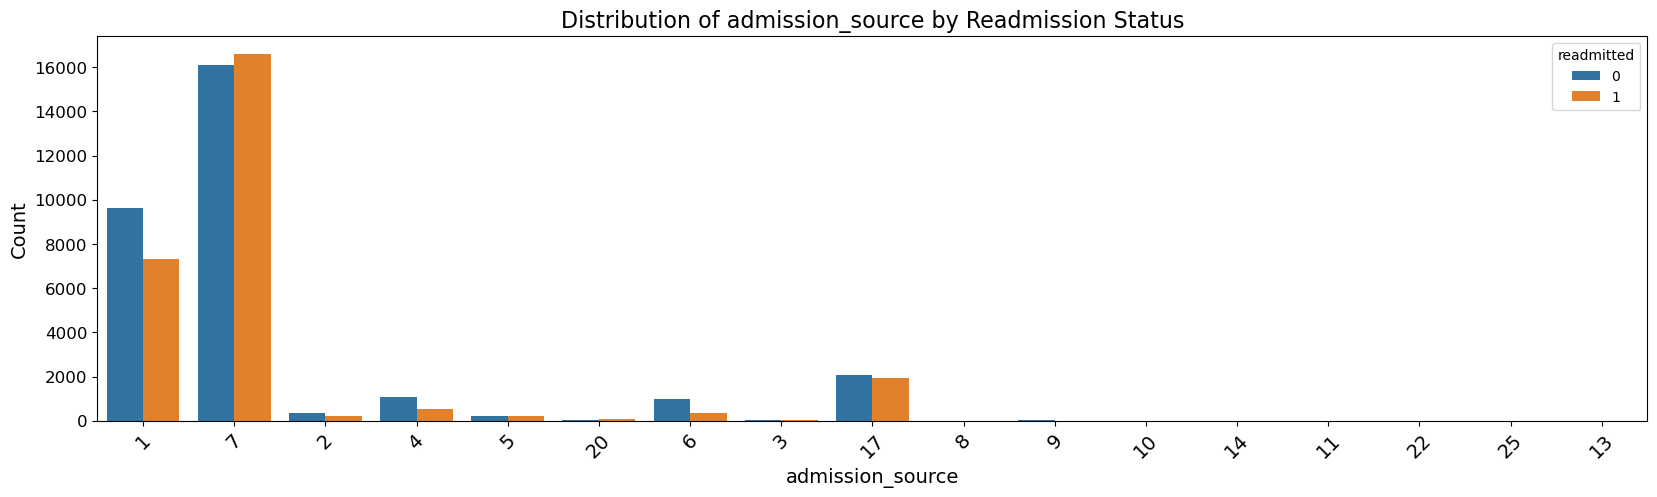

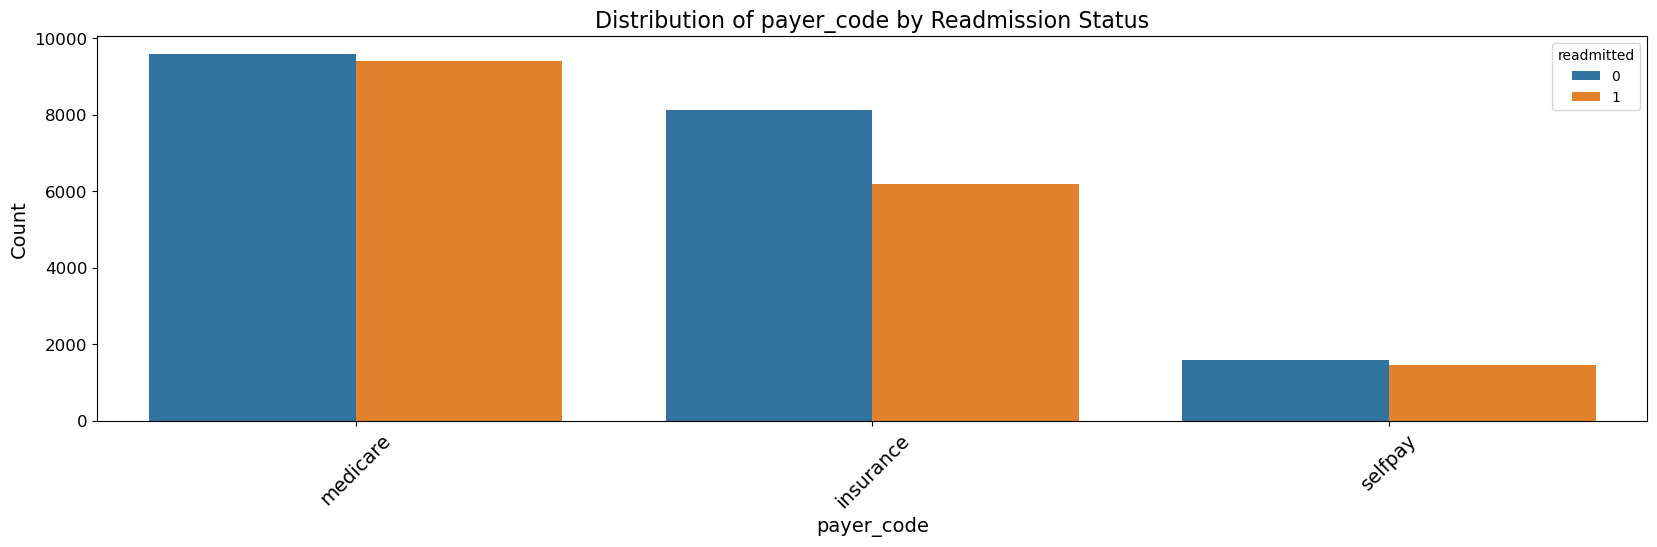

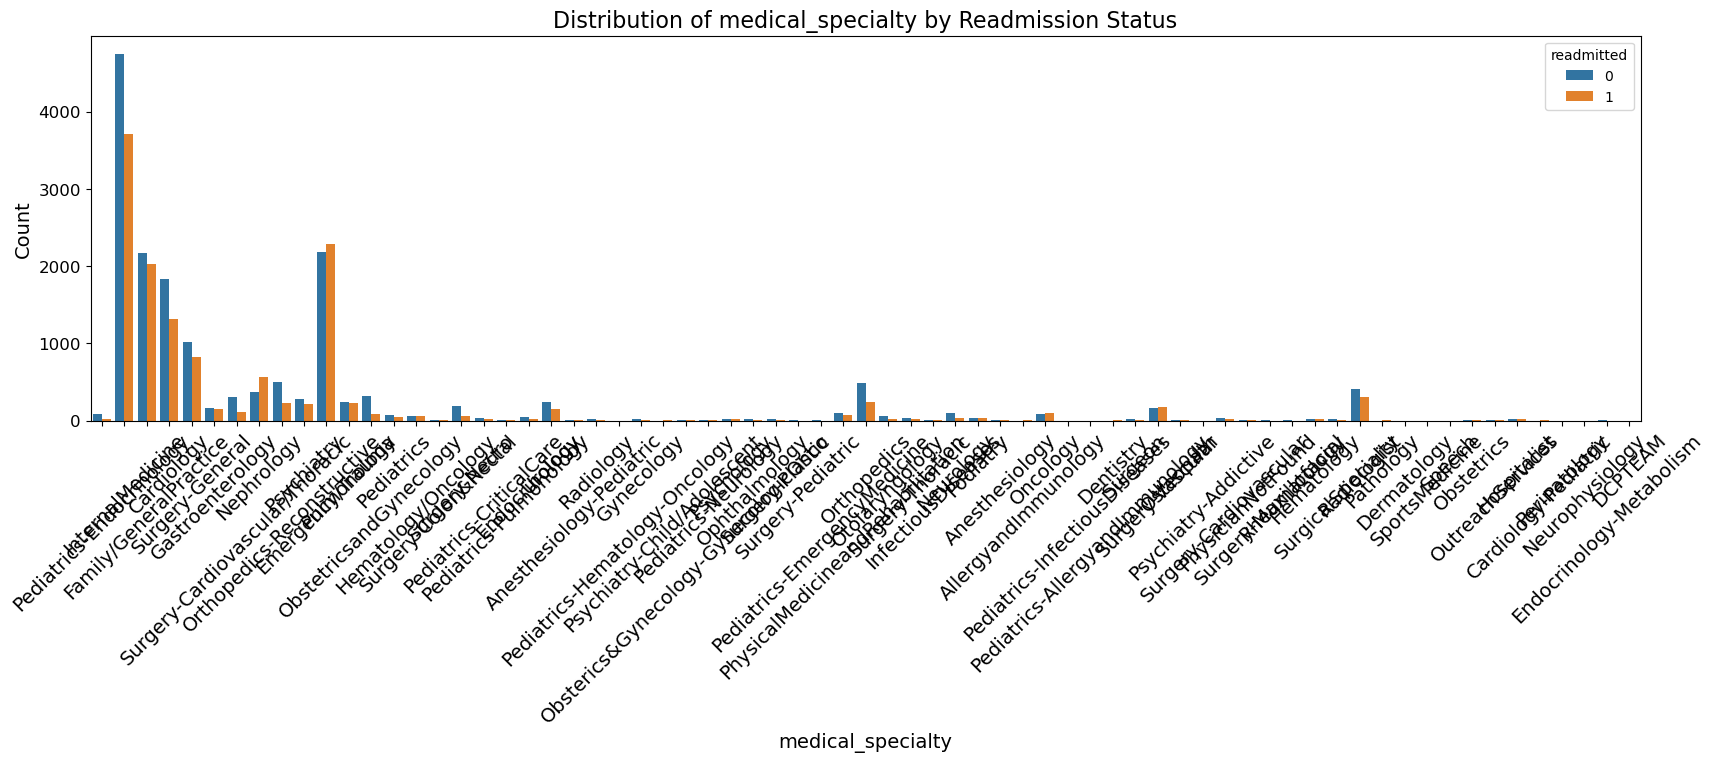

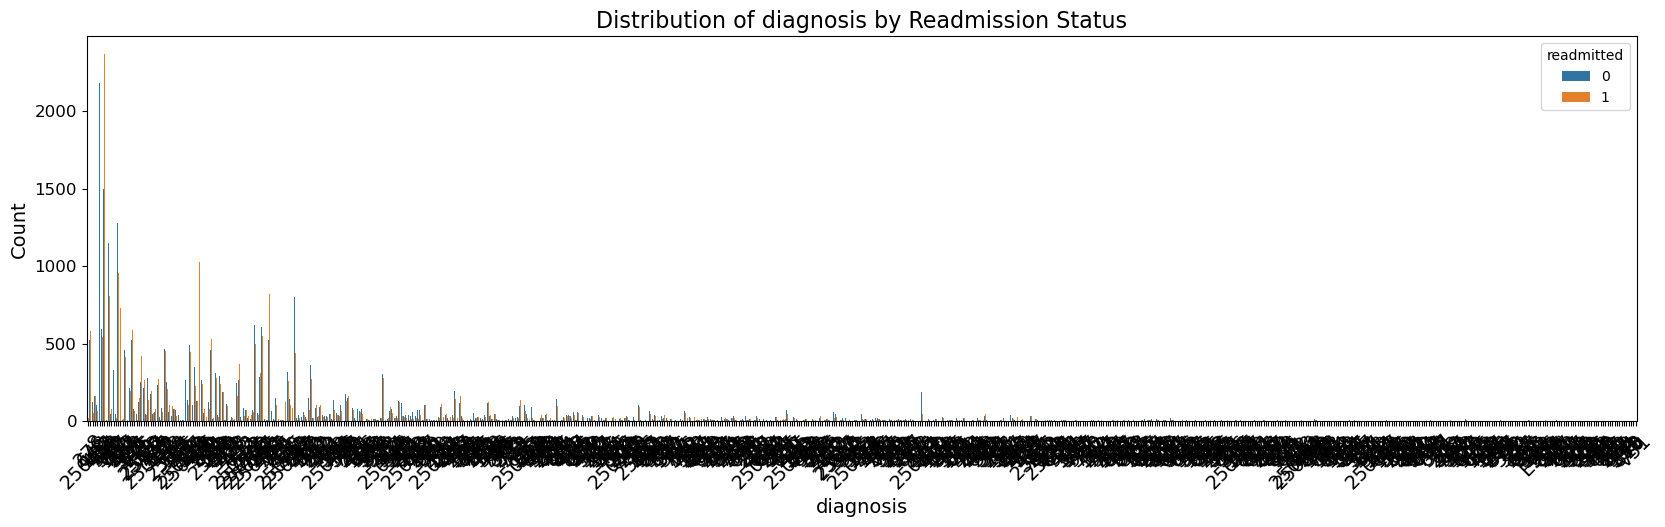

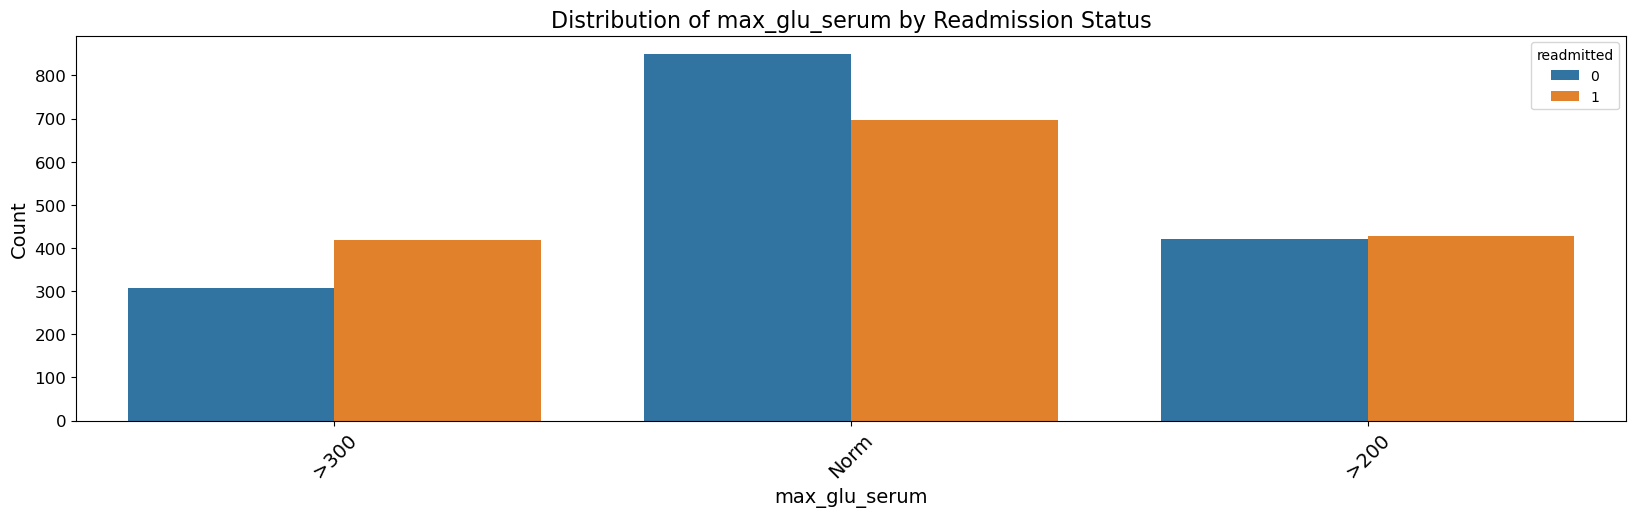

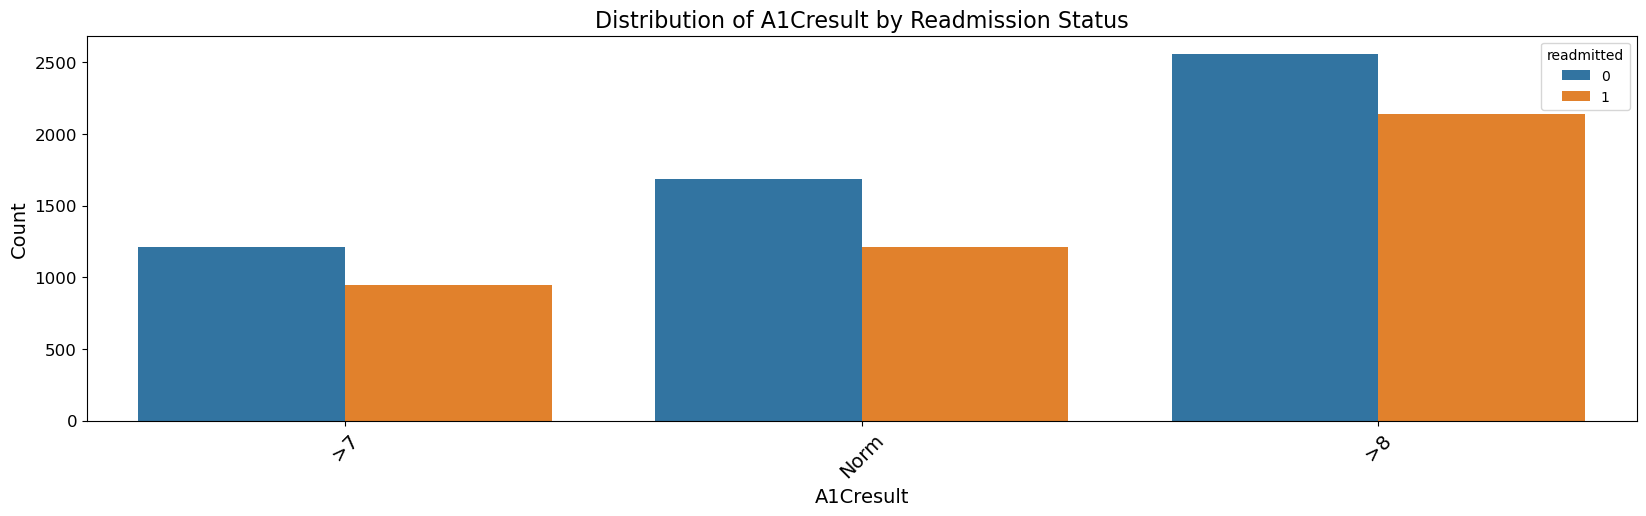

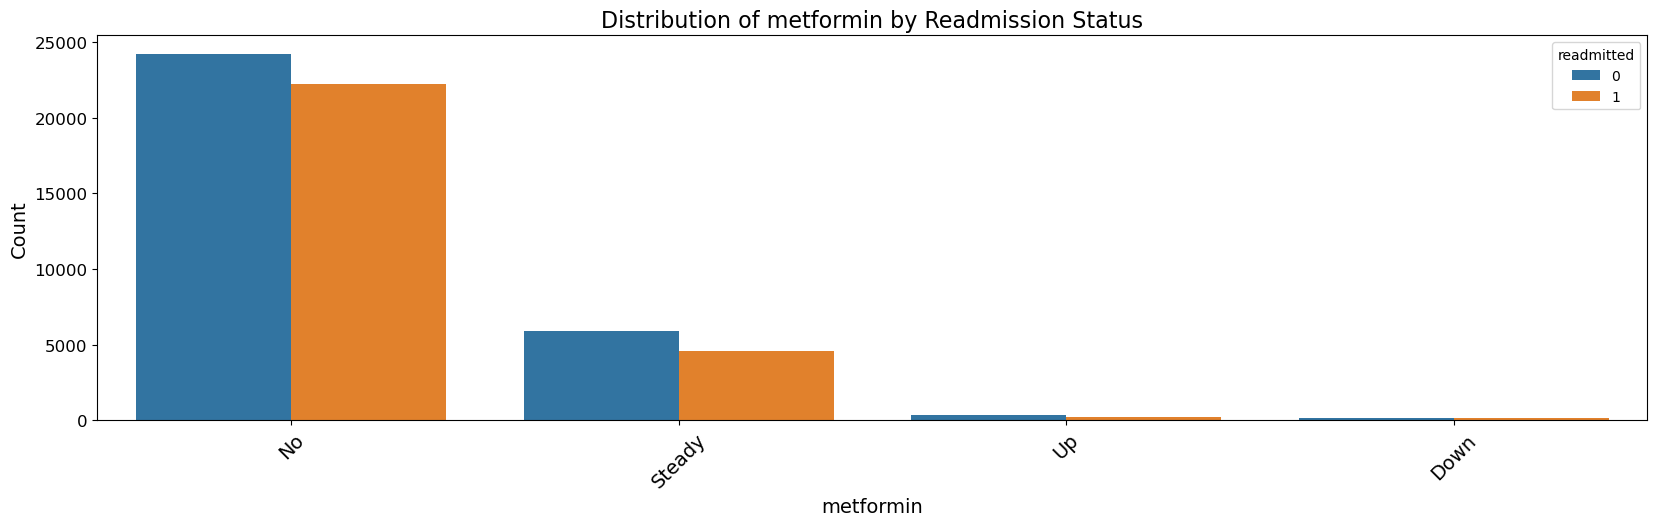

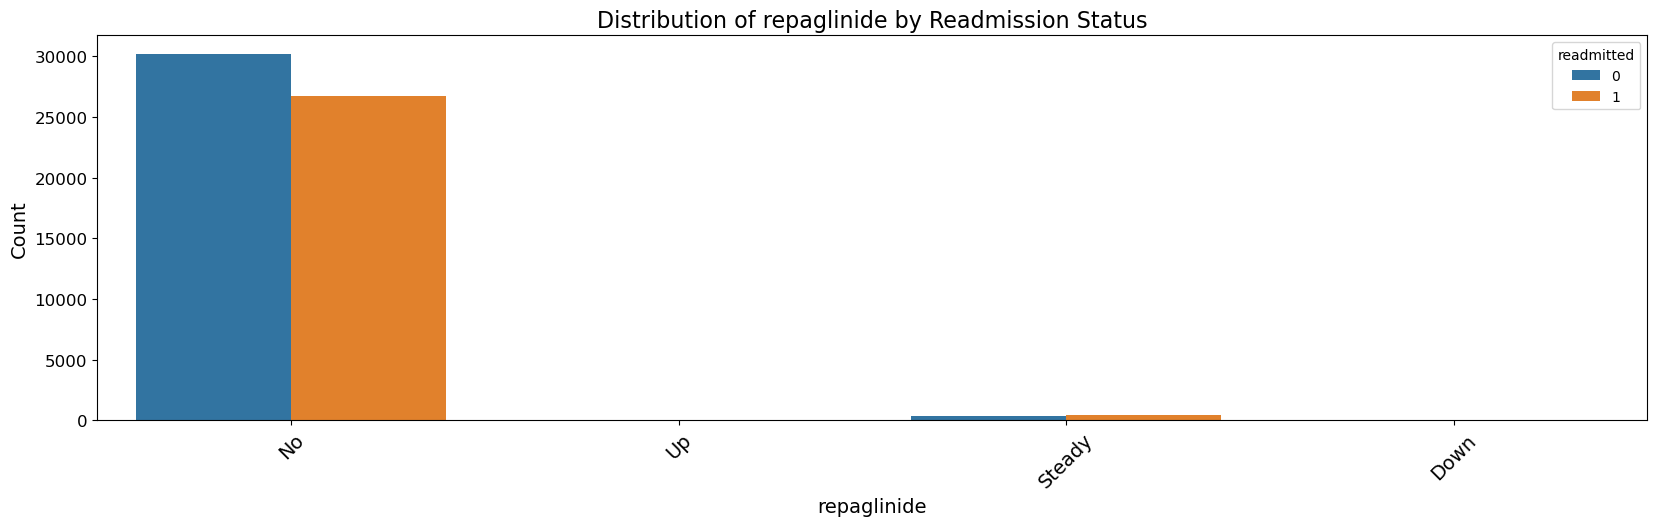

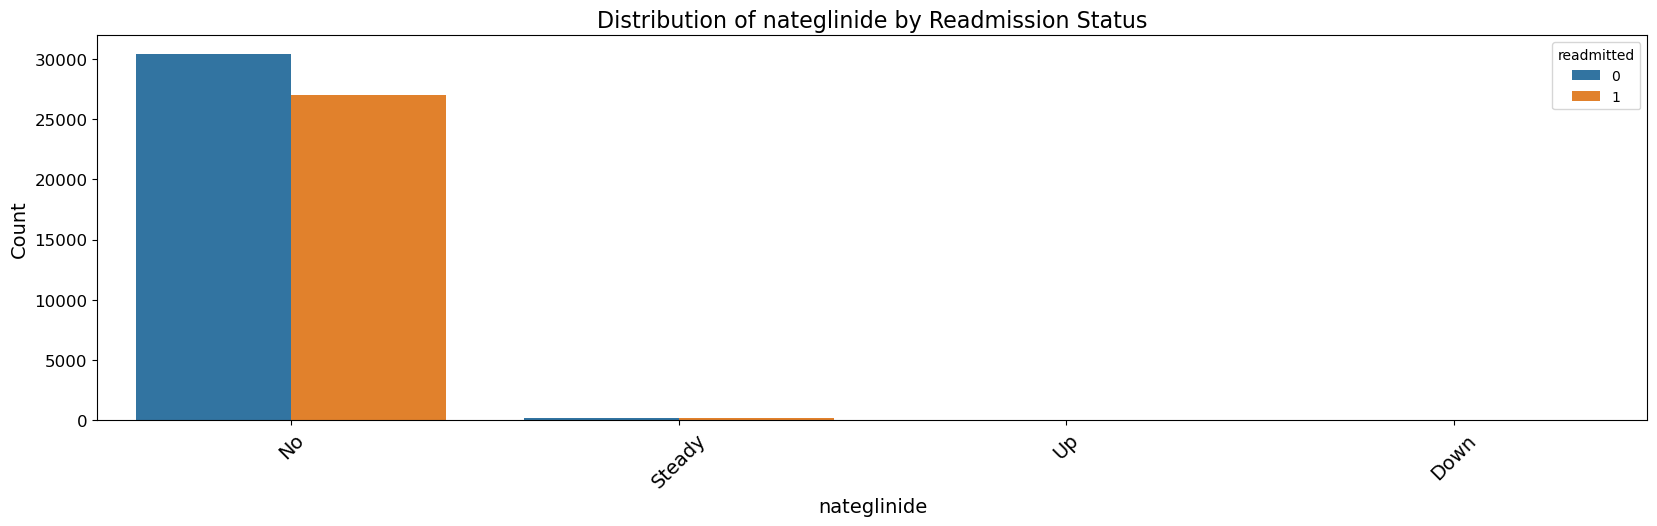

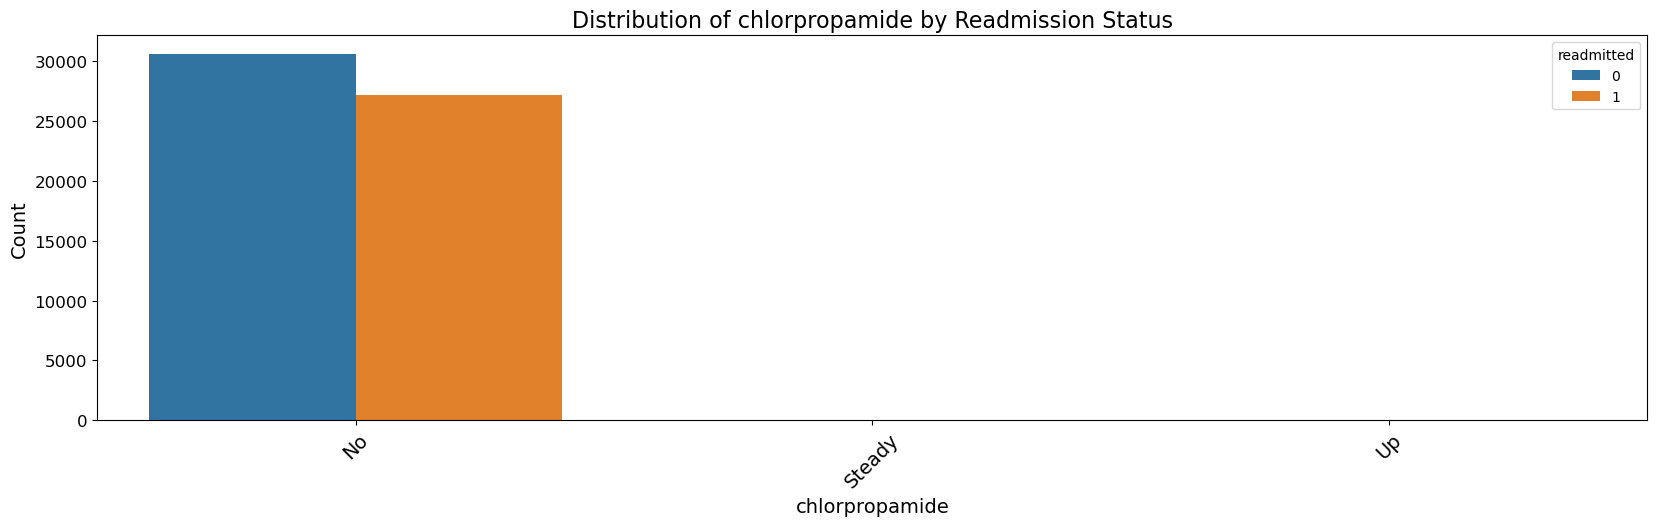

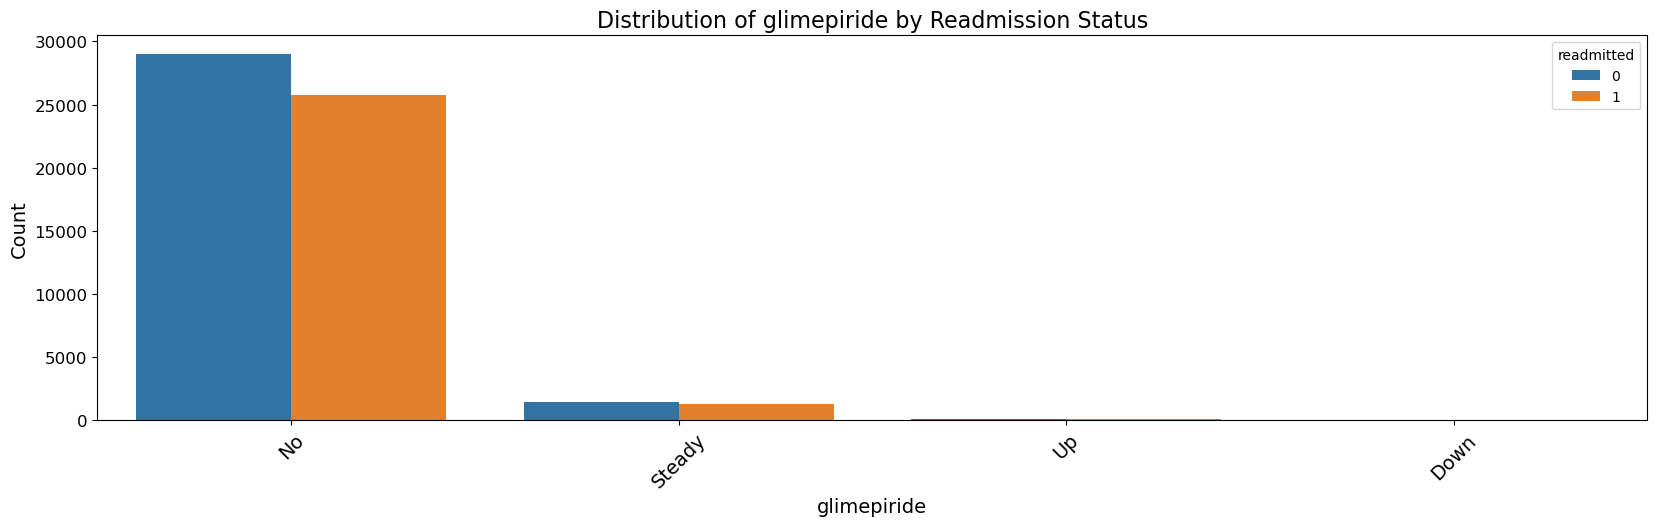

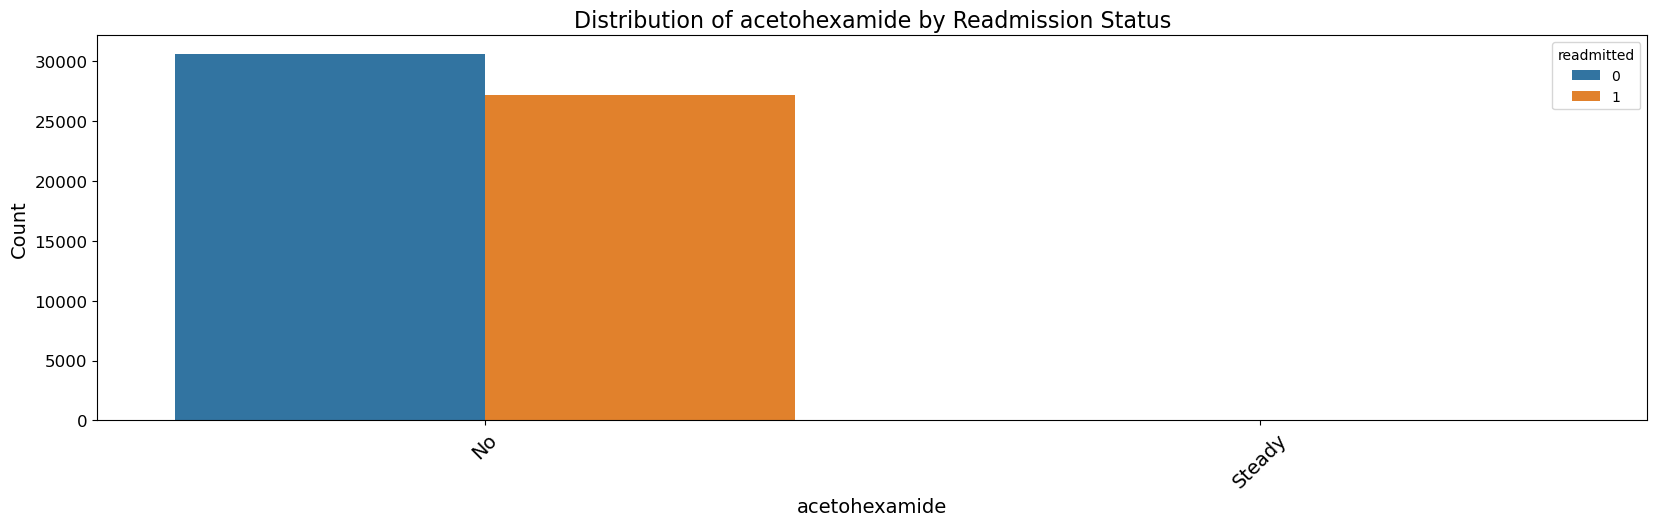

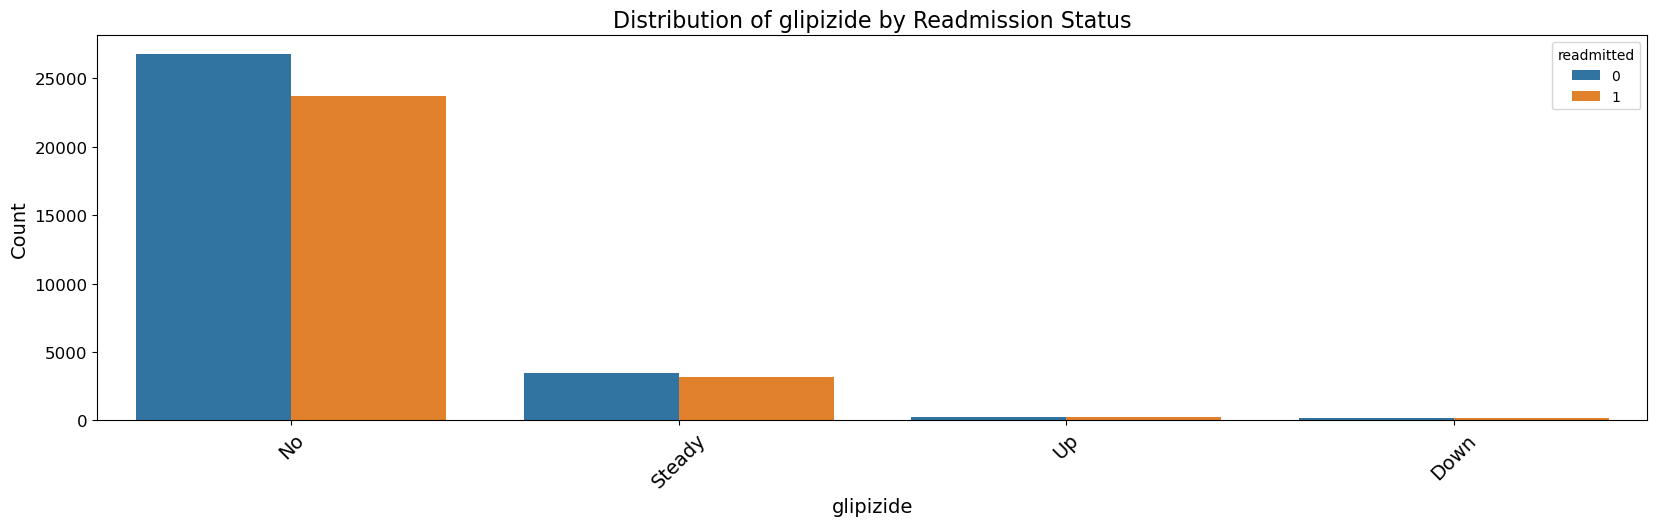

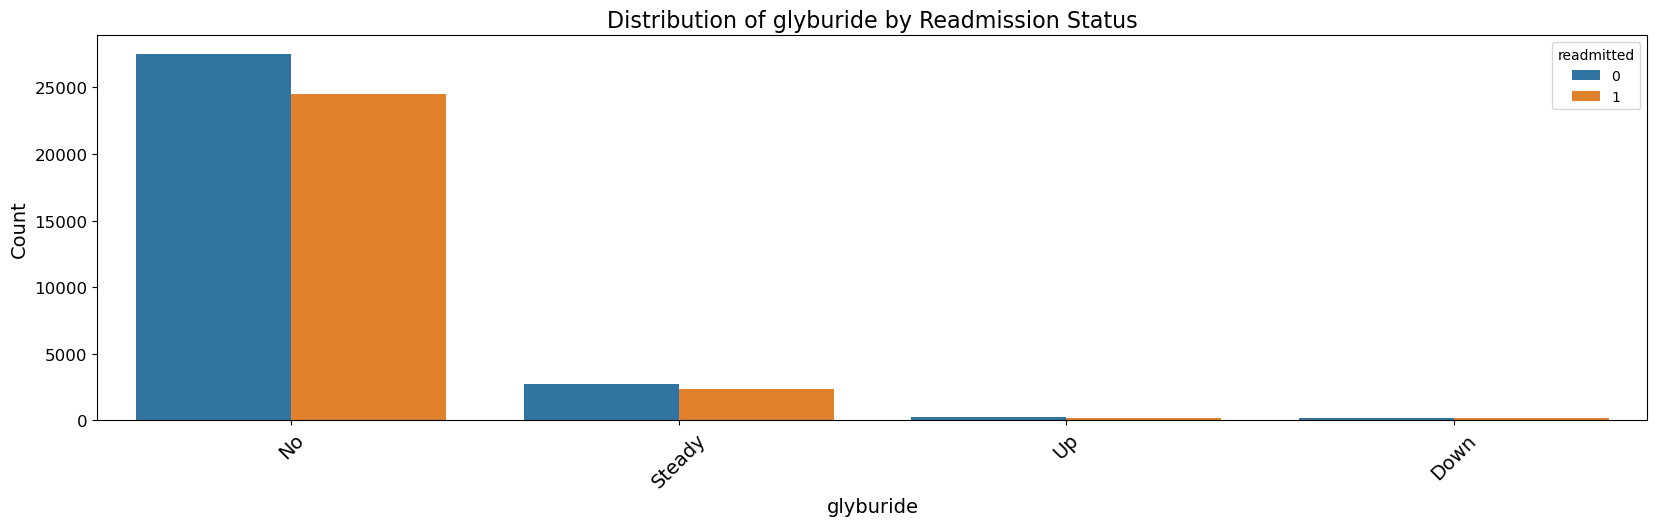

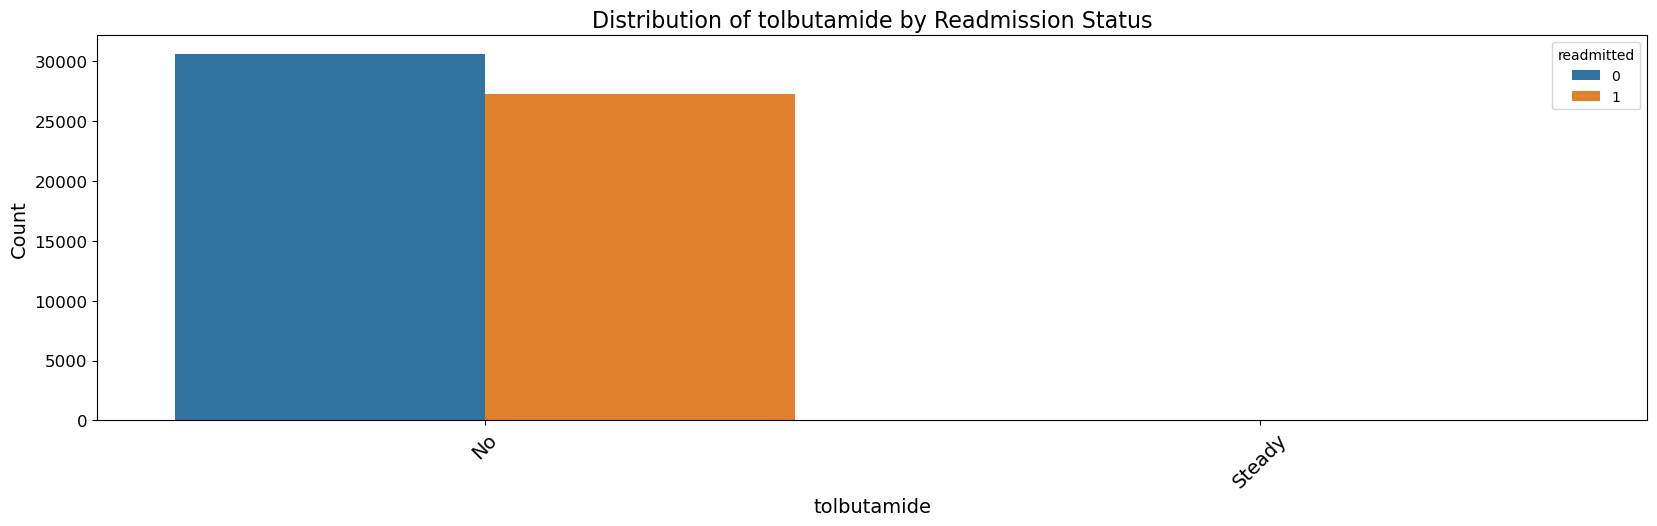

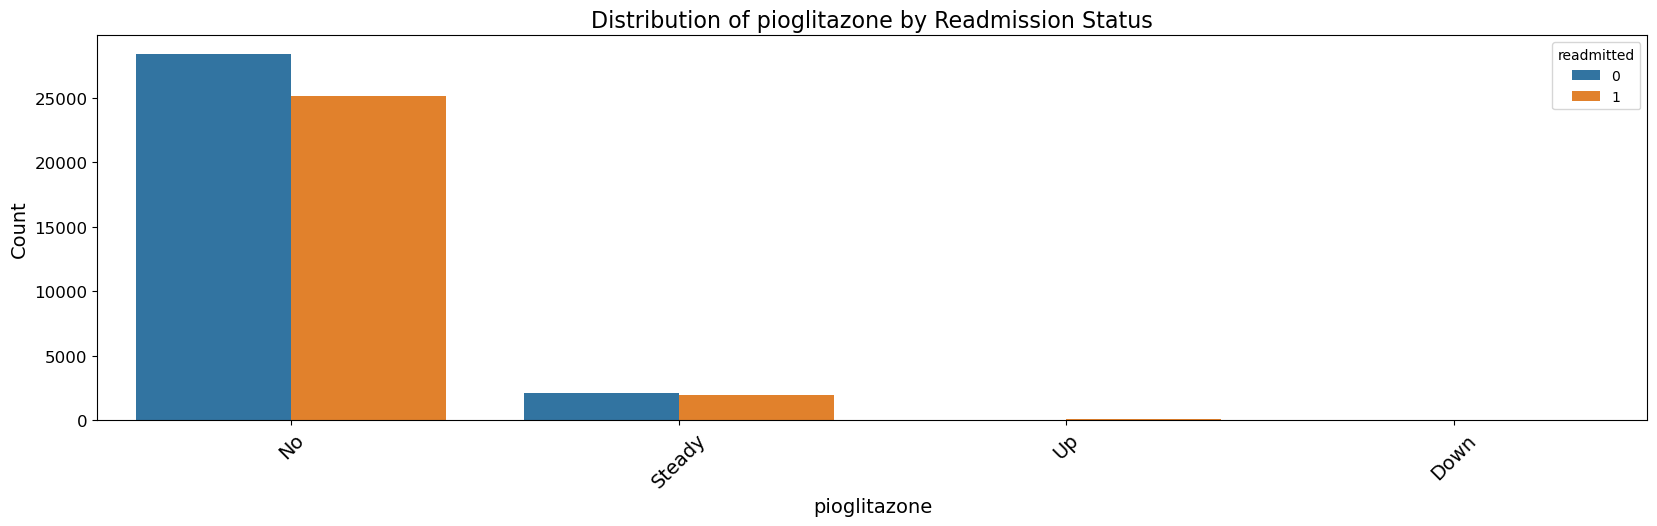

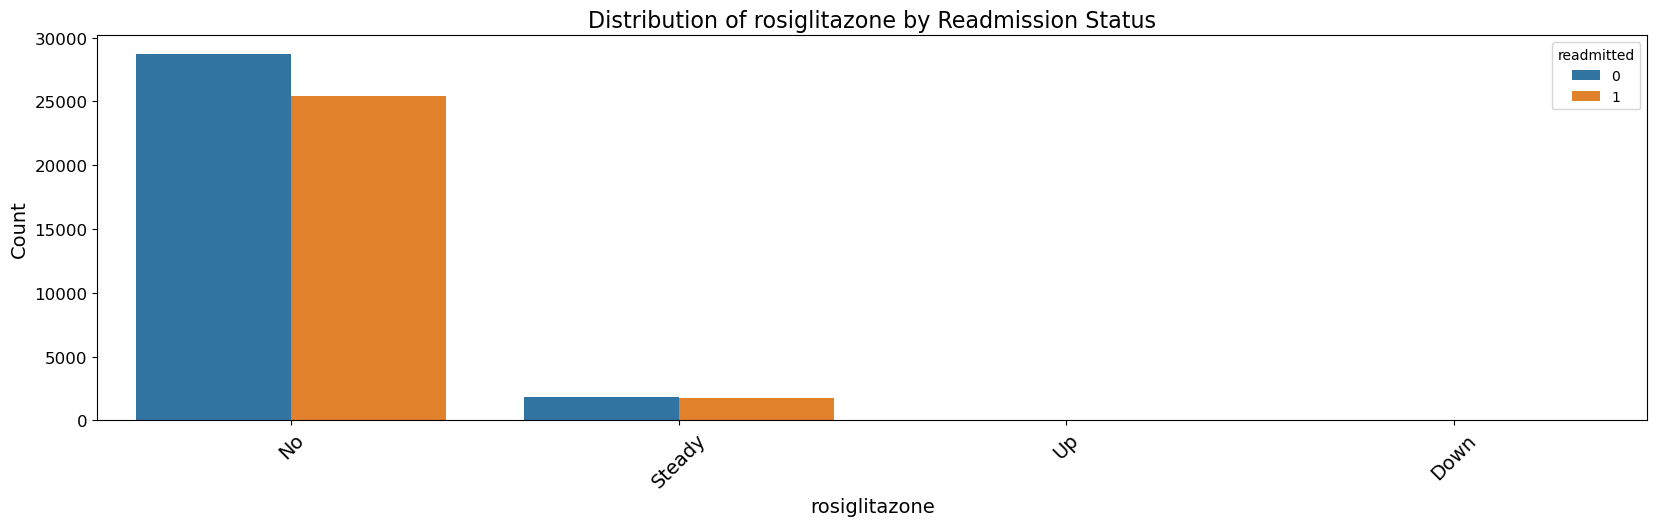

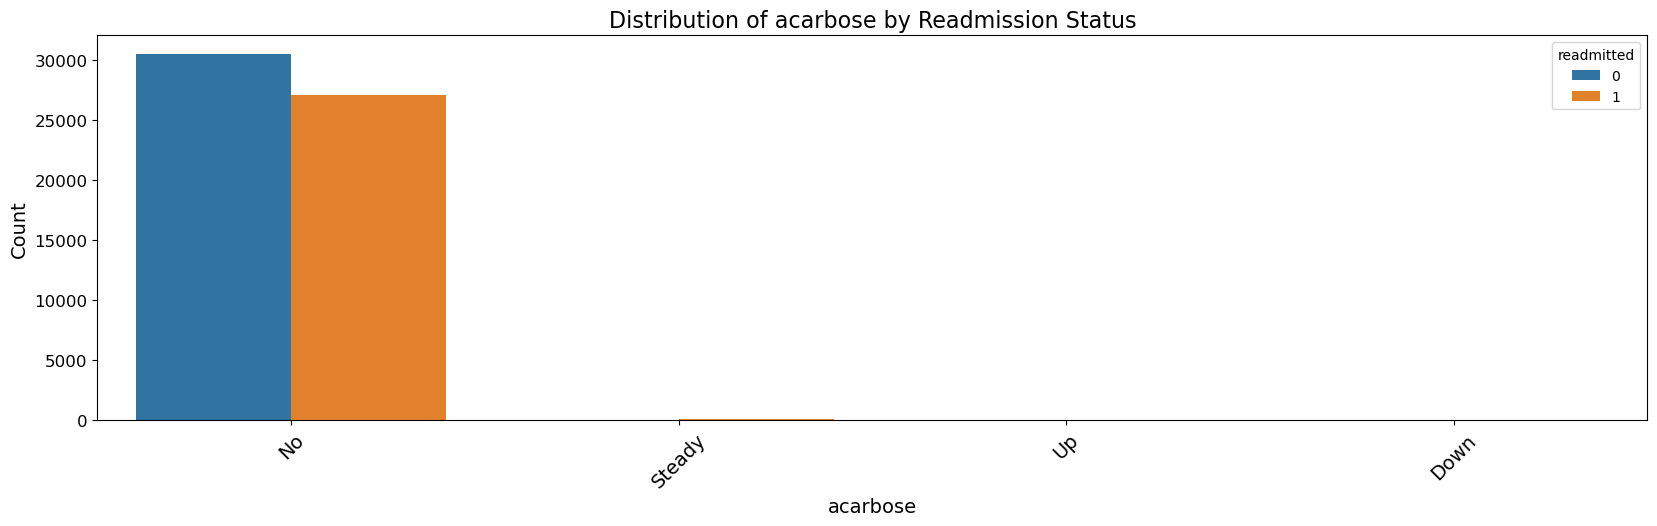

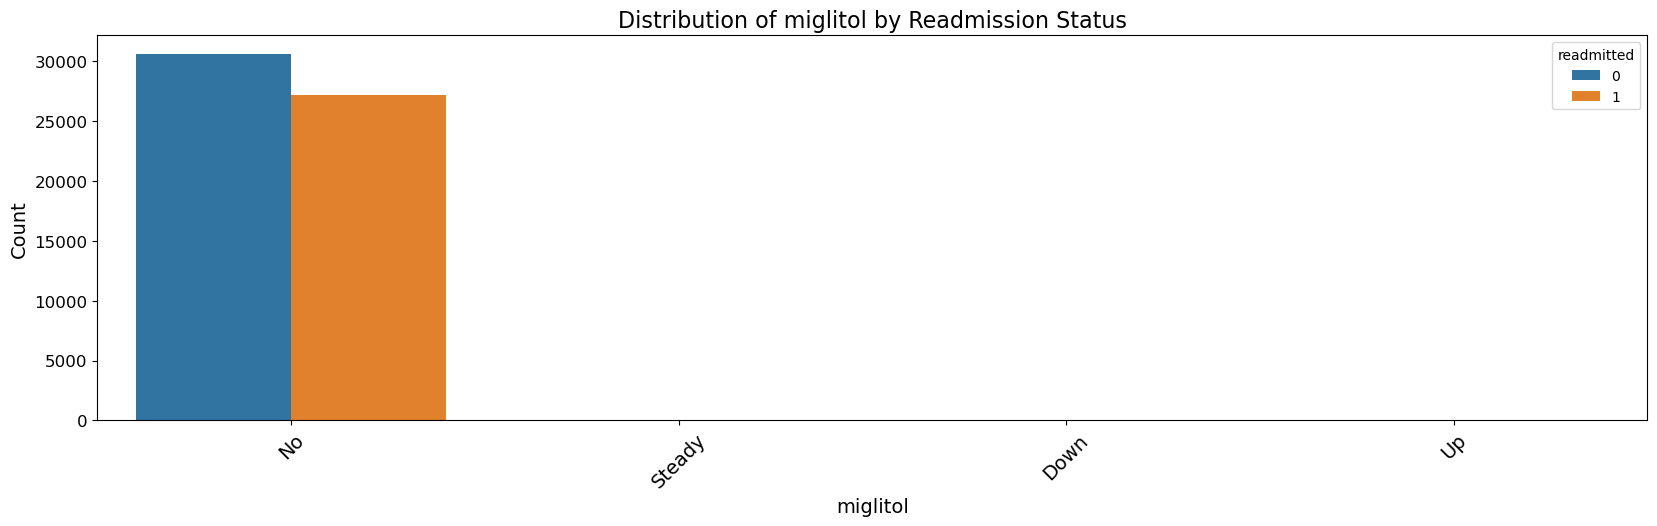

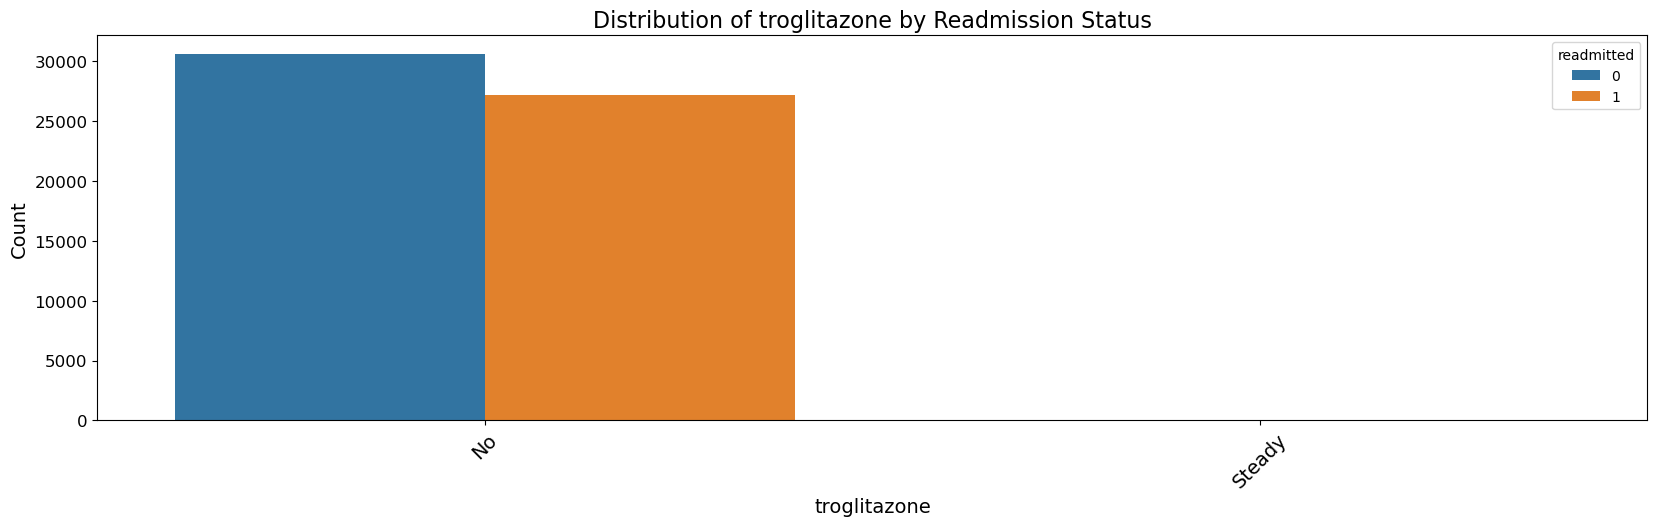

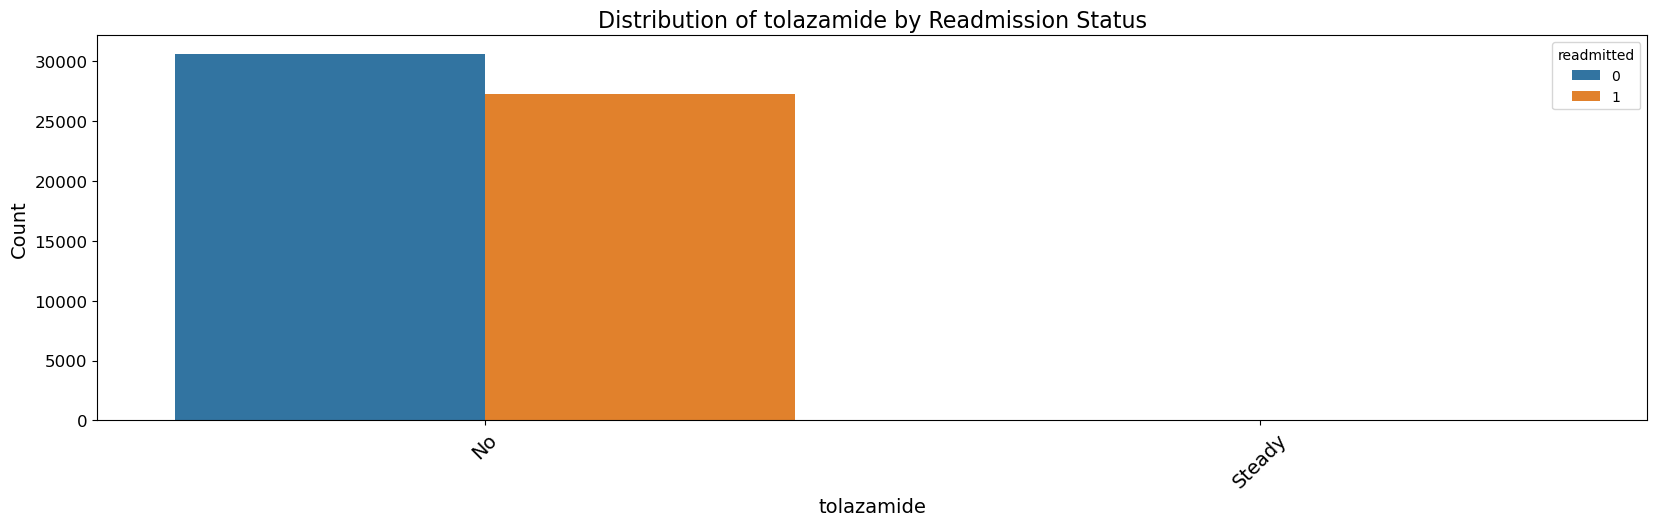

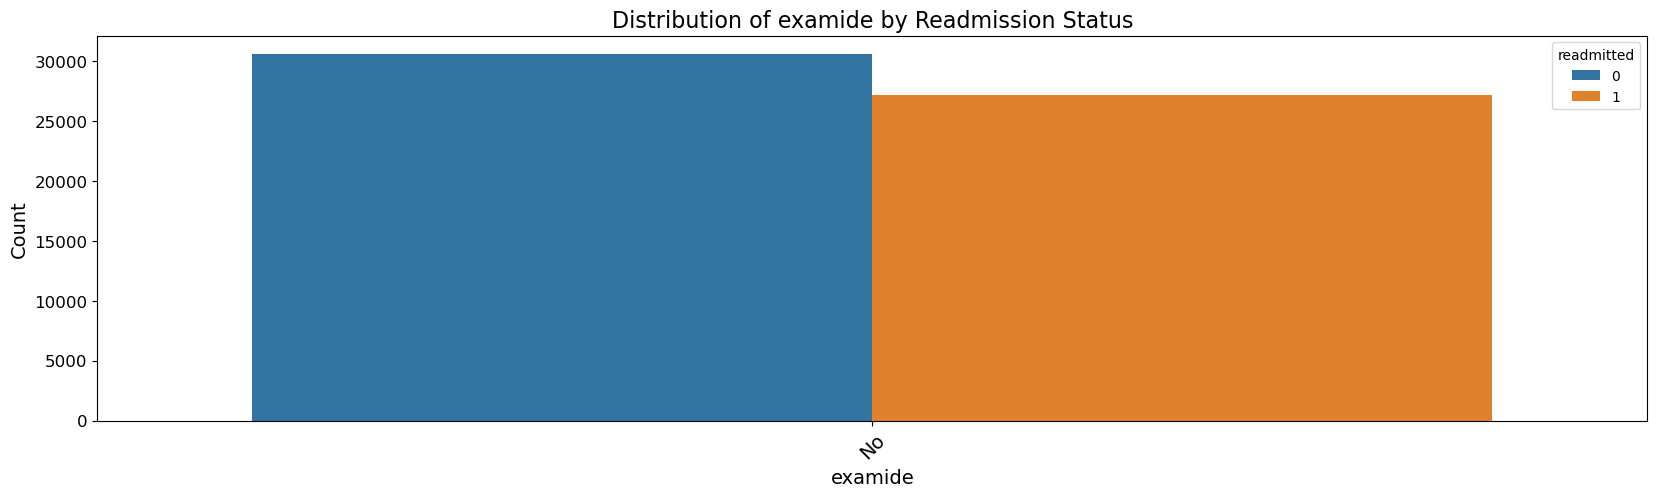

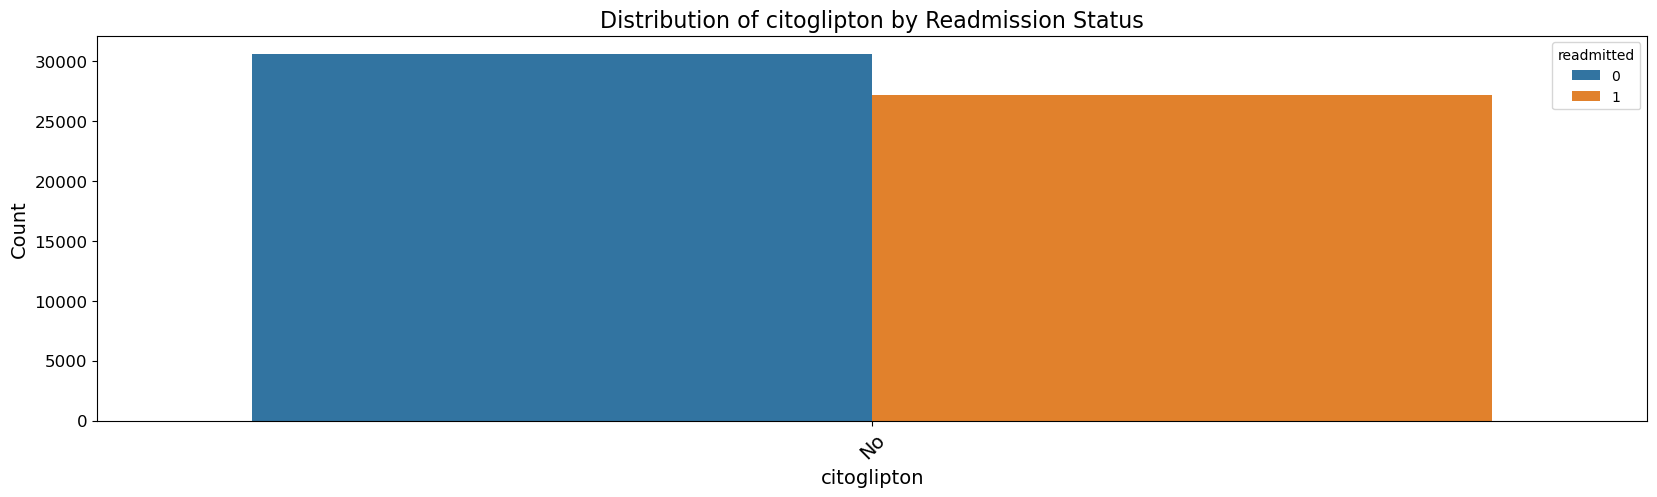

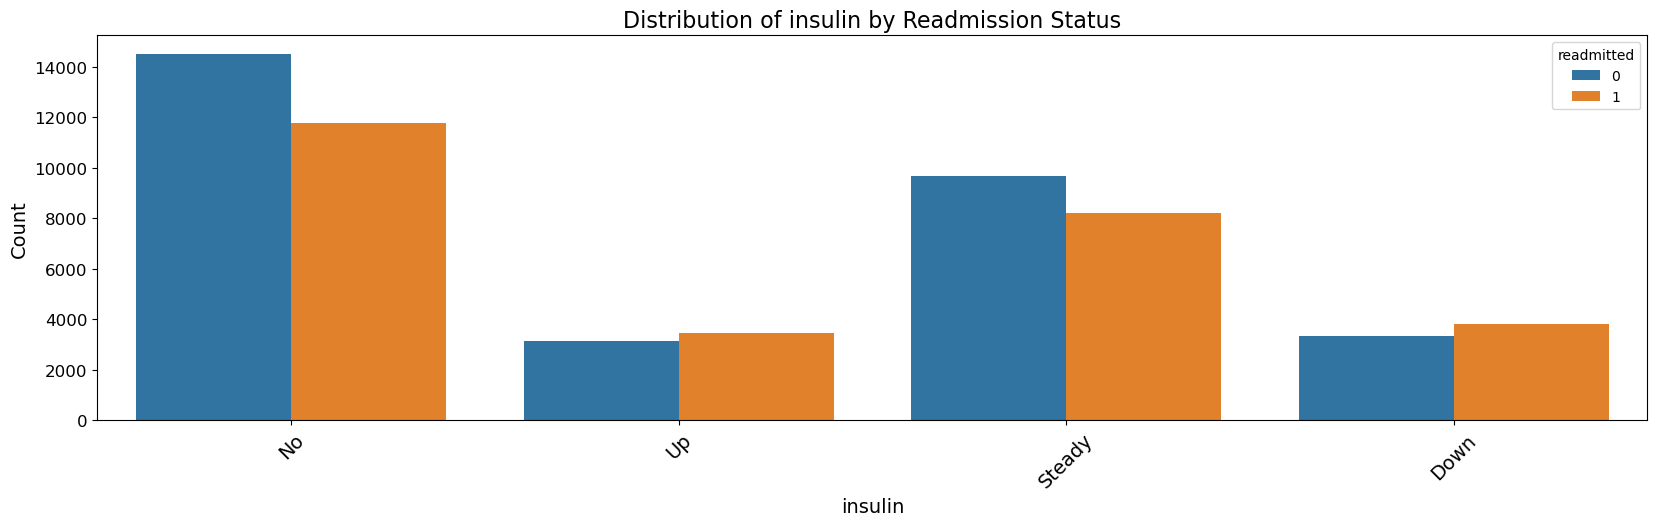

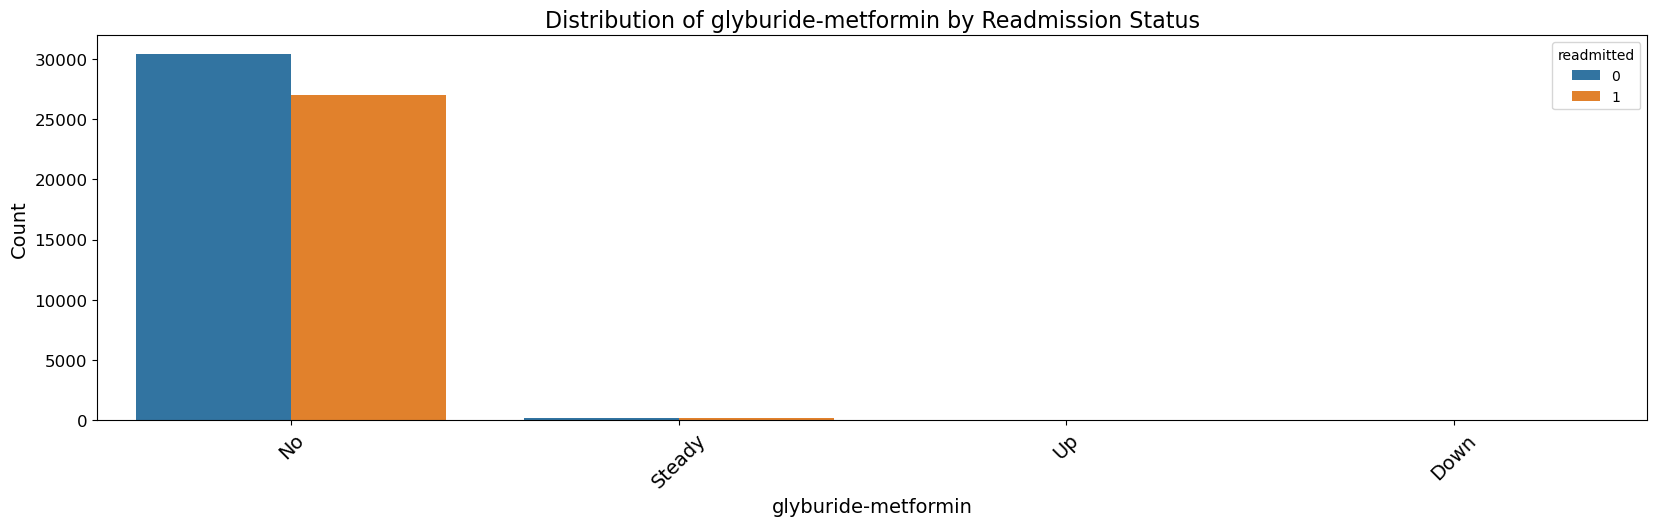

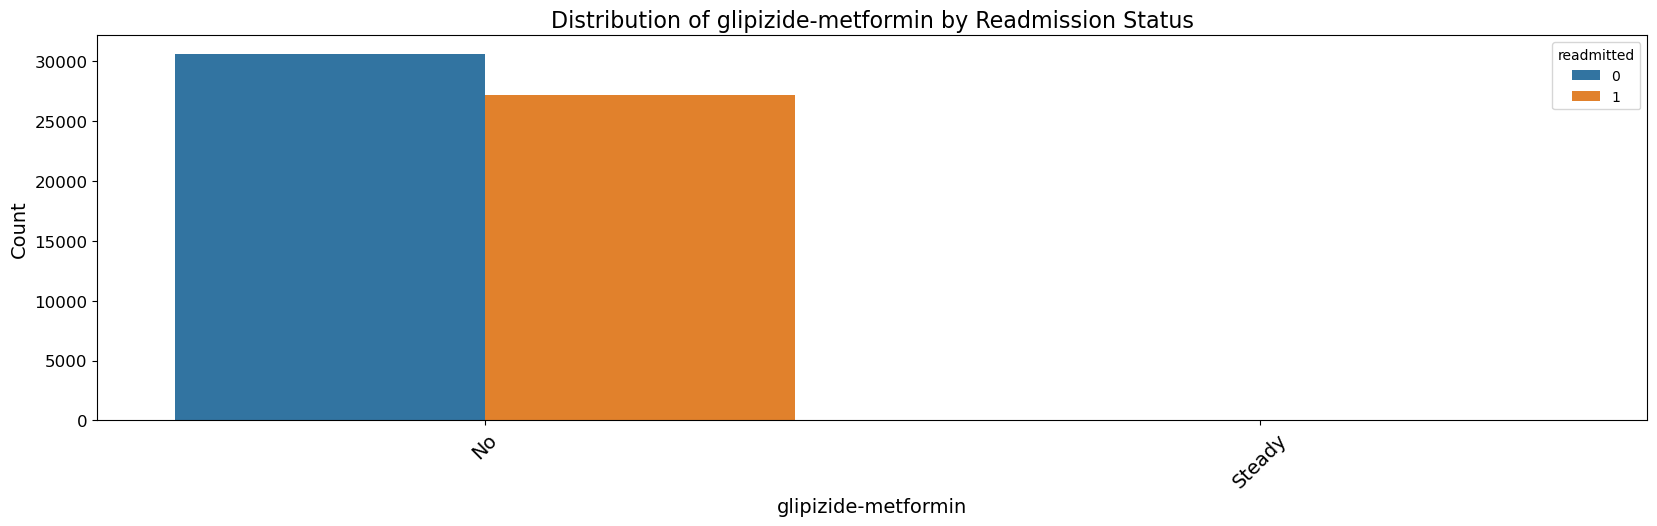

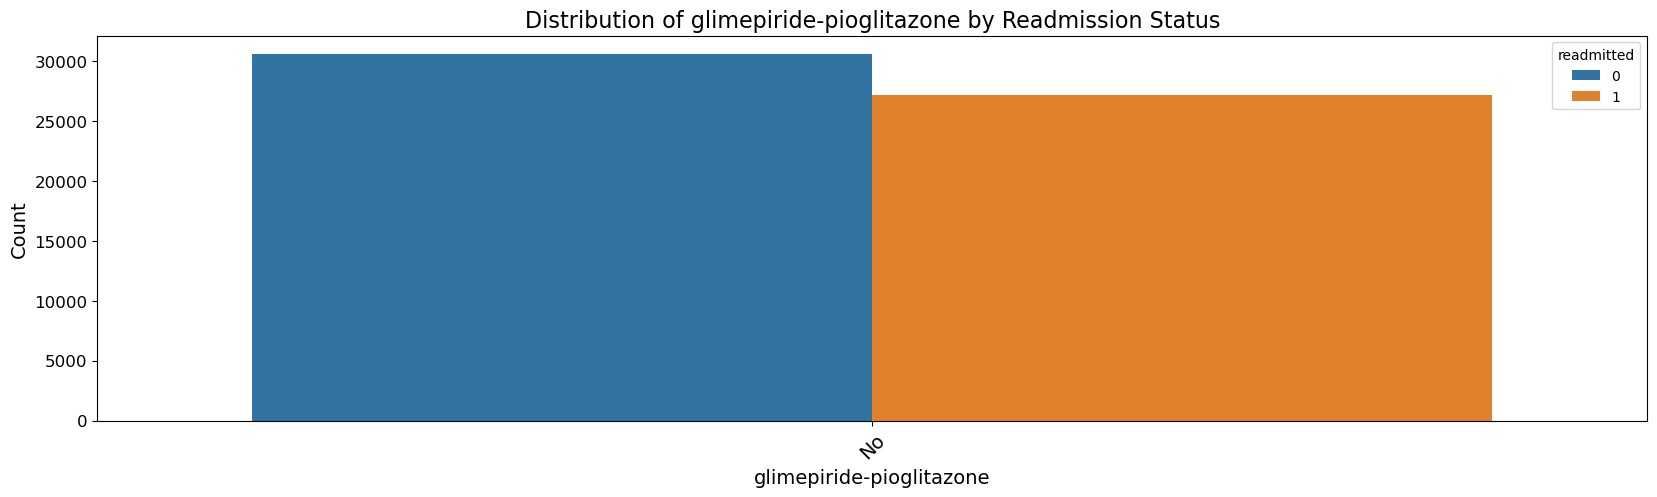

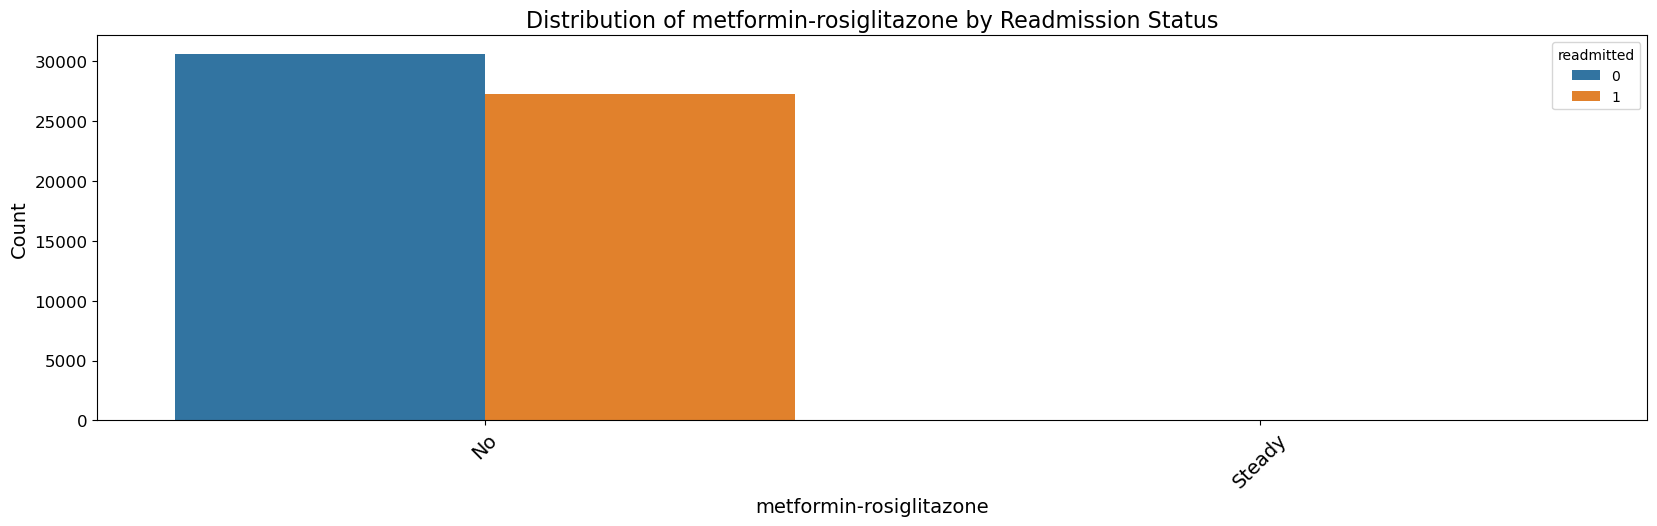

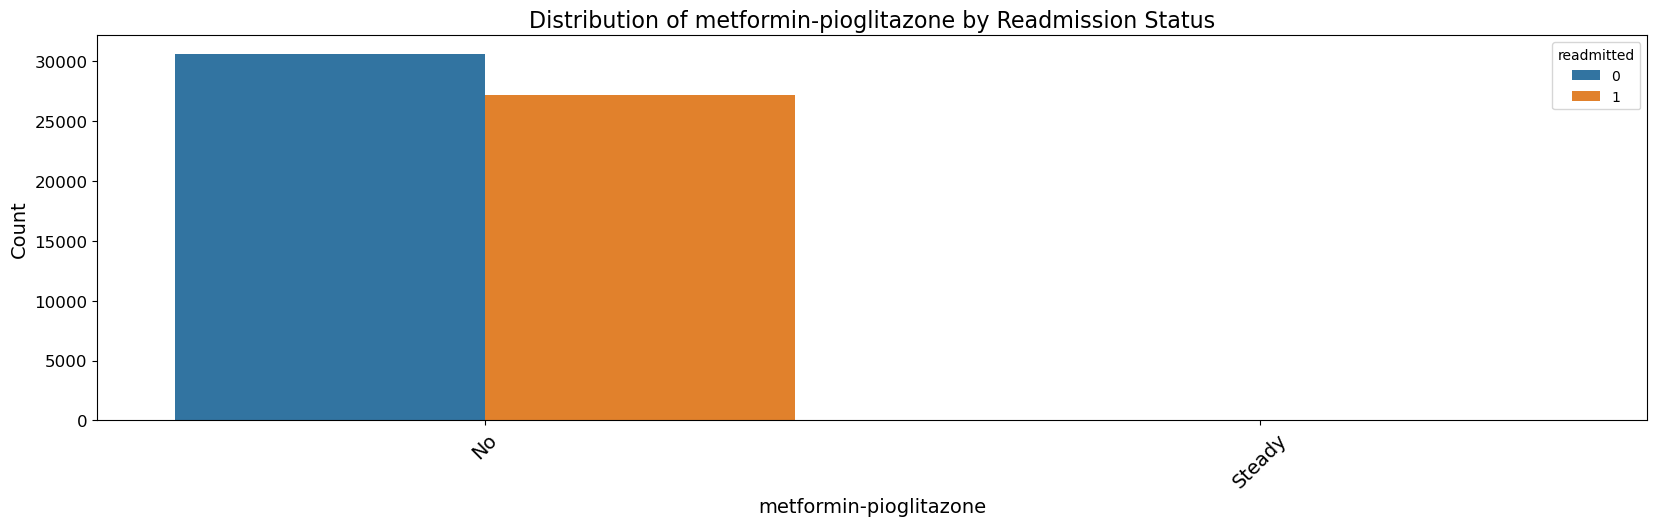

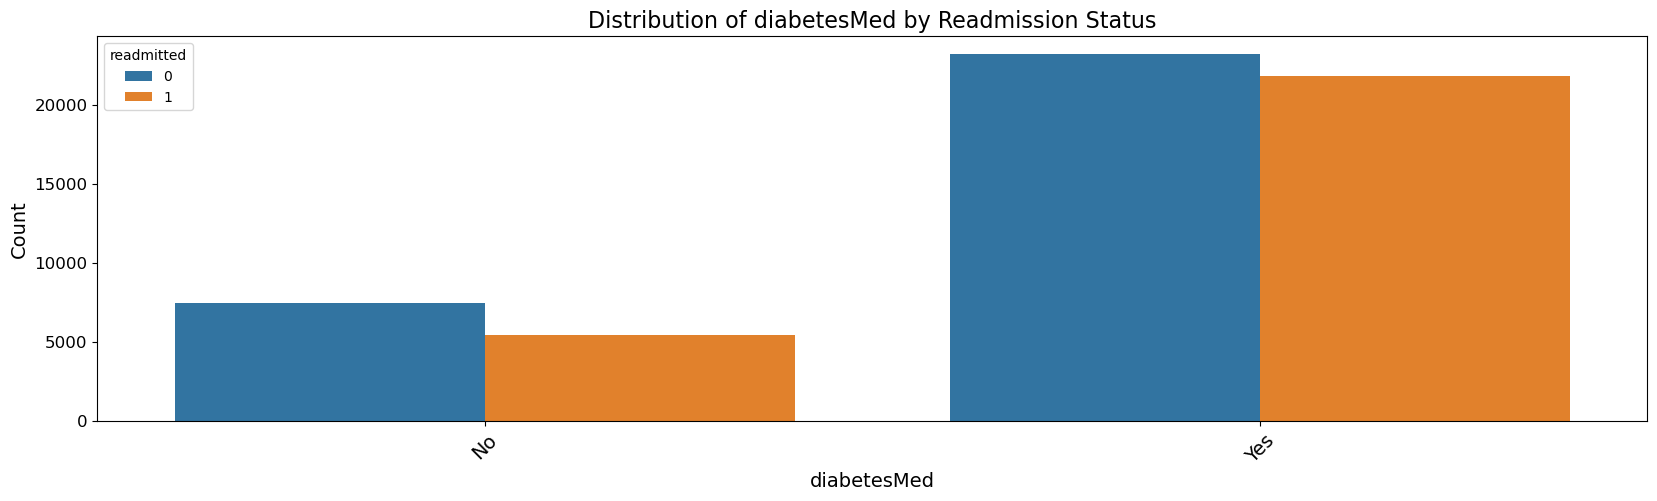

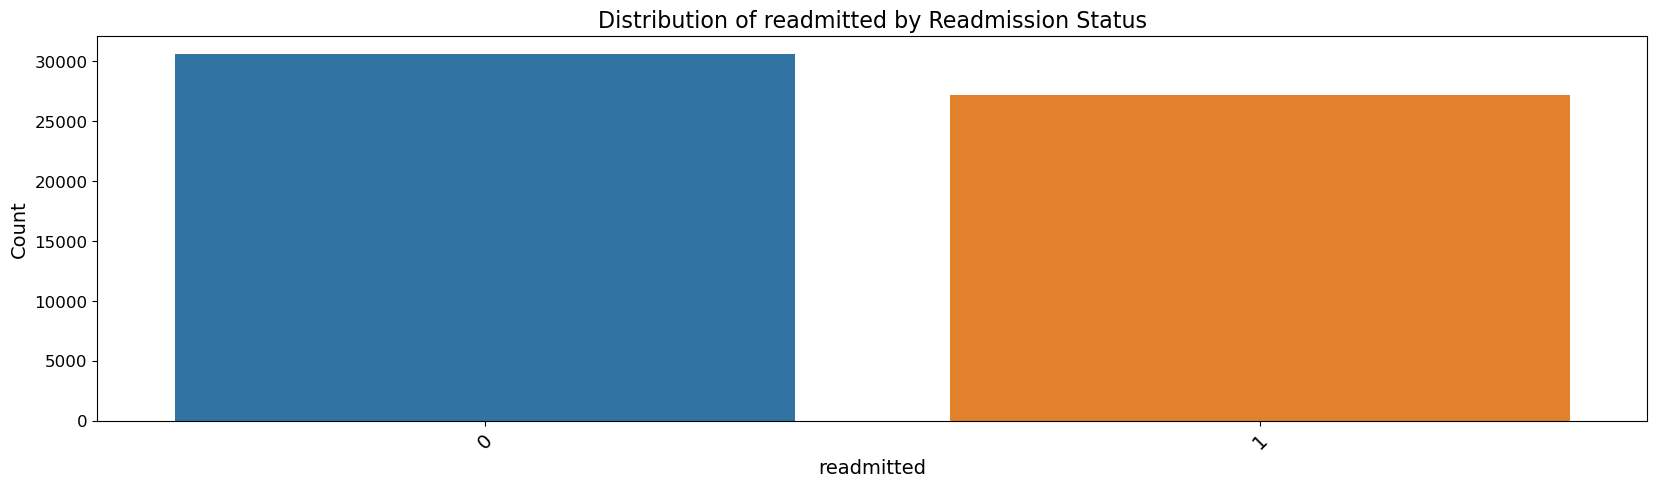

In [28]:

def plot_barplot_with_hue(data, column):
    plt.figure(figsize=(20, 5))
    sns.countplot(data=data, x=column, hue="readmitted")
    plt.title(f"Distribution of {column} by Readmission Status", fontsize=16)
    plt.xlabel(column, fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=12)
    plt.show()


# Iterate over all factor variables and plot them against readmitted
for col in train_factor.columns:
    plot_barplot_with_hue(train_factor, col)

In [29]:

# ====================================================
# Imputing Missing Factor Data
# ====================================================

train_factor_no_target = train_factor.drop("readmitted", axis=1)

# Create and apply the imputer on the remaining columns
factor_imputer = SimpleImputer(strategy="most_frequent")
train_factor_imputed = pd.DataFrame(
    factor_imputer.fit_transform(train_factor_no_target),
    columns=train_factor_no_target.columns,
)

# Optionally, add back the target variable if needed
train_factor_imputed["readmitted"] = train_factor["readmitted"]

# Recompute Summary of Factor Data After Imputation
factor_summary_df_imputed = factor_summary(train_factor_imputed)
factor_summary_df_imputed

variable      n  missing  missing_percentage  unique  \
0                       race  57855        0                 0.0       5   
1                     gender  57855        0                 0.0       3   
2                        age  57855        0                 0.0      10   
3             admission_type  57855        0                 0.0       8   
4      discharge_disposition  57855        0                 0.0      22   
5           admission_source  57855        0                 0.0      17   
6                 payer_code  57855        0                 0.0       3   
7          medical_specialty  57855        0                 0.0      69   
8                  diagnosis  57855        0                 0.0     667   
9              max_glu_serum  57855        0                 0.0       3   
10                 A1Cresult  57855        0                 0.0       3   
11                 metformin  57855        0                 0.0       4   
12               repaglinide  57855        0                 0.0       4   
13               nateglinide  57855        0                 0.0       4   
14            chlorpropamide  57855        0                 0.0       3   
15               glimepiride  57855        0                 0.0       4   
16             acetohexamide  57855        0                 0.0       2   
17                 glipizide  57855        0                 0.0       4   
18                 glyburide  57855        0                 0.0       4   
19               tolbutamide  57855        0                 0.0       2   
20              pioglitazone  57855        0                 0.0       4   
21             rosiglitazone  57855        0                 0.0       4   
22                  acarbose  57855        0                 0.0       4   
23                  miglitol  57855        0                 0.0       4   
24              troglitazone  57855        0                 0.0       2   
25                tolazamide  57855        0                 0.0       2   
26                   examide  57855        0                 0.0       1   
27               citoglipton  57855        0                 0.0       1   
28                   insulin  57855        0                 0.0       4   
29       glyburide-metformin  57855        0                 0.0       4   
30       glipizide-metformin  57855        0                 0.0       2   
31  glimepiride-pioglitazone  57855        0                 0.0       1   
32   metformin-rosiglitazone  57855        0                 0.0       2   
33    metformin-pioglitazone  57855        0                 0.0       2   
34               diabetesMed  57855        0                 0.0       2   
35                readmitted  57855        0                 0.0       2   

    unique_percentage       most_common  most_common_count   2nd_most_common  \
0            0.008642         Caucasian              44828   AfricanAmerican   
1            0.005185            Female              31034              Male   
2            0.017285           [70-80)              14695           [60-70)   
3            0.013828                 1              30503                 3   
4            0.038026                 1              36132                 3   
5            0.029384                 7              32720                 1   
6            0.005185          medicare              40500         insurance   
7            0.119264  InternalMedicine              36270  Emergency/Trauma   
8            1.152882               428               3870               414   
9            0.005185              Norm              56282              >200   
10           0.005185                >8              52800              Norm   
11           0.006914                No              46445            Steady   
12           0.006914                No              56962            Steady   
13           0.006914                No              57432            Steady   
14     

In [30]:

# ====================================================
# Feature Selection of Factor Variables
# ====================================================

# Select Specific Factor Features
train_factor_selected = train_factor_imputed[["medical_specialty", "readmitted"]]
train_factor_selected.info()
factor_summary(train_factor_selected)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57855 entries, 0 to 57854
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  57855 non-null  object
 1   readmitted         57855 non-null  object
dtypes: object(2)
memory usage: 904.1+ KB


variable      n  missing  missing_percentage  unique  \
0  medical_specialty  57855        0                 0.0      69   
1         readmitted  57855        0                 0.0       2   

   unique_percentage       most_common  most_common_count   2nd_most_common  \
0           0.119264  InternalMedicine              36270  Emergency/Trauma   
1           0.003457                 0              30632                 1   

   2nd_most_common_count least_common  least_common_count  
0                   4468       Speech                   1  
1                  27223            1               27223

In [31]:

# ====================================================
# Collapsing Factor Levels
# ====================================================


def lump_top_n(series, n):
    """
    Groups all but the top `n` most frequent categories in a Pandas Series into an 'Other' category.

    Parameters:
        series (pd.Series): The series containing categorical data.
        n (int): Number of top categories to retain.

    Returns:
        pd.Series: Modified series with the top `n` categories retained and others lumped into 'Other'.
    """
    value_counts = series.value_counts()
    top_n_categories = value_counts.nlargest(n).index
    return series.apply(lambda x: x if x in top_n_categories else "Other")


train_factor_collapsed = train_factor_selected.copy()
train_factor_collapsed["medical_specialty"] = lump_top_n(
    train_factor_collapsed["medical_specialty"], n=19
)
train_factor_collapsed["medical_specialty"].value_counts()


medical_specialty
InternalMedicine                     36270
Emergency/Trauma                      4468
Family/GeneralPractice                4209
Cardiology                            3160
Surgery-General                       1851
Other                                 1334
Nephrology                             938
Orthopedics-Reconstructive             737
Orthopedics                            727
Radiologist                            715
Psychiatry                             495
Pulmonology                            477
Surgery-Cardiovascular/Thoracic        417
ObstetricsandGynecology                399
Urology                                390
Surgery-Vascular                       334
Gastroenterology                       322
Surgery-Neuro                          249
Oncology                               195
PhysicalMedicineandRehabilitation      168
Name: count, dtype: int64

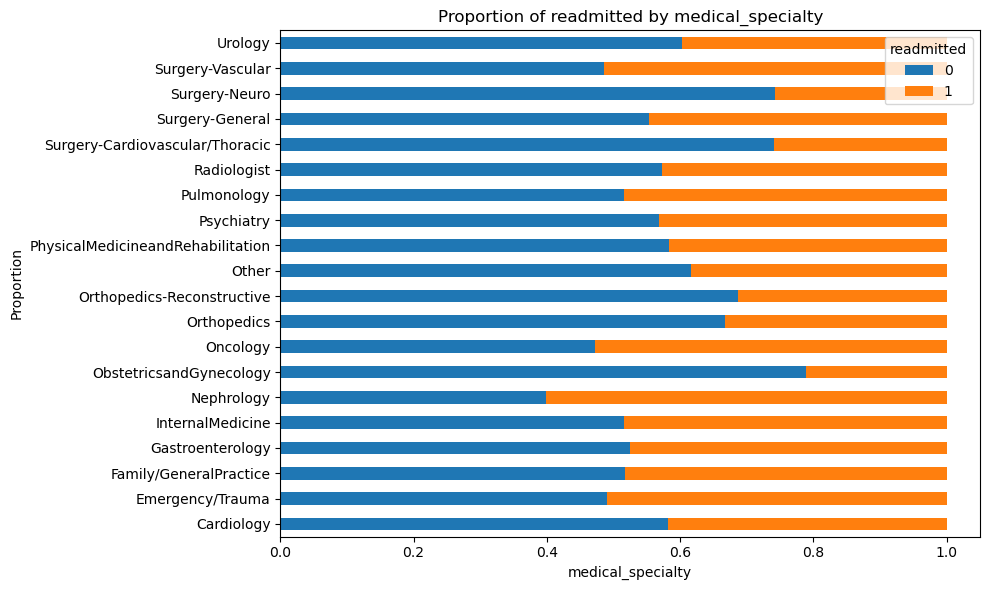

In [32]:

# ====================================================
# Plotting Proportions by `readmitted`
# ====================================================


train_factor_collapsed.groupby(["medical_specialty", "readmitted"]).size().unstack(
    fill_value=0
).apply(lambda x: x / x.sum(), axis=1)


def plot_proportion_by_factor(data, column_name, target_name):
    prop_df = (
        data.groupby([column_name, target_name])
        .size()
        .unstack(fill_value=0)
        .apply(lambda x: x / x.sum(), axis=1)
    )
    prop_df.plot(kind="barh", stacked=True, figsize=(10, 6))
    plt.title(f"Proportion of {target_name} by {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Proportion")
    plt.legend(title=target_name)
    plt.tight_layout()
    plt.show()


for col in ["medical_specialty"]:
    plot_proportion_by_factor(train_factor_collapsed, col, "readmitted")

In [43]:

# ====================================================
# Merging Numeric and Factor Data
# ====================================================

final_data = pd.concat([train_numeric_scaled, train_factor_collapsed], axis=1)

# Checking the Final Data
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57855 entries, 0 to 57854
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   time_in_hospital    57855 non-null  float64
 1   indicator_level     57855 non-null  float64
 2   indicator_2_level   57855 non-null  float64
 3   num_lab_procedures  57855 non-null  float64
 4   num_procedures      57855 non-null  float64
 5   num_medications     57855 non-null  float64
 6   number_diagnoses    57855 non-null  float64
 7   medical_specialty   57855 non-null  object 
 8   readmitted          57855 non-null  object 
dtypes: float64(7), object(2)
memory usage: 4.0+ MB


In [44]:
final_data.isnull().sum()

time_in_hospital      0
indicator_level       0
indicator_2_level     0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_diagnoses      0
medical_specialty     0
readmitted            0
dtype: int64

In [45]:

final_data

time_in_hospital  indicator_level  indicator_2_level  \
0             -1.631975         0.183788           0.218440   
1             -0.266815         0.503869          -1.995195   
2             -0.832893        -0.588806           0.082418   
3             -0.832893         0.231606          -0.077221   
4             -1.631975         0.065016           0.162597   
...                 ...              ...                ...   
57850          0.529787        -0.144642           0.299276   
57851         -0.266815         1.145768          -1.880869   
57852         -1.631975         0.320168           0.833979   
57853          1.717941        -1.287448          -0.908772   
57854          0.832261         1.463333           1.141168   

       num_lab_procedures  num_procedures  num_medications  number_diagnoses  \
0               -0.099844       -1.009818        -2.910446         -0.606600   
1                0.816184       -1.009818         0.455306          0.902381   
2               -1.613502        1.703821        -0.271232         -0.984647   
3                0.052534        0.397437         0.176757         -0.499009   
4                0.408562       -1.009818        -1.131886         -1.349778   
...                   ...             ...              ...               ...   
57850           -1.111596        0.397437         0.176757          0.902381   
57851            0.408562       -1.009818         0.176757          0.902381   
57852            0.510398       -1.009818        -0.944845          5.905382   
57853            0.103355        0.983511         0.848891          0.902381   
57854           -1.513440        1.319721        -2.265529          0.902381   

      medical_specialty readmitted  
0                 Other          0  
1      InternalMedicine          1  
2      InternalMedicine          0  
3      InternalMedicine          0  
4      InternalMedicine          0  
...                 ...        ...  
57850  InternalMedicine          0  
57851  InternalMedicine          1  
57852  InternalMedicine          0  
57853   Surgery-General          0  
57854  InternalMedicine          0  

[57855 rows x 9 columns]

In [46]:

final_data.select_dtypes(include=["object"]).columns


Index(['medical_specialty', 'readmitted'], dtype='object')

In [47]:

print(final_data["medical_specialty"].nunique())
print("-"*50)
print(final_data["medical_specialty"].value_counts())

final_data = pd.get_dummies(final_data, columns=["medical_specialty"], drop_first=True)

final_data["readmitted"].value_counts()
final_data["readmitted"].value_counts(normalize=True)
final_data["readmitted"] = final_data["readmitted"].astype(int)
final_data["readmitted"].unique()

20
--------------------------------------------------
medical_specialty
InternalMedicine                     36270
Emergency/Trauma                      4468
Family/GeneralPractice                4209
Cardiology                            3160
Surgery-General                       1851
Other                                 1334
Nephrology                             938
Orthopedics-Reconstructive             737
Orthopedics                            727
Radiologist                            715
Psychiatry                             495
Pulmonology                            477
Surgery-Cardiovascular/Thoracic        417
ObstetricsandGynecology                399
Urology                                390
Surgery-Vascular                       334
Gastroenterology                       322
Surgery-Neuro                          249
Oncology                               195
PhysicalMedicineandRehabilitation      168
Name: count, dtype: int64


array([0, 1])

In [48]:

"""
# ====================================================
# UnderSampling
# ====================================================

# Separate the two classes
class_0 = final_data[final_data["readmitted"] == 0]
class_1 = final_data[final_data["readmitted"] == 1]

# Randomly undersample the majority class
class_0_downsampled = class_0.sample(n=len(class_1), random_state=42)

# Combine the two classes
final_data_balanced = pd.concat([class_0_downsampled, class_1])

# Shuffle the dataset
final_data_balanced = final_data_balanced.sample(frac=1, random_state=42).reset_index(
    drop=True
)

# ====================================================
# OverSampling
# ====================================================

class_0 = final_data[final_data["readmitted"] == 0]
class_1 = final_data[final_data["readmitted"] == 1]

# Randomly oversample the minority class
class_1_upsampled = class_1.sample(n=len(class_0), replace=True, random_state=42)

# Combine the two classes
final_data_balanced = pd.concat([class_0, class_1_upsampled])

# Shuffle the dataset
final_data_balanced = final_data_balanced.sample(frac=1, random_state=42).reset_index(
    drop=True
)
"""

'\n# ====================================================\n# UnderSampling\n# ====================================================\n\n# Separate the two classes\nclass_0 = final_data[final_data["readmitted"] == 0]\nclass_1 = final_data[final_data["readmitted"] == 1]\n\n# Randomly undersample the majority class\nclass_0_downsampled = class_0.sample(n=len(class_1), random_state=42)\n\n# Combine the two classes\nfinal_data_balanced = pd.concat([class_0_downsampled, class_1])\n\n# Shuffle the dataset\nfinal_data_balanced = final_data_balanced.sample(frac=1, random_state=42).reset_index(\n    drop=True\n)\n\n# ====================================================\n# OverSampling\n# ====================================================\n\nclass_0 = final_data[final_data["readmitted"] == 0]\nclass_1 = final_data[final_data["readmitted"] == 1]\n\n# Randomly oversample the minority class\nclass_1_upsampled = class_1.sample(n=len(class_0), replace=True, random_state=42)\n\n# Combine the two classe

In [49]:

# ====================================================
# Synthetic Oversampling
# ====================================================

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = final_data.drop(columns=["readmitted"])
y = final_data["readmitted"]

X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57855 entries, 0 to 57854
Data columns (total 26 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   time_in_hospital                                     57855 non-null  float64
 1   indicator_level                                      57855 non-null  float64
 2   indicator_2_level                                    57855 non-null  float64
 3   num_lab_procedures                                   57855 non-null  float64
 4   num_procedures                                       57855 non-null  float64
 5   num_medications                                      57855 non-null  float64
 6   number_diagnoses                                     57855 non-null  float64
 7   medical_specialty_Emergency/Trauma                   57855 non-null  bool   
 8   medical_specialty_Family/GeneralPractice             57855 non-nul

In [50]:

# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Combine X and y into a new balanced dataset
final_data_balanced_smote = pd.concat(
    [
        pd.DataFrame(X_smote, columns=X.columns),
        pd.DataFrame(y_smote, columns=["readmitted"]),
    ],
    axis=1,
)

# Verify the balance
print(final_data_balanced_smote["readmitted"].value_counts(normalize=True))


Final_Data = final_data_balanced_smote.copy()
Final_Data.columns.to_list()

readmitted
0    0.5
1    0.5
Name: proportion, dtype: float64


['time_in_hospital',
 'indicator_level',
 'indicator_2_level',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_diagnoses',
 'medical_specialty_Emergency/Trauma',
 'medical_specialty_Family/GeneralPractice',
 'medical_specialty_Gastroenterology',
 'medical_specialty_InternalMedicine',
 'medical_specialty_Nephrology',
 'medical_specialty_ObstetricsandGynecology',
 'medical_specialty_Oncology',
 'medical_specialty_Orthopedics',
 'medical_specialty_Orthopedics-Reconstructive',
 'medical_specialty_Other',
 'medical_specialty_PhysicalMedicineandRehabilitation',
 'medical_specialty_Psychiatry',
 'medical_specialty_Pulmonology',
 'medical_specialty_Radiologist',
 'medical_specialty_Surgery-Cardiovascular/Thoracic',
 'medical_specialty_Surgery-General',
 'medical_specialty_Surgery-Neuro',
 'medical_specialty_Surgery-Vascular',
 'medical_specialty_Urology',
 'readmitted']

In [51]:

# ====================================================
# Modelling
# ====================================================

# Define target variable and features
X = Final_Data.drop(columns=["readmitted"])
y = Final_Data["readmitted"]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.52      0.55     30632
           1       0.56      0.62      0.59     30632

    accuracy                           0.57     61264
   macro avg       0.57      0.57      0.57     61264
weighted avg       0.57      0.57      0.57     61264

Confusion Matrix:
[[16022 14610]
 [11680 18952]]


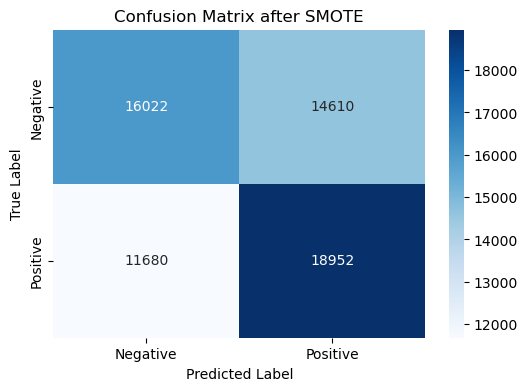

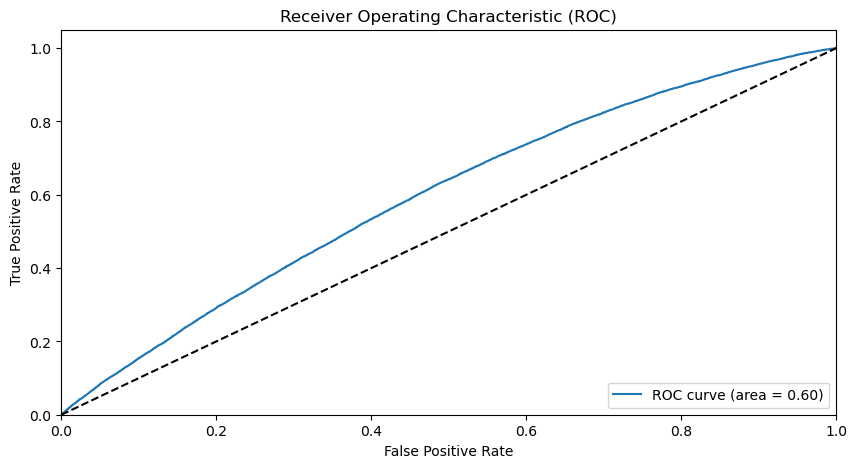

Variable Importance:
                                              Feature  Coefficient
12          medical_specialty_ObstetricsandGynecology    -0.827486
21  medical_specialty_Surgery-Cardiovascular/Thoracic    -0.766772
11                       medical_specialty_Nephrology     0.703496
23                    medical_specialty_Surgery-Neuro    -0.489085
15       medical_specialty_Orthopedics-Reconstructive    -0.441417
24                 medical_specialty_Surgery-Vascular     0.371996
14                      medical_specialty_Orthopedics    -0.341021
13                         medical_specialty_Oncology     0.311909
7                  medical_specialty_Emergency/Trauma     0.305870
8            medical_specialty_Family/GeneralPractice     0.257074
9                  medical_specialty_Gastroenterology     0.251082
19                      medical_specialty_Pulmonology     0.243921
10                 medical_specialty_InternalMedicine     0.195079
6                                    numb

In [52]:

# ====================================================
# Logistic Regression
# ====================================================

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# Generate predictions and predicted probabilities
y_pred = model.predict(X)
y_pred_proba = model.predict_proba(X)[:, 1]

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(cm)


# Visualizing confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix after SMOTE")
plt.show()

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = roc_auc_score(y, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")  # Diagonal line for random performance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

# Print variable importance (i.e. coefficients)
importance = pd.DataFrame(
    {"Feature": X.columns, "Coefficient": model.coef_[0]}
).sort_values(by="Coefficient", key=abs, ascending=False)

print("Variable Importance:")
print(importance)


Best Hyperparameters:
{'C': 0.031081091085493954, 'penalty': 'l2'}
Best ROC AUC (CV): 0.5856362082158805

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.53      0.55     30632
           1       0.57      0.61      0.59     30632

    accuracy                           0.57     61264
   macro avg       0.57      0.57      0.57     61264
weighted avg       0.57      0.57      0.57     61264

Confusion Matrix:
[[16139 14493]
 [11797 18835]]


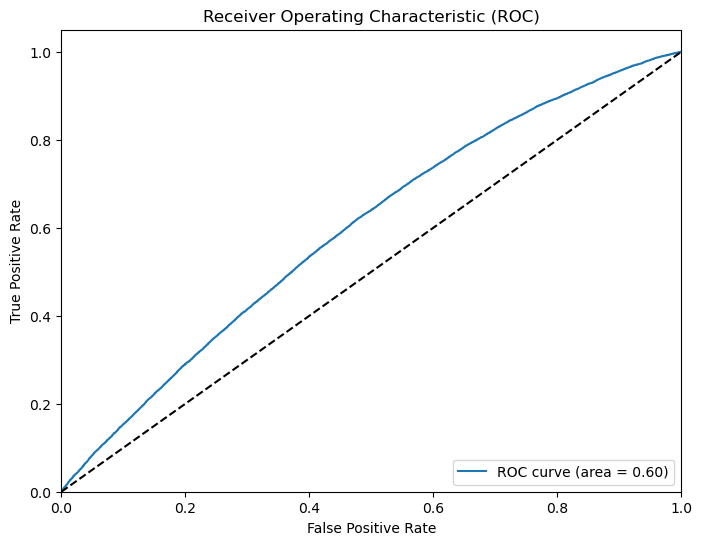

Variable Importance:
                                              Feature  Coefficient
11                       medical_specialty_Nephrology     0.618651
12          medical_specialty_ObstetricsandGynecology    -0.597743
21  medical_specialty_Surgery-Cardiovascular/Thoracic    -0.559030
15       medical_specialty_Orthopedics-Reconstructive    -0.379135
23                    medical_specialty_Surgery-Neuro    -0.365355
14                      medical_specialty_Orthopedics    -0.299235
7                  medical_specialty_Emergency/Trauma     0.278425
24                 medical_specialty_Surgery-Vascular     0.256707
8            medical_specialty_Family/GeneralPractice     0.232626
13                         medical_specialty_Oncology     0.229828
6                                    number_diagnoses     0.179181
10                 medical_specialty_InternalMedicine     0.176289
9                  medical_specialty_Gastroenterology     0.168115
5                                     num

In [53]:

# ====================================================
# Logistic regression Hyperparamter tuning
# ====================================================

from scipy.stats import loguniform

param_grid = {"C": loguniform(0.001, 100), "penalty": ["l1", "l2"]}

# Initialize the logistic regression model with a solver that supports both L1 and L2 penalties
lr = LogisticRegression(max_iter=1000, solver="liblinear")

# Set up the GridSearchCV to tune hyperparameters based on ROC AUC score using 5-fold CV
random_search = RandomizedSearchCV(lr, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
random_search.fit(X, y)

# Print the best hyperparameters and best ROC AUC score from cross-validation
print("Best Hyperparameters:")
print(random_search.best_params_)
print("Best ROC AUC (CV):", random_search.best_score_)

# Use the best estimator for further evaluation
best_model = random_search.best_estimator_

# Generate predictions and predicted probabilities using the best model
y_pred = best_model.predict(X)
y_pred_proba = best_model.predict_proba(X)[:, 1]

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(cm)


# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = roc_auc_score(y, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")  # Diagonal line for random performance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

# Print variable importance (i.e., the coefficients of the logistic regression model)
importance = pd.DataFrame(
    {"Feature": X.columns, "Coefficient": best_model.coef_[0]}
).sort_values(by="Coefficient", key=abs, ascending=False)

print("Variable Importance:")
print(importance)

Running RandomizedSearchCV for LogisticRegression...
Best parameters for LogisticRegression: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.3157894736842105, 'C': 0.07847599703514611}
Best Logloss Score for LogisticRegression: 0.6830931006073779
--------------------------------------------------
Running RandomizedSearchCV for RandomForest...


/opt/anaconda3/envs/mlp_homeworks/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for RandomForest: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': True}
Best Logloss Score for RandomForest: 0.6769669979396612
--------------------------------------------------
Running RandomizedSearchCV for KNeighborsClassifier...
Best parameters for KNeighborsClassifier: {'weights': 'uniform', 'p': 1, 'n_neighbors': 25, 'leaf_size': 80, 'algorithm': 'brute'}
Best Logloss Score for KNeighborsClassifier: 0.6994912385082777
--------------------------------------------------
Running RandomizedSearchCV for AdaBoostClassifier...


/opt/anaconda3/envs/mlp_homeworks/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/mlp_homeworks/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/mlp_homeworks/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/mlp_homeworks/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. U

Best parameters for AdaBoostClassifier: {'n_estimators': 200, 'learning_rate': 0.01}
Best Logloss Score for AdaBoostClassifier: 0.6893329814690645
--------------------------------------------------
Running RandomizedSearchCV for GradientBoostingClassifier...
Best parameters for GradientBoostingClassifier: {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.01}
Best Logloss Score for GradientBoostingClassifier: 0.6825522865682732
--------------------------------------------------
Best hyperparameters and Logloss scores for each model:
LogisticRegression: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.3157894736842105, 'C': 0.07847599703514611} with Logloss = 0.6830931006073779
RandomForest: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': True} with Logloss = 0.6769669979396612
KNeighborsClassifier: {'weights': 'uniform', 'p': 1, 'n_neighbors': 25, 'leaf_size': 80, 'algorithm': 'brute'} with Logloss = 0.

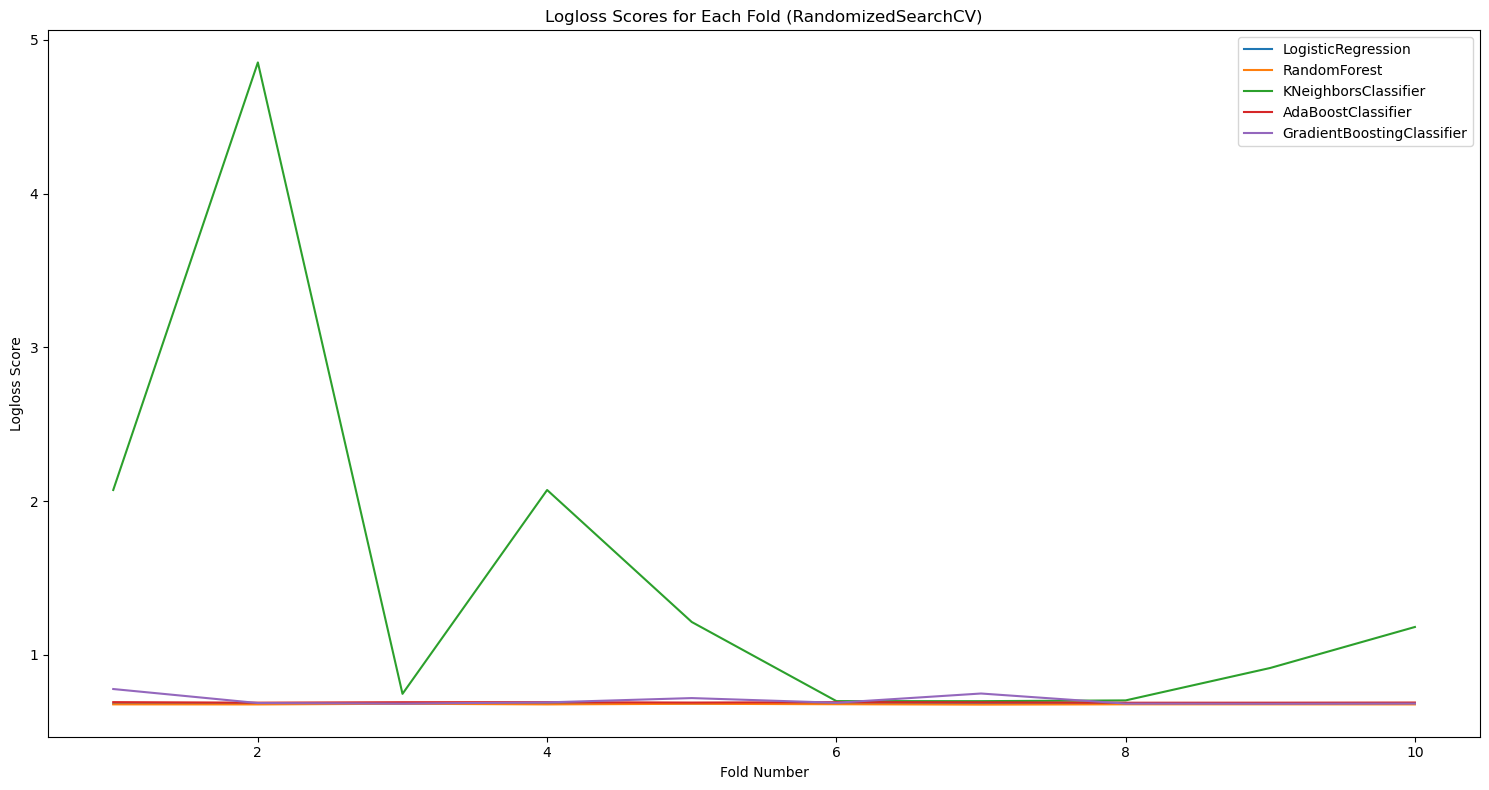

In [54]:

###############################################
# Hyperparameter Tuning for -
# LogisticRegression,
# RandomForest,
# SVC,
# KNeighborsClassifier,
# AdaBoostClassifier
# GradientBoostingClassifier
###############################################


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import numpy as np


# Define hyperparameter distributions for different models
param_grids = {
    "LogisticRegression": {
        "C": np.logspace(-3, 3, 20),
        "penalty": ["elasticnet"],
        "l1_ratio": np.linspace(0, 1, 20),
        "solver": ["saga"],
    },
    "RandomForest": {
        "n_estimators": np.arange(50, 500, 50),
        "max_depth": [None, 10, 20, 30, 40, 50],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    },
    # "SVC": {
    #     "C": np.logspace(-3, 3, 20),
    #     "kernel": ["linear", "rbf", "poly", "sigmoid"],
    #     "gamma": ["scale", "auto"],
    #     "degree": np.arange(1, 5),
    # },
    "KNeighborsClassifier": {
        "n_neighbors": np.arange(3, 30, 2),
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "leaf_size": np.arange(20, 100, 10),
        "p": [1, 2],  # 1 for Manhattan distance, 2 for Euclidean distance
    },
    "AdaBoostClassifier": {
        "n_estimators": np.arange(50, 500, 50),
        "learning_rate": [0.001, 0.01, 0.1, 1],
    },
    "GradientBoostingClassifier": {
        "n_estimators": np.arange(50, 500, 50),
        "learning_rate": [0.001, 0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7, 9],
        "subsample": [0.8, 0.9, 1.0],
    },
}

# Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=100, solver="saga"),
    "RandomForest": RandomForestClassifier(),
    # "SVC": SVC(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
}

best_params = {}
best_logloss_scores = {}

# Initialize a dictionary to store the logloss scores for each model and fold
fold_logloss_scores = {model_name: [] for model_name in models}

for model_name, model in models.items():
    print(f"Running RandomizedSearchCV for {model_name}...")

    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_grids[model_name],
        n_iter=10,  # Number of random combinations to try
        cv=5,
        scoring="neg_log_loss",  # Using negative log loss
        n_jobs=-1,
        random_state=42,
        return_train_score=False,  # We don't need training scores
    )

    random_search.fit(X, y)

    # Convert negative log loss to positive log loss values for clarity
    best_params[model_name] = random_search.best_params_
    best_logloss_scores[model_name] = -random_search.best_score_

    # Convert fold scores to positive values
    fold_logloss_scores[model_name] = -np.array(
        random_search.cv_results_["mean_test_score"]
    )

    print(f"Best parameters for {model_name}: {random_search.best_params_}")
    print(f"Best Logloss Score for {model_name}: {-random_search.best_score_}")
    print("-" * 50)

###############################################
# Print final best parameters and Logloss scores for all models
###############################################

print("Best hyperparameters and Logloss scores for each model:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params} with Logloss = {best_logloss_scores[model_name]}")

###############################################
# Plot the Logloss scores for each fold for each model
###############################################

fig, ax = plt.subplots(figsize=(15, 8))

for model_name, logloss_scores in fold_logloss_scores.items():
    ax.plot(range(1, len(logloss_scores) + 1), logloss_scores, label=model_name)

ax.set_title("Logloss Scores for Each Fold (RandomizedSearchCV)")
ax.set_xlabel("Fold Number")
ax.set_ylabel("Logloss Score")
ax.legend()
fig.tight_layout()

plt.show()


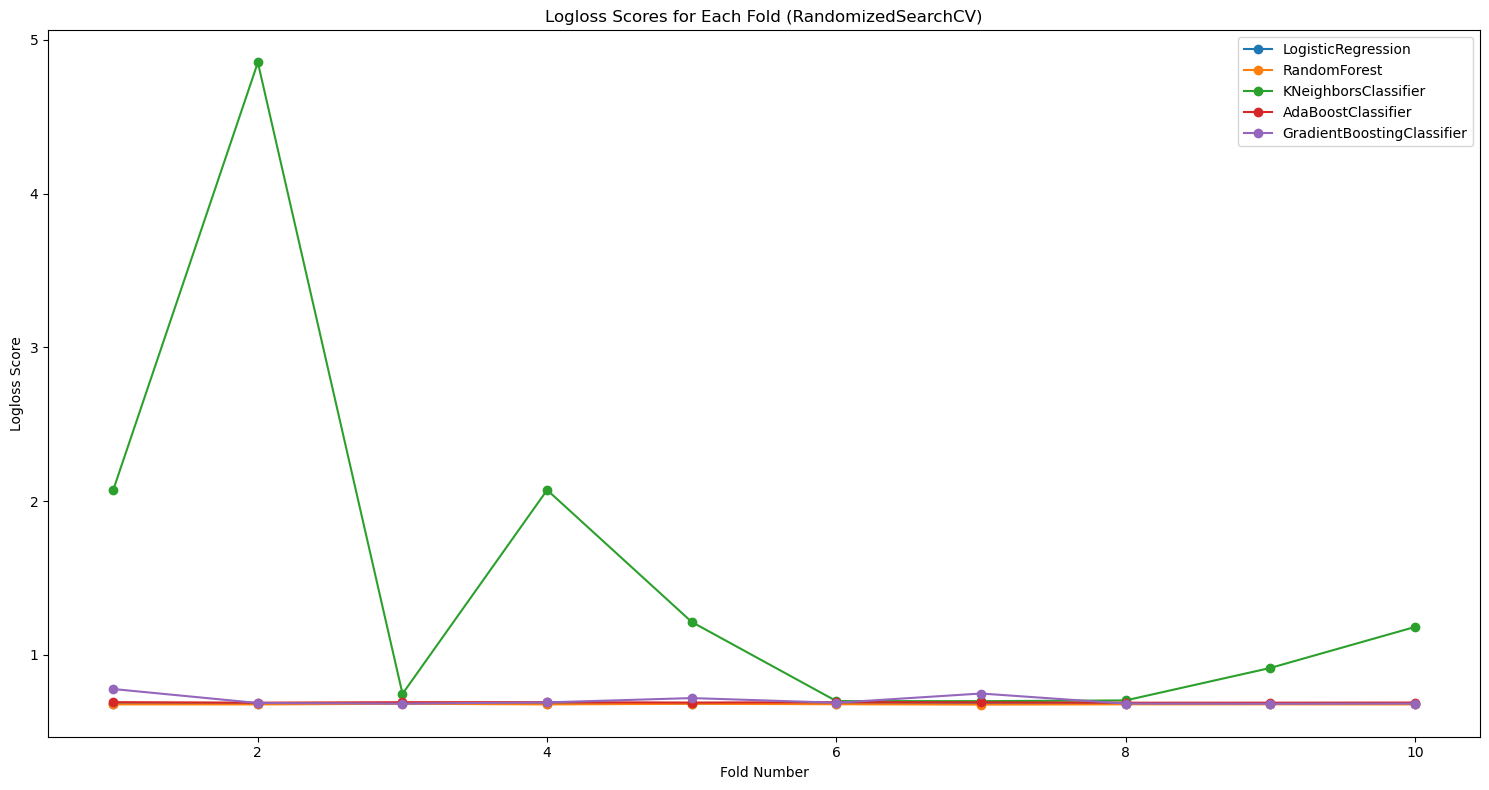

In [58]:

###############################################
# Plot the Logloss scores for each fold for each model
###############################################

from matplotlib import markers


fig, ax = plt.subplots(figsize=(15, 8))

for model_name, logloss_scores in fold_logloss_scores.items():
    ax.plot(range(1, len(logloss_scores) + 1), logloss_scores, label=model_name, marker = "o")

ax.set_title("Logloss Scores for Each Fold (RandomizedSearchCV)")
ax.set_xlabel("Fold Number")
ax.set_ylabel("Logloss Score")
ax.legend()
fig.tight_layout()

plt.show()


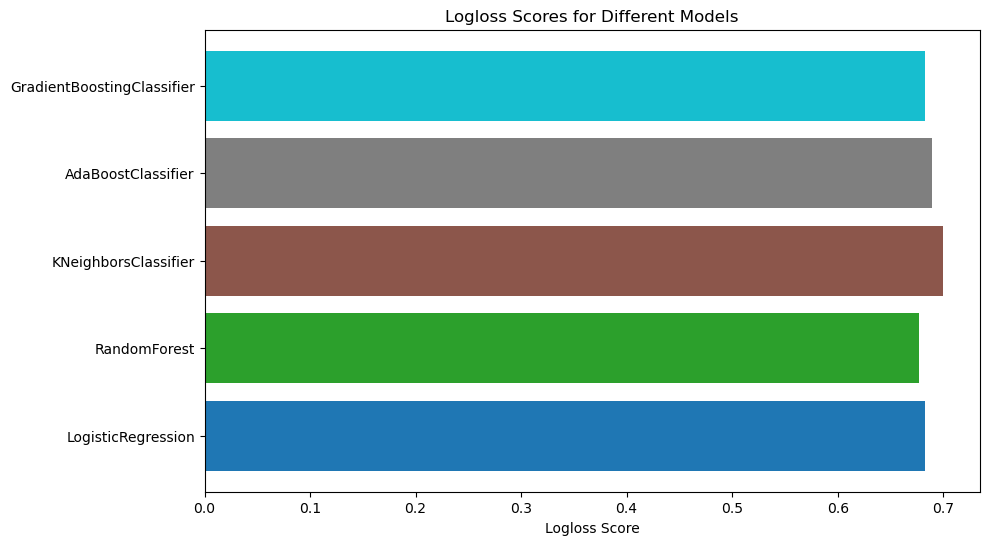

In [55]:

###############################################
# Plotting the Logloss Scores for Each Model
###############################################

# Data for plotting
model_names = list(best_logloss_scores.keys())
logloss_scores = list(best_logloss_scores.values())

plt.figure(figsize=(10, 6))

# Using a colormap to create a gradient of colors
colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))

plt.barh(model_names, logloss_scores, color=colors)
plt.xlabel("Logloss Score")
plt.title("Logloss Scores for Different Models")
plt.show()